In [1]:
import os
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
import numpy as np
import re

In [2]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [3]:
SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)

In [4]:
tokenizer = BertTokenizer.from_pretrained("dbmdz/bert-base-turkish-cased",
                                          cache_dir='bert_ckpt',
                                          do_lower_case=False)

In [5]:
#random seed 고정
tf.random.set_seed(0)
np.random.seed(0)

# BASE PARAM
BATCH_SIZE = 32
NUM_EPOCHS = 5
VALID_SPLIT = 0.2
MAX_LEN = 28 * 2 

DATA_IN_PATH = 'C:\\Users\\Msı\\Desktop\\IBSS\\100-ml-projects\\007\\STSb-TR'
DATA_OUT_PATH = "data_out/KOR"

In [6]:
# Test Tokenizers
kor_encode = tokenizer.encode("merhaba dünya")
eng_encode = tokenizer.encode("dünya merhaba")

kor_decode = tokenizer.decode(kor_encode)
eng_decode = tokenizer.decode(eng_encode)

print(kor_encode)
print(eng_encode)
print(kor_decode)
print(eng_decode)

[2, 9714, 3078, 3]
[2, 3078, 9714, 3]
[CLS] merhaba dünya [SEP]
[CLS] dünya merhaba [SEP]


In [8]:
# Load Train dataset

TRAIN_STS_DF = os.path.join(DATA_IN_PATH, 'stsb_tr.tsv')


data = pd.read_csv(TRAIN_STS_DF, header=0, delimiter = '\t', quoting = 3)
#dev_data = train_data[:750]

#print("Total # dataset: train - {}, dev - {}".format(len(train_data), len(dev_data)))

In [12]:
train_data, dev_data = train_test_split(data, test_size=0.33 )

In [13]:
print("Total # dataset: train - {}, dev - {}".format(len(train_data), len(dev_data)))

Total # dataset: train - 5780, dev - 2848


In [15]:
# Bert Tokenizer

#https://huggingface.co/transformers/main_classes/tokenizer.html?highlight=encode_plus#transformers.PreTrainedTokenizer.encode_plus

def bert_tokenizer_v2(sent1, sent2, MAX_LEN):
    # For two sentence input
    
    encoded_dict = tokenizer.encode_plus(
        text = sent1, 
        text_pair = sent2,
        add_special_tokens = True,
        max_length = MAX_LEN,
        pad_to_max_length = True,
        return_attention_mask = True
    )
    
    input_id = encoded_dict['input_ids']
    attention_mask = encoded_dict['attention_mask']
    token_type_id = encoded_dict['token_type_ids']
    
    return input_id, attention_mask, token_type_id

In [16]:


def clean_text(sent):
    sent_clean = re.sub('[^a-zA-Z0-9ㄱ-ㅣ가-힣\\s]', ' ', sent )
    
    return sent_clean

In [17]:
input_ids = []
attention_masks = []
token_type_ids = []
data_labels = []

for sent1, sent2, score in train_data[['sentence1', 'sentence2', 'score']].values:
    print(sent1)
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer_v2(clean_text(sent1), clean_text(sent2), MAX_LEN)
        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        data_labels.append(score)
    except Exception as e:
        print(e)
        print(sent1, sent2)
        pass

print(attention_masks)
    
train_input_ids = np.array(input_ids, dtype=int)
train_attention_masks = np.array(attention_masks, dtype=int)
train_type_ids = np.array(token_type_ids, dtype=int)
train_inputs = (train_input_ids, train_attention_masks, train_type_ids)
train_data_labels = np.array(data_labels)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Bir adam bir fırça ile yerde duruyor
Mısırlılar bölücü anayasayı oyladı
Midenizde oksidasyonu önlemek için meyveler limon suyu ile yenmelidir.
Gusmao, Doğu Timor seçimlerinde gücü pekiştiriyor
Filipinler tayfun ölü sayısı 4.460: BM
FBI, CIA, Kanada Güvenlik İstihbarat Servisi ve Kanada Kraliyet Atlı Polisi Sözcüleri El Shukrijumah'ın Kanada'da kalışı hakkında yorum yapmayı reddetti.
İki Sumo çanı birbiriyle savaşıyor.
Vali, eyaletteki 16 ölümden 13'ünün rapor edildiği Jackson'a gidiyor.
Punjab Mail, Rohtak yakınlarında raydan çıktı, 19 yaralı
Bu, set in eski rekorunu gölgede bırakır.
Allen, Farrow'un istismar iddialarına mektupla yanıt veriyor
Kaykay süren bir insan.
Aktivistler, toplanmanın kurumsal çiftçiliğin biyo-mühendislik ürünü ekinleri açlık çeken ülkelere itme girişimi olmasından korktuklarını söylüyor.
Usame Bin Ladin'in Eşleri Hapsedilecek
İki adam bir arabanın bagajına valiz koyuyor.
Tohuma gittikten sonra tohumları toplama şansı aslında yeni büyümeyi teşvik etmeyecek.
Pemb

C:\ProgramData\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2073: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Washington: Medicare Dolandırıcılık Taramasında 100'den Fazla Kişi Suçlandı
Okyanusa yakın tırtıklı kayaların üstünde duran adam.
ABD'nin drone saldırısında Taliban yanlısı savaş ağası öldürüldü
Başka bir kız onları görmezden gelirken oğlan kıza bakıyor.
Netanyahu erken seçim çağrısı yapacak
Fransız Francois Hollande, Euro krizinin bittiğini söylüyor
Sylvester Stallone'un oğlu Hollywood'da ölü bulundu
Clinton, Kenya'yı seçim şiddetinin maliyeti konusunda uyardı
Pakistan infazları uluslararası öfke yaratıyor
Obama eşcinsel evliliği onayladı
Kaldırım boyunca koşan genç çocuklar.
Avustralya oranları rekor düzeyde düşürdü
Bunun kötü bir fikir olduğunu düşünüyorum.
Afganistan'daki operasyonda 5 yardım çalışanı serbest bırakıldı
Sienna Miller, İngiltere'deki telefon korsanlığı davasında ifade verdi
Batı Çin'de üç Tibetli kendini yaktı: Haber
Biri bir şişeyi kılıçla dilimler.
Kahverengi bir köpek, arka planda dağlar olan toprak bir yolda kameraya doğru koşar.
ilaçla ilgili çok endişe var.
Bir

Bir giyim mağazasında iki kadın.
Duvarda bir resim ve tavan vantilatörü bulunan odada masa ve sandalyeler vardır.
BM yardım şefi Amos, Kızılay'la Baba Amr'a girdi
2013'ün en güçlü tayfunu Filipinler'i vurdu
Geniş bir alanda duran iki inek.
Uluslararası Af Örgütü, son 20 yılda Irak'taki 17.000 kayıp hakkında bilgi topladığını ancak gerçek rakamın çok daha yüksek olabileceğini söyledi.
Çin hisse senetleri Pazartesi günü yatay açıldı
N Waziristan'da insansız hava aracı saldırısında altı kişi öldü
Bir adam bir karıştırma kabına tereyağı parçalarını kesiyor.
Barack Obama'nın korumaları fuhuş skandalının ardından ABD'ye geri gönderildi
Bağdat'ta intihar saldırısında sekiz kişi öldü
Endonezya terörle mücadele ekibi şüpheli iki militanı öldürdü
Bir kadın, bir erkeğin omuzlarına çelenk koyar.
Karda oynayan iki köpek.
Bir kişi tavaya yağ ekliyor.
Artık sadece New Jersey, öğrenci sahiplerinin araç kullanırken cep telefonu, çağrı cihazı veya diğer kablosuz cihazları kullanma izinlerini veya ara li

Bir kadın, bir erkeğe şakacı makyaj yapıyor.
Güney Afrika mayın şiddetini araştırmaya başladı
Yıl için, 94 milyon dolarlık satış ve devam eden operasyonlardan 26 sent kar bekliyor.
Anatoly Sokolov, Moskova çevresinde Sovyet yapımı A-135 füze savunma sisteminin eski ve etkisiz olduğunu duyurdu.
öksüz Alpler katliamı kızı İngiltere'ye döndü
Kuzey Kore, Güney ile Aile Buluşmalarını Erteledi
Çift, çim sandalyelerde suya yakın oturuyor.
Bir adam bir çörek dilimliyor.
Bir sonraki adımda ne yapmak istediğinize ve bunu nerede yapmak istediğinize bağlıdır.
Kuzu kameraya bakıyor.
myanmar askeri bir devlettir.
ABD Savcısı Marcos Jimenez, 32 maddelik bir iddianamenin "uyuşturucu kaçakçılığı dünyasındaki en önemli hedeflerden birine saldırdığını" söyledi.
Ben buna inanıyorum.
Sandy Kuzeydoğu'ya çarpar; en az 18 ölü, 7,4 milyon güçsüz
ABD zorunlu olmayan personele Sudan ve Tunus'tan ayrılma emri verdi
Bangladeş Muhalefet Lideri Savaş Suçları Nedeniyle Ölüme Mahkum Edildi
Radyo: İsrail, Filistinli ma

Eric Gagne, dokuzuncu turda üçünü geride bıraktığı ve Greg Norton'un yalnızca bir saha içi bekarına izin verdiği kadar çok fırsatta 17. tasarrufunu elde etti.
Çalışma, geçtiğimiz on yıllarda uzun hatların 100 kanca başına 10 balık yakaladığı yerlerde, şimdi bir tane yakaladıkları için şanslılar.
berlin, ekim ayında avrupa silah kontrol anlaşmasının avrupa'daki konvansiyonel güçlerini (cfe) kurtarmak için üst düzey toplantılara ev sahipliği yapacak.
@Frank Apisa, Frank, görüyorum ve anlıyorum.
Bir köpek, bir çocuğu iki kez suya düşürür.
Bir kadın bir çevre boyunca ata biniyor.
Bir kadın bazı yiyeceklere sos ekliyor.
Ukrayna'nın hapishanedeki muhalefet ikonu Timoşenko serbest kaldı
Bir bebek gülüyor.
Çimlerin arasından bir köpek koşar.
Bir masanın üzerinde uzanmış gri ve beyaz yerli kedi.
Bir adam tencere suyu tekmeliyor.
Bazı kadınlar, pek çok kadının bedensel mükemmellik arayışında estetik cerrahiye dönmesinden de endişe duyuyor.
Güney Afrika Mandela İmzalayan 'Şizofren' Konusundaki Ha

Castro Pazartesi 86. yaş gününü kutladı
Merdivenlerin dibinde iki siyah beyaz köpek.
Enron sözcüsü Eric Thode, arabuluculuk kararı hakkında yorum yapmayı reddetti.
Halliburton Salı günü, KBR'nin "Irak'a en iyi değer, en iyi fiyat ve en iyi koşullarda akaryakıt teslim ettiği" iddiasını yineledi.
Eylül ayında Hewlett-Packard, şirketle bir geliştirme ve pazarlama anlaşması imzaladı.
Küçük bir çocuk ve dışarıda birlikte oynayan küçük bir kız.
Sezon başlamadan önceydi çünkü Amy kadını Sessizlik onu almadan önce görmüştü.
İntihar bombacısı 23 Iraklı askerini öldürdü
Nijerya: Öğrenci katliamında 40 kişinin öldürülmesinin ardından Nijeryalı askerler toplandı
Abbey, PeopleSoft'un Anaheim Kongre Merkezi'ndeki yıllık müşteri konferansında 10.000'den fazla katılımcının katıldığı kalabalığın önünde Conway ile birlikte sahneye çıktı.
Barbini, sendikanın Amerika Birleşik Devletleri ile bir uzlaşmaya varabileceğini, ancak bu tür yiyecekleri etiketlemek için bir sistem istediğini, endüstrinin burada ba

Güncellenen ürünler arasında Pylon Pro, Pylon Conduit, Pylon Anywhere ve Pylon Uygulama Sunucusu bulunmaktadır.
Oracle hisseleri 27 sent veya yüzde 2 düşüşle 13.09 dolara geriledi.
Brendsel ve finans müdürü Vaughn Clarke 9 Haziran'da istifa etti.
Şiiler ülke nüfusunun yüzde 20'sini oluşturuyor.
George Zimmerman, Trayvon Martin cinayetinden suçsuz bulundu
Çimlerde bir koyunun yakından görünümü.
Bir kadın ve bir erkek kulaklıklarla eğlenir.
Afganistan'daki intihar patlamasında dört Fransız askeri öldürüldü
Bir kadın bir tavaya et dilimlerini koyar.
Tahran: AB yaptırımları İran'ı nükleer müzakerelere zorlamayacak
Neyi sevip neyi sevmediğini bilmek için çok okumalısın.
Avrupa Birliği 1998'de genetiği değiştirilmiş gıda ithalatını yasakladı; Amerika Birleşik Devletleri şimdi AB'nin yasağına son vermesini talep ediyor.
Bir adam bir resim çiziyor.
Hindistan'ın büyük bir kısmı Porus tarafından değil, Pataliputra merkezli Nanda hanedanı tarafından kontrol ediliyordu.
Yapılan bir anket, FBI'ın b

Çin'de bir düzenin bozulması önemli bir küresel kargaşaya yol açacaktır.
Rockingham'daki North Carolina Speedway yetkililerine ulaşılamadı.
Bu pozisyonda Elias, EMC'nin başkanı ve CEO'su Joe Tucci'ye rapor verecek.
Bir kişinin eldivenli eline mavi bir kuş tünemiş.
Palm Wednesday, birçok kişi tarafından Palm avuçiçi cihazının babası olarak kabul edilen ve Jeff Hawkins tarafından kurulan bir şirket olan Handspring'i satın alma planlarını duyurdu.
İki küçük kız telefonla konuşuyor.
Kahverengi bir köpek, suyu silkeleyerek her yere su sıçratıyor.
Siyah ve kahverengi bir köpek ormanın içinden geçiyor.
Rusya, Pussy Riot protesto serserilerini iki yıl hapse attı
Turuncu yelekli bir adam mavi suda kano kullanıyor.
Astar / boya işe yaramayacak.
İran yeni nükleer müzakerelere hazır olduğunu söyledi
14 Aralık'ta büyük İran gazetelerinde manşetler
İleri değerlendirme için hafta sonu Raffles Hastanesindeydiler.
Kırmızı ve beyaz bir otobüs İngiltere'deki bir caddede ilerliyor.
İkinci yarıyı birincide

Obamas'ın görüşlerini beğenmeyebilirsiniz ama onda var.
Putin, Kırım ilhak anlaşması imzaladı
Sunderland 2-2 Bolton: Davies ikiye katlama Trotters'a bir puan kazandırıyor ancak son üçte kalıyorlar
Basit cevap evet, marulda çiçek sürgünleri kesin bir cıvatalama belirtisidir.
Pakistan'daki örtülü savaş
Yakın zamanda IKEA'dan iki otur / kalk Galant masası satın aldım ve onlardan oldukça memnunum.
Çin'in güneyindeki yol mağarasında 5 kişi öldü
Google internet ışınlı balonları başlattı
TAFB VE SAB'DEN UYDU YOĞUNLUK TAHMİNLERİ YALNIZCA T. /
Çin depremi: Ölüm sayısı artıyor
Avrupa'da yürütülen yeni bir çalışma, ilacın, ImClone Systems tarafından desteklenen daha önceki bir tartışmalı çalışma kadar işe yaradığını buldu.
Afgan milletvekilleri yeni seçim yasasını onayladı
Meksika şeker fabrikası patlamasında 1 kişi öldü, 40 kişi yaralandı
Genç bir çocuk gri kiremitli bir alanda duruyor.
Lionel Richie tavanda dans ediyor.
Suriye'nin kuzeybatısında bombalı araç 20 kişiyi öldürdü
Atlantik fırtına s

Tunuslu muhalif siyasetçi vurularak öldürüldü
Rio havaalanı işçileri FIFA Dünya Kupası arifesinde grevde
Pakistan, ABD'nin Shawal Bölgesi'ndeki insansız hava aracı saldırısını kınadı
Bisikletin çektiği bir arabayı kullanan bir kişi.
Ten rengi bir köpek yavrusu seviliyor.
Tahta muhtemelen çürümüş değil, sadece eskimiş.
Sahilde sarı tekne.
Bir kadın su altında yüzüyor.
Orijinal soruyla ilgili olabilecek ek bir kavram buldum: prototip teorisi.
Sayın Prodi ekledi: "Belki, ama yaşlılık, güçlü yönlerimizi ve zayıflığımızı anlamamıza yardımcı oluyor."
Artan yönde, Coca-Cola Co. (nyse: KO - haberler - insanlar) Avrupa talebinin de yardımıyla Perşembe günü erken saatlerde çeyrek için daha yüksek kar bildirdi.
Dow Jones sanayi ortalaması <.DJI> 58.69 puan veya yüzde 0.64 düşüşle 9.137.86 oldu.
Adam telefonla konuştu.
NATO: Afganistan saldırısında 3 asker öldü
Bir kişi büyük bir dokunmatik ekrana çizim yapıyor.
İnsanlar izlerken siyah çemberden zıplayan Alman Çoban
Bir erkek ve bir kadın beyaz bi

Eyalet polisi, garajın çökmesinin hemen ardından 30 kadar işçinin mahsur kaldığını söyledi.
O halde soruyu cevapla.
Libya hükümeti Trablus havaalanını geri aldı
Piskopos polise bir köpeğe veya kediye çarptığını veya birinin aracına taş attığını düşündüğünü söyledi.
Pencereden dışarı bakarak kanepede birlikte oturan iki kedi.
Diyafram açıklığı ve odak uzaklığının yanı sıra, alan derinliği de kamera-konu mesafesi ile azalır.
Taliban yaklaşırken bile Afganlar kolejlere akın ediyor
Bilim adamları, Prehistorik Tohumlardan Çiçekleri Diriltiyor
Bir kadın yağmurda dans ediyor.
Adam toprak bir tepeden aşağı bisiklet sürüyor.
Besleyiciden yiyen küçük bir kuş.
Red Sox Beat Tigers 5-2, World Series'e Yükseliyor
Ateş edildikten sonra ABD Kongre Binası kilitlendi
Patronuna senden ne yapmanı istediğini sormalısın.
Arka planda çim ile su kütlesi üzerinde siyah beyaz bir kuş.
Evet, eğik çizgi yerine gerçek kelimeyi yazarsanız cümleniz daha net olacaktır.
Havuz kenarında yürüyen siyah bir köpek.
Çimleri

Yerde bir kedi oynuyor.
Bir adam gitar çalıyor ve şarkı söylüyor.
Bazı çocuklar Trambolin'e atlıyor.
İngiliz altına hücum sessizliği maliyeti aştı
Suriye Başbakanı Bombalı Saldırıdan Kurtuldu
Sağlık görevlileri bir hastayı sedye üzerinde taşır.
Vietnam, dünyanın en sert uyuşturucu yasalarına sahiptir.
Hayvanat bahçesinde işçi, kaplan saldırısından sonra öldü
Küçük beyaz ve kahverengi bir köpek yatay bir direğin üzerinden atlıyor.
Bir adam bir kutuyu açıp kağıt çıkarıyor.
Doğru anladın.
kuzey kore nükleer hırs iddia etti ve şu anda kuzey kore'nin Japonya'yı hedef alan füzeleri olduğu bildiriliyor.
Mali Kasabası İçin Mücadele İslamcı Taktikleri Yansıtıyor
Londra Maratonu, Boston'daki bomba kurbanları için sessizlik gözlemledi
Öncelikle iki şeye bağlı olduğunu söyleyebilirim:
Bir kişi kızarıyor.
Hindistan Çin'i fiilen sınırı geçmekle suçluyor
Ben de benzer bir durumdaydım.
Colorado'da ateş eden zanlı tedavi görüyordu
Bir kadın yolda motorlu bir scooter kullanıyor.
Bir kuş suda kanatlarını

Başka bir roket Eşkol'a çarptı; hasarsız
İniş takımları aşağıdayken uçan mavi ve turuncu bir uçak.
Mavi bir arabanın farları.
Nisan ayında Key West'e inen bir Küba uçağına el koymak için sahte el bombası kullanmakla suçlanan adam Cuma günü 20 yıl hapis cezasına çarptırıldı.
Bir kaplumbağa yürüyor.
Mısır Müslüman Kardeşler gazetesini kapattı
Gine uzun süredir ertelenen yasama anketinde oy kullandı
iki beyaz standart kaniş karda bir oyuncakla oynuyor
ABD Senatosu, Yellen'i Fed'in bir sonraki başkanı olarak onayladı
21 yaşındaki Dotson, Dennehy'nin onu vurmaya çalıştıktan sonra yetkililere Dennehy'yi vurduğunu söylediği bildirildikten sonra 21 Temmuz'da tutuklandı ve suçlandı.
İki erkek bir masada birbirine bakarken biri diğerini işaret ediyor.
Çin yuanı, ABD doları karşısında 6.1059'a geriledi
İki adam lastik yuvarlanma yarışında yarışır.
Bir adam oturuyor ve sigara içiyor.
Yemen Mossad casusu 'İsrailli' tutuklandı
Büyük bir kaplumbağa yürüyor.
Bir adam bir kurbağa tutuyor.
Suriye Dostla

Bir adam piyano çalıyor.
Sadece cevabınızı bildiğiniz şeye dayandırmalısınız, ki ne istediğinizi.
Hükümetler, gruplar tayfun yardımı için milyonlar vaat ediyor
Bir şehrin sokağında kırmızı çift katlı bir otobüs.
Bir adam bisikletiyle dublör yapıyor.
Bir bankta oturan iki kadın, bir kadın şişirilebilir bir kaplan taşırken, diğer kadın Disney kar beyazı kostümü giymiş.
Bir adam ekmeği yağlıyor.
İsrail Suriye'ye hava saldırısı düzenledi
Mursi yemin etti, Mısır cumhurbaşkanı oldu
Erken ticarette hisse senetleri yükseliyor
Bir grup koyu tenli insan dikenli tellerin yanından geçiyor.
Bir çitin arkasında siyah ve beyaz inekler.
Torres, Olimpiyat teklifi başarısız olduktan sonra yoluna devam ediyor
Yapabileceğiniz birkaç şey var:
Evet, seyreltme ile ilgili.
Polis: Alman rehin alma olayında dört kişi öldü
Müzik Endüstrisi Whitney Houston'a Saygı Öde
Birkaç dağ gelinciği kafesinden dışarı çıkar.
1.219 $ giriş ücretini ödeyen müşteriler, 10 cihaz istemci erişim lisansıyla birlikte SMS 2003 alır.


In [18]:
input_idss = []
attention_maskss = []
token_type_idss = []
data_labelss = []

for sent1, sent2, score in dev_data[['sentence1', 'sentence2', 'score']].values:
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer_v2(clean_text(sent1), clean_text(sent2), MAX_LEN)
        input_idss.append(input_id)
        attention_maskss.append(attention_mask)
        token_type_idss.append(token_type_id)
        data_labelss.append(score)
    except Exception as e:
        print(e)
        print(sent1, sent2)
        pass
    
dev_input_ids = np.array(input_ids, dtype=int)
dev_attention_masks = np.array(attention_masks, dtype=int)
dev_type_ids = np.array(token_type_ids, dtype=int)
dev_inputs = (dev_input_ids, dev_attention_masks, dev_type_ids)
dev_data_labels = np.array(data_labels)

In [19]:
print("# train labels: {}, #dev labels: {}".format(len(train_data_labels), len(dev_data_labels)))

# train labels: 5780, #dev labels: 5780


In [20]:
class TFBertRegressor(tf.keras.Model):
    def __init__(self, model_name, dir_path, num_class):
        super(TFBertRegressor, self).__init__()
        self.bert = TFBertModel.from_pretrained(model_name,
                                                cache_dir=dir_path)
        self.num_class = num_class
        self.dropout = tf.keras.layers.Dropout(self.bert.config.hidden_dropout_prob)
        self.regressor = tf.keras.layers.Dense(self.num_class, 
                                                kernel_initializer=tf.keras.initializers.TruncatedNormal(self.bert.config.initializer_range), 
                                                name="regressor")
        
    def call(self, inputs, attention_mask=None, token_type_ids=None, training=False):
        outputs = self.bert(inputs, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooled_output = outputs[1]
        pooled_output = self.dropout(pooled_output,
                                    training=training)
        logits = self.regressor(pooled_output)
        return logits

In [21]:
regression_model = TFBertRegressor(model_name='dbmdz/bert-base-turkish-cased',
                                  dir_path='bert_ckpt',
                                  num_class=1)

Some layers from the model checkpoint at dbmdz/bert-base-turkish-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at dbmdz/bert-base-turkish-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [29]:
from scipy.stats import pearsonr,spearmanr,kendalltau
class PearsonCorrelationMetric(tf.keras.metrics.Metric):
    def __init__(self, name="pearson_correlation", **kwargs):
        super(PearsonCorrelationMetric, self).__init__(name=name, **kwargs)
        self.y_true_list = []
        self.y_pred_list = []
    
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.reshape(y_true, shape=[-1])
        y_pred = tf.reshape(y_pred, shape=[-1])        
        
        self.y_true_list.append(y_true)
        self.y_pred_list.append(y_pred)
    
    def result(self):
        y_true = tf.concat(self.y_true_list, -1)
        y_pred = tf.concat(self.y_true_list, -1)
        print('y_true değeri : {}'.format(y_true))
        print('y_pred değeri : {}'.format(y_pred))
        pearson_correlation = self.pearson(y_true, y_pred)
        print('pearson_corelation {}'.format(pearson_correlation))
        return pearson_correlation
    
    def reset_states(self):
        self.y_true_list = []
        self.y_pred_list = []
    
    
    def pearson(self, true, pred):
        #m_true = tf.reduce_mean(true)
        #m_pred = tf.reduce_mean(pred)    
        #m_true, m_pred = true-m_true, pred-m_pred
        #num = tf.reduce_sum(tf.multiply(m_true, m_pred))
        #den = tf.sqrt(tf.multiply(tf.reduce_sum(tf.square(m_true)), tf.reduce_sum(tf.square(m_pred)))) + 1e-12
        result_pearson, _ = pearsonr(true, pred)
        return result_pearson

In [30]:
optimizer = tf.keras.optimizers.Adam(3e-5)
loss = tf.keras.losses.MeanSquaredError()
metric = PearsonCorrelationMetric()
regression_model.compile(optimizer=optimizer, 
                         loss=loss, 
                         metrics=[metric],
                         run_eagerly=True) # 사용자 평가 지표 모듈을 사용할 때 에러가 발생하지 않게 함

In [31]:
#학습 진행하기
model_name = "tf2_BERT_TRSTS"

# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='pearson_correlation', min_delta=0.0001,patience=2,mode='max')
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)\

checkpoint_path = os.path.join(DATA_OUT_PATH, model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='pearson_correlation', verbose=1, save_best_only=True, save_weights_only=True,mode='max')

data_out/KOR\tf2_BERT_TRSTS -- Folder already exists 



In [32]:
optimizer = tf.keras.optimizers.Adam(3e-5)
loss = tf.keras.losses.MeanSquaredError()
metric = PearsonCorrelationMetric()
regression_model.compile(optimizer=optimizer, 
                         loss=loss, 
                         metrics=[metric],
                         run_eagerly=True)

In [33]:
#학습 진행하기
model_name = "tf2_BERT_KorSTS"

# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='val_pearson_correlation', min_delta=0.0001,patience=2,mode='max')
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)\

checkpoint_path = os.path.join(DATA_OUT_PATH, model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_pearson_correlation', verbose=1, save_best_only=True, save_weights_only=True,mode='max')

data_out/KOR\tf2_BERT_KorSTS -- Folder already exists 



In [34]:
# 학습과 eval 시작
history = regression_model.fit(train_inputs, train_data_labels, epochs=10,
            validation_data = (dev_inputs, dev_data_labels),
            batch_size=BATCH_SIZE, callbacks=[earlystop_callback, cp_callback])

#steps_for_epoch
print(history.history)

Epoch 1/10
y_true değeri : [2.    4.2   1.4   0.    1.5   0.6   3.    5.    3.    3.4   3.8   3.6
 0.4   3.533 4.    0.4   4.    2.    3.2   4.8   1.4   4.    0.    3.533
 3.4   0.    4.    2.4   1.2   3.25  0.    2.4  ]
y_pred değeri : [2.    4.2   1.4   0.    1.5   0.6   3.    5.    3.    3.4   3.8   3.6
 0.4   3.533 4.    0.4   4.    2.    3.2   4.8   1.4   4.    0.    3.533
 3.4   0.    4.    2.4   1.2   3.25  0.    2.4  ]
pearson_corelation 1.0
  1/181 [..............................] - ETA: 21:13 - loss: 2.1332 - pearson_correlation: 1.0000y_true değeri : [2.    4.2   1.4   0.    1.5   0.6   3.    5.    3.    3.4   3.8   3.6
 0.4   3.533 4.    0.4   4.    2.    3.2   4.8   1.4   4.    0.    3.533
 3.4   0.    4.    2.4   1.2   3.25  0.    2.4   4.    2.667 1.    4.8
 0.4   3.8   4.8   2.2   3.75  5.    3.6   0.    1.4   1.714 3.6   2.8
 1.4   3.25  2.6   1.    0.    0.8   0.    1.    3.    4.    2.8   2.8
 0.8   5.    1.8   1.5  ]
y_pred değeri : [2.    4.2   1.4   0.    1.5   0.

  6/181 [..............................] - ETA: 17:05 - loss: 1.9211 - pearson_correlation: 1.0000y_true değeri : [2.        4.2       1.4       0.        1.5       0.6       3.
 5.        3.        3.4       3.8       3.6       0.4       3.533
 4.        0.4       4.        2.        3.2       4.8       1.4
 4.        0.        3.533     3.4       0.        4.        2.4
 1.2       3.25      0.        2.4       4.        2.667     1.
 4.8       0.4       3.8       4.8       2.2       3.75      5.
 3.6       0.        1.4       1.714     3.6       2.8       1.4
 3.25      2.6       1.        0.        0.8       0.        1.
 3.        4.        2.8       2.8       0.8       5.        1.8
 1.5       1.2       5.        2.6       0.        0.4       4.
 3.2       4.8       4.4       0.8       4.6       5.        2.4
 3.4       3.2       0.6       4.5       3.4       3.4       3.6
 1.8       2.4       3.6       5.        1.6       3.25      5.
 0.4       4.6       2.4       4.4       3.6 

  8/181 [>.............................] - ETA: 17:07 - loss: 1.8159 - pearson_correlation: 1.0000y_true değeri : [2.        4.2       1.4       0.        1.5       0.6       3.
 5.        3.        3.4       3.8       3.6       0.4       3.533
 4.        0.4       4.        2.        3.2       4.8       1.4
 4.        0.        3.533     3.4       0.        4.        2.4
 1.2       3.25      0.        2.4       4.        2.667     1.
 4.8       0.4       3.8       4.8       2.2       3.75      5.
 3.6       0.        1.4       1.714     3.6       2.8       1.4
 3.25      2.6       1.        0.        0.8       0.        1.
 3.        4.        2.8       2.8       0.8       5.        1.8
 1.5       1.2       5.        2.6       0.        0.4       4.
 3.2       4.8       4.4       0.8       4.6       5.        2.4
 3.4       3.2       0.6       4.5       3.4       3.4       3.6
 1.8       2.4       3.6       5.        1.6       3.25      5.
 0.4       4.6       2.4       4.4       3.6 

 10/181 [>.............................] - ETA: 17:00 - loss: 1.8605 - pearson_correlation: 1.0000y_true değeri : [2.        4.2       1.4       0.        1.5       0.6       3.
 5.        3.        3.4       3.8       3.6       0.4       3.533
 4.        0.4       4.        2.        3.2       4.8       1.4
 4.        0.        3.533     3.4       0.        4.        2.4
 1.2       3.25      0.        2.4       4.        2.667     1.
 4.8       0.4       3.8       4.8       2.2       3.75      5.
 3.6       0.        1.4       1.714     3.6       2.8       1.4
 3.25      2.6       1.        0.        0.8       0.        1.
 3.        4.        2.8       2.8       0.8       5.        1.8
 1.5       1.2       5.        2.6       0.        0.4       4.
 3.2       4.8       4.4       0.8       4.6       5.        2.4
 3.4       3.2       0.6       4.5       3.4       3.4       3.6
 1.8       2.4       3.6       5.        1.6       3.25      5.
 0.4       4.6       2.4       4.4       3.6 

 12/181 [>.............................] - ETA: 16:53 - loss: 1.7504 - pearson_correlation: 1.0000y_true değeri : [2.        4.2       1.4       0.        1.5       0.6       3.
 5.        3.        3.4       3.8       3.6       0.4       3.533
 4.        0.4       4.        2.        3.2       4.8       1.4
 4.        0.        3.533     3.4       0.        4.        2.4
 1.2       3.25      0.        2.4       4.        2.667     1.
 4.8       0.4       3.8       4.8       2.2       3.75      5.
 3.6       0.        1.4       1.714     3.6       2.8       1.4
 3.25      2.6       1.        0.        0.8       0.        1.
 3.        4.        2.8       2.8       0.8       5.        1.8
 1.5       1.2       5.        2.6       0.        0.4       4.
 3.2       4.8       4.4       0.8       4.6       5.        2.4
 3.4       3.2       0.6       4.5       3.4       3.4       3.6
 1.8       2.4       3.6       5.        1.6       3.25      5.
 0.4       4.6       2.4       4.4       3.6 

 14/181 [=>............................] - ETA: 16:37 - loss: 1.8548 - pearson_correlation: 1.0000y_true değeri : [2.        4.2       1.4       0.        1.5       0.6       3.
 5.        3.        3.4       3.8       3.6       0.4       3.533
 4.        0.4       4.        2.        3.2       4.8       1.4
 4.        0.        3.533     3.4       0.        4.        2.4
 1.2       3.25      0.        2.4       4.        2.667     1.
 4.8       0.4       3.8       4.8       2.2       3.75      5.
 3.6       0.        1.4       1.714     3.6       2.8       1.4
 3.25      2.6       1.        0.        0.8       0.        1.
 3.        4.        2.8       2.8       0.8       5.        1.8
 1.5       1.2       5.        2.6       0.        0.4       4.
 3.2       4.8       4.4       0.8       4.6       5.        2.4
 3.4       3.2       0.6       4.5       3.4       3.4       3.6
 1.8       2.4       3.6       5.        1.6       3.25      5.
 0.4       4.6       2.4       4.4       3.6 

 15/181 [=>............................] - ETA: 16:33 - loss: 1.8472 - pearson_correlation: 1.0000y_true değeri : [2.        4.2       1.4       0.        1.5       0.6       3.
 5.        3.        3.4       3.8       3.6       0.4       3.533
 4.        0.4       4.        2.        3.2       4.8       1.4
 4.        0.        3.533     3.4       0.        4.        2.4
 1.2       3.25      0.        2.4       4.        2.667     1.
 4.8       0.4       3.8       4.8       2.2       3.75      5.
 3.6       0.        1.4       1.714     3.6       2.8       1.4
 3.25      2.6       1.        0.        0.8       0.        1.
 3.        4.        2.8       2.8       0.8       5.        1.8
 1.5       1.2       5.        2.6       0.        0.4       4.
 3.2       4.8       4.4       0.8       4.6       5.        2.4
 3.4       3.2       0.6       4.5       3.4       3.4       3.6
 1.8       2.4       3.6       5.        1.6       3.25      5.
 0.4       4.6       2.4       4.4       3.6 

 16/181 [=>............................] - ETA: 16:26 - loss: 1.8371 - pearson_correlation: 1.0000y_true değeri : [2.        4.2       1.4       0.        1.5       0.6       3.
 5.        3.        3.4       3.8       3.6       0.4       3.533
 4.        0.4       4.        2.        3.2       4.8       1.4
 4.        0.        3.533     3.4       0.        4.        2.4
 1.2       3.25      0.        2.4       4.        2.667     1.
 4.8       0.4       3.8       4.8       2.2       3.75      5.
 3.6       0.        1.4       1.714     3.6       2.8       1.4
 3.25      2.6       1.        0.        0.8       0.        1.
 3.        4.        2.8       2.8       0.8       5.        1.8
 1.5       1.2       5.        2.6       0.        0.4       4.
 3.2       4.8       4.4       0.8       4.6       5.        2.4
 3.4       3.2       0.6       4.5       3.4       3.4       3.6
 1.8       2.4       3.6       5.        1.6       3.25      5.
 0.4       4.6       2.4       4.4       3.6 

 17/181 [=>............................] - ETA: 16:20 - loss: 1.8023 - pearson_correlation: 1.0000y_true değeri : [2.        4.2       1.4       0.        1.5       0.6       3.
 5.        3.        3.4       3.8       3.6       0.4       3.533
 4.        0.4       4.        2.        3.2       4.8       1.4
 4.        0.        3.533     3.4       0.        4.        2.4
 1.2       3.25      0.        2.4       4.        2.667     1.
 4.8       0.4       3.8       4.8       2.2       3.75      5.
 3.6       0.        1.4       1.714     3.6       2.8       1.4
 3.25      2.6       1.        0.        0.8       0.        1.
 3.        4.        2.8       2.8       0.8       5.        1.8
 1.5       1.2       5.        2.6       0.        0.4       4.
 3.2       4.8       4.4       0.8       4.6       5.        2.4
 3.4       3.2       0.6       4.5       3.4       3.4       3.6
 1.8       2.4       3.6       5.        1.6       3.25      5.
 0.4       4.6       2.4       4.4       3.6 

 18/181 [=>............................] - ETA: 16:13 - loss: 1.8115 - pearson_correlation: 1.0000y_true değeri : [2.        4.2       1.4       0.        1.5       0.6       3.
 5.        3.        3.4       3.8       3.6       0.4       3.533
 4.        0.4       4.        2.        3.2       4.8       1.4
 4.        0.        3.533     3.4       0.        4.        2.4
 1.2       3.25      0.        2.4       4.        2.667     1.
 4.8       0.4       3.8       4.8       2.2       3.75      5.
 3.6       0.        1.4       1.714     3.6       2.8       1.4
 3.25      2.6       1.        0.        0.8       0.        1.
 3.        4.        2.8       2.8       0.8       5.        1.8
 1.5       1.2       5.        2.6       0.        0.4       4.
 3.2       4.8       4.4       0.8       4.6       5.        2.4
 3.4       3.2       0.6       4.5       3.4       3.4       3.6
 1.8       2.4       3.6       5.        1.6       3.25      5.
 0.4       4.6       2.4       4.4       3.6 

 19/181 [==>...........................] - ETA: 16:07 - loss: 1.7959 - pearson_correlation: 1.0000y_true değeri : [2.        4.2       1.4       0.        1.5       0.6       3.
 5.        3.        3.4       3.8       3.6       0.4       3.533
 4.        0.4       4.        2.        3.2       4.8       1.4
 4.        0.        3.533     3.4       0.        4.        2.4
 1.2       3.25      0.        2.4       4.        2.667     1.
 4.8       0.4       3.8       4.8       2.2       3.75      5.
 3.6       0.        1.4       1.714     3.6       2.8       1.4
 3.25      2.6       1.        0.        0.8       0.        1.
 3.        4.        2.8       2.8       0.8       5.        1.8
 1.5       1.2       5.        2.6       0.        0.4       4.
 3.2       4.8       4.4       0.8       4.6       5.        2.4
 3.4       3.2       0.6       4.5       3.4       3.4       3.6
 1.8       2.4       3.6       5.        1.6       3.25      5.
 0.4       4.6       2.4       4.4       3.6 

 20/181 [==>...........................] - ETA: 16:01 - loss: 1.7664 - pearson_correlation: 1.0000y_true değeri : [2.        4.2       1.4       0.        1.5       0.6       3.
 5.        3.        3.4       3.8       3.6       0.4       3.533
 4.        0.4       4.        2.        3.2       4.8       1.4
 4.        0.        3.533     3.4       0.        4.        2.4
 1.2       3.25      0.        2.4       4.        2.667     1.
 4.8       0.4       3.8       4.8       2.2       3.75      5.
 3.6       0.        1.4       1.714     3.6       2.8       1.4
 3.25      2.6       1.        0.        0.8       0.        1.
 3.        4.        2.8       2.8       0.8       5.        1.8
 1.5       1.2       5.        2.6       0.        0.4       4.
 3.2       4.8       4.4       0.8       4.6       5.        2.4
 3.4       3.2       0.6       4.5       3.4       3.4       3.6
 1.8       2.4       3.6       5.        1.6       3.25      5.
 0.4       4.6       2.4       4.4       3.6 

 21/181 [==>...........................] - ETA: 15:54 - loss: 1.7428 - pearson_correlation: 1.0000y_true değeri : [2.        4.2       1.4       0.        1.5       0.6       3.
 5.        3.        3.4       3.8       3.6       0.4       3.533
 4.        0.4       4.        2.        3.2       4.8       1.4
 4.        0.        3.533     3.4       0.        4.        2.4
 1.2       3.25      0.        2.4       4.        2.667     1.
 4.8       0.4       3.8       4.8       2.2       3.75      5.
 3.6       0.        1.4       1.714     3.6       2.8       1.4
 3.25      2.6       1.        0.        0.8       0.        1.
 3.        4.        2.8       2.8       0.8       5.        1.8
 1.5       1.2       5.        2.6       0.        0.4       4.
 3.2       4.8       4.4       0.8       4.6       5.        2.4
 3.4       3.2       0.6       4.5       3.4       3.4       3.6
 1.8       2.4       3.6       5.        1.6       3.25      5.
 0.4       4.6       2.4       4.4       3.6 

 22/181 [==>...........................] - ETA: 15:50 - loss: 1.7200 - pearson_correlation: 1.0000y_true değeri : [2.        4.2       1.4       0.        1.5       0.6       3.
 5.        3.        3.4       3.8       3.6       0.4       3.533
 4.        0.4       4.        2.        3.2       4.8       1.4
 4.        0.        3.533     3.4       0.        4.        2.4
 1.2       3.25      0.        2.4       4.        2.667     1.
 4.8       0.4       3.8       4.8       2.2       3.75      5.
 3.6       0.        1.4       1.714     3.6       2.8       1.4
 3.25      2.6       1.        0.        0.8       0.        1.
 3.        4.        2.8       2.8       0.8       5.        1.8
 1.5       1.2       5.        2.6       0.        0.4       4.
 3.2       4.8       4.4       0.8       4.6       5.        2.4
 3.4       3.2       0.6       4.5       3.4       3.4       3.6
 1.8       2.4       3.6       5.        1.6       3.25      5.
 0.4       4.6       2.4       4.4       3.6 

 23/181 [==>...........................] - ETA: 15:46 - loss: 1.6897 - pearson_correlation: 1.0000y_true değeri : [2.        4.2       1.4       0.        1.5       0.6       3.
 5.        3.        3.4       3.8       3.6       0.4       3.533
 4.        0.4       4.        2.        3.2       4.8       1.4
 4.        0.        3.533     3.4       0.        4.        2.4
 1.2       3.25      0.        2.4       4.        2.667     1.
 4.8       0.4       3.8       4.8       2.2       3.75      5.
 3.6       0.        1.4       1.714     3.6       2.8       1.4
 3.25      2.6       1.        0.        0.8       0.        1.
 3.        4.        2.8       2.8       0.8       5.        1.8
 1.5       1.2       5.        2.6       0.        0.4       4.
 3.2       4.8       4.4       0.8       4.6       5.        2.4
 3.4       3.2       0.6       4.5       3.4       3.4       3.6
 1.8       2.4       3.6       5.        1.6       3.25      5.
 0.4       4.6       2.4       4.4       3.6 

 24/181 [==>...........................] - ETA: 15:41 - loss: 1.6804 - pearson_correlation: 1.0000y_true değeri : [2.        4.2       1.4       0.        1.5       0.6       3.
 5.        3.        3.4       3.8       3.6       0.4       3.533
 4.        0.4       4.        2.        3.2       4.8       1.4
 4.        0.        3.533     3.4       0.        4.        2.4
 1.2       3.25      0.        2.4       4.        2.667     1.
 4.8       0.4       3.8       4.8       2.2       3.75      5.
 3.6       0.        1.4       1.714     3.6       2.8       1.4
 3.25      2.6       1.        0.        0.8       0.        1.
 3.        4.        2.8       2.8       0.8       5.        1.8
 1.5       1.2       5.        2.6       0.        0.4       4.
 3.2       4.8       4.4       0.8       4.6       5.        2.4
 3.4       3.2       0.6       4.5       3.4       3.4       3.6
 1.8       2.4       3.6       5.        1.6       3.25      5.
 0.4       4.6       2.4       4.4       3.6 

 25/181 [===>..........................] - ETA: 15:35 - loss: 1.6711 - pearson_correlation: 1.0000y_true değeri : [2.        4.2       1.4       0.        1.5       0.6       3.
 5.        3.        3.4       3.8       3.6       0.4       3.533
 4.        0.4       4.        2.        3.2       4.8       1.4
 4.        0.        3.533     3.4       0.        4.        2.4
 1.2       3.25      0.        2.4       4.        2.667     1.
 4.8       0.4       3.8       4.8       2.2       3.75      5.
 3.6       0.        1.4       1.714     3.6       2.8       1.4
 3.25      2.6       1.        0.        0.8       0.        1.
 3.        4.        2.8       2.8       0.8       5.        1.8
 1.5       1.2       5.        2.6       0.        0.4       4.
 3.2       4.8       4.4       0.8       4.6       5.        2.4
 3.4       3.2       0.6       4.5       3.4       3.4       3.6
 1.8       2.4       3.6       5.        1.6       3.25      5.
 0.4       4.6       2.4       4.4       3.6 

 26/181 [===>..........................] - ETA: 15:33 - loss: 1.6513 - pearson_correlation: 1.0000y_true değeri : [2.        4.2       1.4       0.        1.5       0.6       3.
 5.        3.        3.4       3.8       3.6       0.4       3.533
 4.        0.4       4.        2.        3.2       4.8       1.4
 4.        0.        3.533     3.4       0.        4.        2.4
 1.2       3.25      0.        2.4       4.        2.667     1.
 4.8       0.4       3.8       4.8       2.2       3.75      5.
 3.6       0.        1.4       1.714     3.6       2.8       1.4
 3.25      2.6       1.        0.        0.8       0.        1.
 3.        4.        2.8       2.8       0.8       5.        1.8
 1.5       1.2       5.        2.6       0.        0.4       4.
 3.2       4.8       4.4       0.8       4.6       5.        2.4
 3.4       3.2       0.6       4.5       3.4       3.4       3.6
 1.8       2.4       3.6       5.        1.6       3.25      5.
 0.4       4.6       2.4       4.4       3.6 

 27/181 [===>..........................] - ETA: 15:28 - loss: 1.6399 - pearson_correlation: 1.0000y_true değeri : [2.        4.2       1.4       0.        1.5       0.6       3.
 5.        3.        3.4       3.8       3.6       0.4       3.533
 4.        0.4       4.        2.        3.2       4.8       1.4
 4.        0.        3.533     3.4       0.        4.        2.4
 1.2       3.25      0.        2.4       4.        2.667     1.
 4.8       0.4       3.8       4.8       2.2       3.75      5.
 3.6       0.        1.4       1.714     3.6       2.8       1.4
 3.25      2.6       1.        0.        0.8       0.        1.
 3.        4.        2.8       2.8       0.8       5.        1.8
 1.5       1.2       5.        2.6       0.        0.4       4.
 3.2       4.8       4.4       0.8       4.6       5.        2.4
 3.4       3.2       0.6       4.5       3.4       3.4       3.6
 1.8       2.4       3.6       5.        1.6       3.25      5.
 0.4       4.6       2.4       4.4       3.6 

 28/181 [===>..........................] - ETA: 15:24 - loss: 1.6246 - pearson_correlation: 1.0000y_true değeri : [2.        4.2       1.4       0.        1.5       0.6       3.
 5.        3.        3.4       3.8       3.6       0.4       3.533
 4.        0.4       4.        2.        3.2       4.8       1.4
 4.        0.        3.533     3.4       0.        4.        2.4
 1.2       3.25      0.        2.4       4.        2.667     1.
 4.8       0.4       3.8       4.8       2.2       3.75      5.
 3.6       0.        1.4       1.714     3.6       2.8       1.4
 3.25      2.6       1.        0.        0.8       0.        1.
 3.        4.        2.8       2.8       0.8       5.        1.8
 1.5       1.2       5.        2.6       0.        0.4       4.
 3.2       4.8       4.4       0.8       4.6       5.        2.4
 3.4       3.2       0.6       4.5       3.4       3.4       3.6
 1.8       2.4       3.6       5.        1.6       3.25      5.
 0.4       4.6       2.4       4.4       3.6 

 29/181 [===>..........................] - ETA: 15:20 - loss: 1.6096 - pearson_correlation: 1.0000y_true değeri : [2.        4.2       1.4       0.        1.5       0.6       3.
 5.        3.        3.4       3.8       3.6       0.4       3.533
 4.        0.4       4.        2.        3.2       4.8       1.4
 4.        0.        3.533     3.4       0.        4.        2.4
 1.2       3.25      0.        2.4       4.        2.667     1.
 4.8       0.4       3.8       4.8       2.2       3.75      5.
 3.6       0.        1.4       1.714     3.6       2.8       1.4
 3.25      2.6       1.        0.        0.8       0.        1.
 3.        4.        2.8       2.8       0.8       5.        1.8
 1.5       1.2       5.        2.6       0.        0.4       4.
 3.2       4.8       4.4       0.8       4.6       5.        2.4
 3.4       3.2       0.6       4.5       3.4       3.4       3.6
 1.8       2.4       3.6       5.        1.6       3.25      5.
 0.4       4.6       2.4       4.4       3.6 

 30/181 [===>..........................] - ETA: 15:15 - loss: 1.5989 - pearson_correlation: 1.0000y_true değeri : [2.        4.2       1.4       0.        1.5       0.6       3.
 5.        3.        3.4       3.8       3.6       0.4       3.533
 4.        0.4       4.        2.        3.2       4.8       1.4
 4.        0.        3.533     3.4       0.        4.        2.4
 1.2       3.25      0.        2.4       4.        2.667     1.
 4.8       0.4       3.8       4.8       2.2       3.75      5.
 3.6       0.        1.4       1.714     3.6       2.8       1.4
 3.25      2.6       1.        0.        0.8       0.        1.
 3.        4.        2.8       2.8       0.8       5.        1.8
 1.5       1.2       5.        2.6       0.        0.4       4.
 3.2       4.8       4.4       0.8       4.6       5.        2.4
 3.4       3.2       0.6       4.5       3.4       3.4       3.6
 1.8       2.4       3.6       5.        1.6       3.25      5.
 0.4       4.6       2.4       4.4       3.6 

 31/181 [====>.........................] - ETA: 15:09 - loss: 1.5751 - pearson_correlation: 1.0000y_true değeri : [2.  4.2 1.4 ... 1.8 5.  4. ]
y_pred değeri : [2.  4.2 1.4 ... 1.8 5.  4. ]
pearson_corelation 1.0
 32/181 [====>.........................] - ETA: 15:04 - loss: 1.5974 - pearson_correlation: 1.0000y_true değeri : [2.  4.2 1.4 ... 2.4 2.8 2.6]
y_pred değeri : [2.  4.2 1.4 ... 2.4 2.8 2.6]
pearson_corelation 0.9999999999999993
 33/181 [====>.........................] - ETA: 14:57 - loss: 1.5901 - pearson_correlation: 1.0000y_true değeri : [2.  4.2 1.4 ... 2.2 3.  4.6]
y_pred değeri : [2.  4.2 1.4 ... 2.2 3.  4.6]
pearson_corelation 1.0
 34/181 [====>.........................] - ETA: 14:50 - loss: 1.5825 - pearson_correlation: 1.0000y_true değeri : [2.  4.2 1.4 ... 4.  3.  0. ]
y_pred değeri : [2.  4.2 1.4 ... 4.  3.  0. ]
pearson_corelation 0.9999999999999991
 35/181 [====>.........................] - ETA: 14:43 - loss: 1.5732 - pearson_correlation: 1.0000y_true değeri : [2. 

 68/181 [==========>...................] - ETA: 11:16 - loss: 1.4435 - pearson_correlation: 1.0000y_true değeri : [2.  4.2 1.4 ... 2.  2.  4. ]
y_pred değeri : [2.  4.2 1.4 ... 2.  2.  4. ]
pearson_corelation 0.9999999999999979
 69/181 [==========>...................] - ETA: 11:10 - loss: 1.4377 - pearson_correlation: 1.0000y_true değeri : [2.  4.2 1.4 ... 3.2 5.  1.4]
y_pred değeri : [2.  4.2 1.4 ... 3.2 5.  1.4]
pearson_corelation 1.0
 70/181 [==========>...................] - ETA: 11:04 - loss: 1.4411 - pearson_correlation: 1.0000y_true değeri : [2.   4.2  1.4  ... 3.25 1.4  3.2 ]
y_pred değeri : [2.   4.2  1.4  ... 3.25 1.4  3.2 ]
pearson_corelation 0.9999999999999996
 71/181 [==========>...................] - ETA: 10:58 - loss: 1.4313 - pearson_correlation: 1.0000y_true değeri : [2.  4.2 1.4 ... 0.8 2.  3.4]
y_pred değeri : [2.  4.2 1.4 ... 0.8 2.  3.4]
pearson_corelation 0.9999999999999993
 72/181 [==========>...................] - ETA: 10:52 - loss: 1.4260 - pearson_correlation:

105/181 [================>.............] - ETA: 7:31 - loss: 1.3365 - pearson_correlation: 1.0000y_true değeri : [2.  4.2 1.4 ... 3.2 1.  4.6]
y_pred değeri : [2.  4.2 1.4 ... 3.2 1.  4.6]
pearson_corelation 1.0
106/181 [================>.............] - ETA: 7:25 - loss: 1.3350 - pearson_correlation: 1.0000y_true değeri : [2.  4.2 1.4 ... 3.  0.  2.6]
y_pred değeri : [2.  4.2 1.4 ... 3.  0.  2.6]
pearson_corelation 1.0
107/181 [================>.............] - ETA: 7:19 - loss: 1.3312 - pearson_correlation: 1.0000y_true değeri : [2.  4.2 1.4 ... 0.  0.  0.2]
y_pred değeri : [2.  4.2 1.4 ... 0.  0.  0.2]
pearson_corelation 0.9999999999999997
108/181 [================>.............] - ETA: 7:13 - loss: 1.3293 - pearson_correlation: 1.0000y_true değeri : [2.  4.2 1.4 ... 5.  1.4 2.4]
y_pred değeri : [2.  4.2 1.4 ... 5.  1.4 2.4]
pearson_corelation 0.9999999999999998
109/181 [=================>............] - ETA: 7:07 - loss: 1.3276 - pearson_correlation: 1.0000y_true değeri : [2.    4.

142/181 [======================>.......] - ETA: 3:50 - loss: 1.2581 - pearson_correlation: 1.0000y_true değeri : [2.   4.2  1.4  ... 3.   2.25 4.8 ]
y_pred değeri : [2.   4.2  1.4  ... 3.   2.25 4.8 ]
pearson_corelation 1.0
143/181 [======================>.......] - ETA: 3:44 - loss: 1.2544 - pearson_correlation: 1.0000y_true değeri : [2.  4.2 1.4 ... 0.8 2.  5. ]
y_pred değeri : [2.  4.2 1.4 ... 0.8 2.  5. ]
pearson_corelation 1.0
144/181 [======================>.......] - ETA: 3:38 - loss: 1.2553 - pearson_correlation: 1.0000y_true değeri : [2.   4.2  1.4  ... 2.25 3.4  0.  ]
y_pred değeri : [2.   4.2  1.4  ... 2.25 3.4  0.  ]
pearson_corelation 1.0
145/181 [=======================>......] - ETA: 3:33 - loss: 1.2547 - pearson_correlation: 1.0000y_true değeri : [2.  4.2 1.4 ... 4.2 4.4 4.4]
y_pred değeri : [2.  4.2 1.4 ... 4.2 4.4 4.4]
pearson_corelation 1.0
146/181 [=======================>......] - ETA: 3:27 - loss: 1.2570 - pearson_correlation: 1.0000y_true değeri : [2.   4.2  1.4 

179/181 [============================>.] - ETA: 11s - loss: 1.2033 - pearson_correlation: 1.0000y_true değeri : [2.  4.2 1.4 ... 1.8 0.8 1. ]
y_pred değeri : [2.  4.2 1.4 ... 1.8 0.8 1. ]
pearson_corelation 0.9999999999999934
180/181 [============================>.] - ETA: 5s - loss: 1.2040 - pearson_correlation: 1.0000 y_true değeri : [2.  4.2 1.4 ... 3.8 3.8 4.6]
y_pred değeri : [2.  4.2 1.4 ... 3.8 3.8 4.6]
pearson_corelation 0.9999999999999964
181/181 [==============================] - ETA: 0s - loss: 1.2011 - pearson_correlation: 1.0000

C:\Users\Msı\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:1841: UserWarning: Metric PearsonCorrelationMetric implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


y_true değeri : [1.2   4.    0.    0.    3.4   2.75  0.    3.8   4.2   4.8   4.2   3.8
 3.    0.8   4.4   1.6   0.    0.25  5.    0.6   0.6   1.6   2.4   4.8
 4.    2.4   0.2   4.5   1.714 2.8   3.5   0.6  ]
y_pred değeri : [1.2   4.    0.    0.    3.4   2.75  0.    3.8   4.2   4.8   4.2   3.8
 3.    0.8   4.4   1.6   0.    0.25  5.    0.6   0.6   1.6   2.4   4.8
 4.    2.4   0.2   4.5   1.714 2.8   3.5   0.6  ]
pearson_corelation 1.0
y_true değeri : [1.2   4.    0.    0.    3.4   2.75  0.    3.8   4.2   4.8   4.2   3.8
 3.    0.8   4.4   1.6   0.    0.25  5.    0.6   0.6   1.6   2.4   4.8
 4.    2.4   0.2   4.5   1.714 2.8   3.5   0.6   3.75  5.    3.    2.8
 3.6   4.8   4.    3.4   2.6   3.6   1.2   4.5   3.4   3.6   5.    0.5
 1.    0.4   4.6   1.6   3.6   3.5   1.    3.8   3.    2.6   3.6   0.4
 0.    2.2   1.8   2.8  ]
y_pred değeri : [1.2   4.    0.    0.    3.4   2.75  0.    3.8   4.2   4.8   4.2   3.8
 3.    0.8   4.4   1.6   0.    0.25  5.    0.6   0.6   1.6   2.4   4.8
 4.   

y_true değeri : [1.2   4.    0.    0.    3.4   2.75  0.    3.8   4.2   4.8   4.2   3.8
 3.    0.8   4.4   1.6   0.    0.25  5.    0.6   0.6   1.6   2.4   4.8
 4.    2.4   0.2   4.5   1.714 2.8   3.5   0.6   3.75  5.    3.    2.8
 3.6   4.8   4.    3.4   2.6   3.6   1.2   4.5   3.4   3.6   5.    0.5
 1.    0.4   4.6   1.6   3.6   3.5   1.    3.8   3.    2.6   3.6   0.4
 0.    2.2   1.8   2.8   0.    0.6   3.75  2.4   2.6   3.6   4.4   0.8
 2.8   0.    3.6   1.    3.4   4.6   0.8   5.    4.    2.2   4.4   0.2
 1.6   4.6   0.4   0.8   5.    4.4   2.2   2.    0.    2.2   0.8   5.
 2.8   2.8   3.2   3.2   0.    4.    3.    0.6   2.6   0.    3.    0.6
 3.2   1.4   0.    1.4   4.8   3.6   1.273 3.2   1.6   4.2   2.6   4.6
 1.4   3.5   4.    1.8   4.2   4.2   1.    3.4   3.2   2.    2.5   4.2
 4.    0.4   1.    3.6   4.4   1.2   4.6   3.2   3.6   3.4   0.    1.2
 1.    3.6   4.    2.    1.4   3.4   0.    3.    3.4   2.4   5.    4.8
 3.    3.2   3.6   3.182 2.8   1.8   1.2   3.8   3.8   3.5   2

y_true değeri : [1.2   4.    0.    0.    3.4   2.75  0.    3.8   4.2   4.8   4.2   3.8
 3.    0.8   4.4   1.6   0.    0.25  5.    0.6   0.6   1.6   2.4   4.8
 4.    2.4   0.2   4.5   1.714 2.8   3.5   0.6   3.75  5.    3.    2.8
 3.6   4.8   4.    3.4   2.6   3.6   1.2   4.5   3.4   3.6   5.    0.5
 1.    0.4   4.6   1.6   3.6   3.5   1.    3.8   3.    2.6   3.6   0.4
 0.    2.2   1.8   2.8   0.    0.6   3.75  2.4   2.6   3.6   4.4   0.8
 2.8   0.    3.6   1.    3.4   4.6   0.8   5.    4.    2.2   4.4   0.2
 1.6   4.6   0.4   0.8   5.    4.4   2.2   2.    0.    2.2   0.8   5.
 2.8   2.8   3.2   3.2   0.    4.    3.    0.6   2.6   0.    3.    0.6
 3.2   1.4   0.    1.4   4.8   3.6   1.273 3.2   1.6   4.2   2.6   4.6
 1.4   3.5   4.    1.8   4.2   4.2   1.    3.4   3.2   2.    2.5   4.2
 4.    0.4   1.    3.6   4.4   1.2   4.6   3.2   3.6   3.4   0.    1.2
 1.    3.6   4.    2.    1.4   3.4   0.    3.    3.4   2.4   5.    4.8
 3.    3.2   3.6   3.182 2.8   1.8   1.2   3.8   3.8   3.5   2

y_true değeri : [1.2   4.    0.    0.    3.4   2.75  0.    3.8   4.2   4.8   4.2   3.8
 3.    0.8   4.4   1.6   0.    0.25  5.    0.6   0.6   1.6   2.4   4.8
 4.    2.4   0.2   4.5   1.714 2.8   3.5   0.6   3.75  5.    3.    2.8
 3.6   4.8   4.    3.4   2.6   3.6   1.2   4.5   3.4   3.6   5.    0.5
 1.    0.4   4.6   1.6   3.6   3.5   1.    3.8   3.    2.6   3.6   0.4
 0.    2.2   1.8   2.8   0.    0.6   3.75  2.4   2.6   3.6   4.4   0.8
 2.8   0.    3.6   1.    3.4   4.6   0.8   5.    4.    2.2   4.4   0.2
 1.6   4.6   0.4   0.8   5.    4.4   2.2   2.    0.    2.2   0.8   5.
 2.8   2.8   3.2   3.2   0.    4.    3.    0.6   2.6   0.    3.    0.6
 3.2   1.4   0.    1.4   4.8   3.6   1.273 3.2   1.6   4.2   2.6   4.6
 1.4   3.5   4.    1.8   4.2   4.2   1.    3.4   3.2   2.    2.5   4.2
 4.    0.4   1.    3.6   4.4   1.2   4.6   3.2   3.6   3.4   0.    1.2
 1.    3.6   4.    2.    1.4   3.4   0.    3.    3.4   2.4   5.    4.8
 3.    3.2   3.6   3.182 2.8   1.8   1.2   3.8   3.8   3.5   2

y_true değeri : [1.2       4.        0.        0.        3.4       2.75      0.
 3.8       4.2       4.8       4.2       3.8       3.        0.8
 4.4       1.6       0.        0.25      5.        0.6       0.6
 1.6       2.4       4.8       4.        2.4       0.2       4.5
 1.714     2.8       3.5       0.6       3.75      5.        3.
 2.8       3.6       4.8       4.        3.4       2.6       3.6
 1.2       4.5       3.4       3.6       5.        0.5       1.
 0.4       4.6       1.6       3.6       3.5       1.        3.8
 3.        2.6       3.6       0.4       0.        2.2       1.8
 2.8       0.        0.6       3.75      2.4       2.6       3.6
 4.4       0.8       2.8       0.        3.6       1.        3.4
 4.6       0.8       5.        4.        2.2       4.4       0.2
 1.6       4.6       0.4       0.8       5.        4.4       2.2
 2.        0.        2.2       0.8       5.        2.8       2.8
 3.2       3.2       0.        4.        3.        0.6       2.6
 0.        3

y_true değeri : [1.2       4.        0.        0.        3.4       2.75      0.
 3.8       4.2       4.8       4.2       3.8       3.        0.8
 4.4       1.6       0.        0.25      5.        0.6       0.6
 1.6       2.4       4.8       4.        2.4       0.2       4.5
 1.714     2.8       3.5       0.6       3.75      5.        3.
 2.8       3.6       4.8       4.        3.4       2.6       3.6
 1.2       4.5       3.4       3.6       5.        0.5       1.
 0.4       4.6       1.6       3.6       3.5       1.        3.8
 3.        2.6       3.6       0.4       0.        2.2       1.8
 2.8       0.        0.6       3.75      2.4       2.6       3.6
 4.4       0.8       2.8       0.        3.6       1.        3.4
 4.6       0.8       5.        4.        2.2       4.4       0.2
 1.6       4.6       0.4       0.8       5.        4.4       2.2
 2.        0.        2.2       0.8       5.        2.8       2.8
 3.2       3.2       0.        4.        3.        0.6       2.6
 0.        3

y_true değeri : [1.2       4.        0.        0.        3.4       2.75      0.
 3.8       4.2       4.8       4.2       3.8       3.        0.8
 4.4       1.6       0.        0.25      5.        0.6       0.6
 1.6       2.4       4.8       4.        2.4       0.2       4.5
 1.714     2.8       3.5       0.6       3.75      5.        3.
 2.8       3.6       4.8       4.        3.4       2.6       3.6
 1.2       4.5       3.4       3.6       5.        0.5       1.
 0.4       4.6       1.6       3.6       3.5       1.        3.8
 3.        2.6       3.6       0.4       0.        2.2       1.8
 2.8       0.        0.6       3.75      2.4       2.6       3.6
 4.4       0.8       2.8       0.        3.6       1.        3.4
 4.6       0.8       5.        4.        2.2       4.4       0.2
 1.6       4.6       0.4       0.8       5.        4.4       2.2
 2.        0.        2.2       0.8       5.        2.8       2.8
 3.2       3.2       0.        4.        3.        0.6       2.6
 0.        3

y_true değeri : [1.2       4.        0.        0.        3.4       2.75      0.
 3.8       4.2       4.8       4.2       3.8       3.        0.8
 4.4       1.6       0.        0.25      5.        0.6       0.6
 1.6       2.4       4.8       4.        2.4       0.2       4.5
 1.714     2.8       3.5       0.6       3.75      5.        3.
 2.8       3.6       4.8       4.        3.4       2.6       3.6
 1.2       4.5       3.4       3.6       5.        0.5       1.
 0.4       4.6       1.6       3.6       3.5       1.        3.8
 3.        2.6       3.6       0.4       0.        2.2       1.8
 2.8       0.        0.6       3.75      2.4       2.6       3.6
 4.4       0.8       2.8       0.        3.6       1.        3.4
 4.6       0.8       5.        4.        2.2       4.4       0.2
 1.6       4.6       0.4       0.8       5.        4.4       2.2
 2.        0.        2.2       0.8       5.        2.8       2.8
 3.2       3.2       0.        4.        3.        0.6       2.6
 0.        3

y_true değeri : [1.2       4.        0.        0.        3.4       2.75      0.
 3.8       4.2       4.8       4.2       3.8       3.        0.8
 4.4       1.6       0.        0.25      5.        0.6       0.6
 1.6       2.4       4.8       4.        2.4       0.2       4.5
 1.714     2.8       3.5       0.6       3.75      5.        3.
 2.8       3.6       4.8       4.        3.4       2.6       3.6
 1.2       4.5       3.4       3.6       5.        0.5       1.
 0.4       4.6       1.6       3.6       3.5       1.        3.8
 3.        2.6       3.6       0.4       0.        2.2       1.8
 2.8       0.        0.6       3.75      2.4       2.6       3.6
 4.4       0.8       2.8       0.        3.6       1.        3.4
 4.6       0.8       5.        4.        2.2       4.4       0.2
 1.6       4.6       0.4       0.8       5.        4.4       2.2
 2.        0.        2.2       0.8       5.        2.8       2.8
 3.2       3.2       0.        4.        3.        0.6       2.6
 0.        3

y_true değeri : [1.2       4.        0.        0.        3.4       2.75      0.
 3.8       4.2       4.8       4.2       3.8       3.        0.8
 4.4       1.6       0.        0.25      5.        0.6       0.6
 1.6       2.4       4.8       4.        2.4       0.2       4.5
 1.714     2.8       3.5       0.6       3.75      5.        3.
 2.8       3.6       4.8       4.        3.4       2.6       3.6
 1.2       4.5       3.4       3.6       5.        0.5       1.
 0.4       4.6       1.6       3.6       3.5       1.        3.8
 3.        2.6       3.6       0.4       0.        2.2       1.8
 2.8       0.        0.6       3.75      2.4       2.6       3.6
 4.4       0.8       2.8       0.        3.6       1.        3.4
 4.6       0.8       5.        4.        2.2       4.4       0.2
 1.6       4.6       0.4       0.8       5.        4.4       2.2
 2.        0.        2.2       0.8       5.        2.8       2.8
 3.2       3.2       0.        4.        3.        0.6       2.6
 0.        3

y_true değeri : [1.2       4.        0.        0.        3.4       2.75      0.
 3.8       4.2       4.8       4.2       3.8       3.        0.8
 4.4       1.6       0.        0.25      5.        0.6       0.6
 1.6       2.4       4.8       4.        2.4       0.2       4.5
 1.714     2.8       3.5       0.6       3.75      5.        3.
 2.8       3.6       4.8       4.        3.4       2.6       3.6
 1.2       4.5       3.4       3.6       5.        0.5       1.
 0.4       4.6       1.6       3.6       3.5       1.        3.8
 3.        2.6       3.6       0.4       0.        2.2       1.8
 2.8       0.        0.6       3.75      2.4       2.6       3.6
 4.4       0.8       2.8       0.        3.6       1.        3.4
 4.6       0.8       5.        4.        2.2       4.4       0.2
 1.6       4.6       0.4       0.8       5.        4.4       2.2
 2.        0.        2.2       0.8       5.        2.8       2.8
 3.2       3.2       0.        4.        3.        0.6       2.6
 0.        3

y_true değeri : [1.2       4.        0.        0.        3.4       2.75      0.
 3.8       4.2       4.8       4.2       3.8       3.        0.8
 4.4       1.6       0.        0.25      5.        0.6       0.6
 1.6       2.4       4.8       4.        2.4       0.2       4.5
 1.714     2.8       3.5       0.6       3.75      5.        3.
 2.8       3.6       4.8       4.        3.4       2.6       3.6
 1.2       4.5       3.4       3.6       5.        0.5       1.
 0.4       4.6       1.6       3.6       3.5       1.        3.8
 3.        2.6       3.6       0.4       0.        2.2       1.8
 2.8       0.        0.6       3.75      2.4       2.6       3.6
 4.4       0.8       2.8       0.        3.6       1.        3.4
 4.6       0.8       5.        4.        2.2       4.4       0.2
 1.6       4.6       0.4       0.8       5.        4.4       2.2
 2.        0.        2.2       0.8       5.        2.8       2.8
 3.2       3.2       0.        4.        3.        0.6       2.6
 0.        3

y_true değeri : [1.2       4.        0.        0.        3.4       2.75      0.
 3.8       4.2       4.8       4.2       3.8       3.        0.8
 4.4       1.6       0.        0.25      5.        0.6       0.6
 1.6       2.4       4.8       4.        2.4       0.2       4.5
 1.714     2.8       3.5       0.6       3.75      5.        3.
 2.8       3.6       4.8       4.        3.4       2.6       3.6
 1.2       4.5       3.4       3.6       5.        0.5       1.
 0.4       4.6       1.6       3.6       3.5       1.        3.8
 3.        2.6       3.6       0.4       0.        2.2       1.8
 2.8       0.        0.6       3.75      2.4       2.6       3.6
 4.4       0.8       2.8       0.        3.6       1.        3.4
 4.6       0.8       5.        4.        2.2       4.4       0.2
 1.6       4.6       0.4       0.8       5.        4.4       2.2
 2.        0.        2.2       0.8       5.        2.8       2.8
 3.2       3.2       0.        4.        3.        0.6       2.6
 0.        3

y_true değeri : [1.2       4.        0.        0.        3.4       2.75      0.
 3.8       4.2       4.8       4.2       3.8       3.        0.8
 4.4       1.6       0.        0.25      5.        0.6       0.6
 1.6       2.4       4.8       4.        2.4       0.2       4.5
 1.714     2.8       3.5       0.6       3.75      5.        3.
 2.8       3.6       4.8       4.        3.4       2.6       3.6
 1.2       4.5       3.4       3.6       5.        0.5       1.
 0.4       4.6       1.6       3.6       3.5       1.        3.8
 3.        2.6       3.6       0.4       0.        2.2       1.8
 2.8       0.        0.6       3.75      2.4       2.6       3.6
 4.4       0.8       2.8       0.        3.6       1.        3.4
 4.6       0.8       5.        4.        2.2       4.4       0.2
 1.6       4.6       0.4       0.8       5.        4.4       2.2
 2.        0.        2.2       0.8       5.        2.8       2.8
 3.2       3.2       0.        4.        3.        0.6       2.6
 0.        3

y_true değeri : [1.2       4.        0.        0.        3.4       2.75      0.
 3.8       4.2       4.8       4.2       3.8       3.        0.8
 4.4       1.6       0.        0.25      5.        0.6       0.6
 1.6       2.4       4.8       4.        2.4       0.2       4.5
 1.714     2.8       3.5       0.6       3.75      5.        3.
 2.8       3.6       4.8       4.        3.4       2.6       3.6
 1.2       4.5       3.4       3.6       5.        0.5       1.
 0.4       4.6       1.6       3.6       3.5       1.        3.8
 3.        2.6       3.6       0.4       0.        2.2       1.8
 2.8       0.        0.6       3.75      2.4       2.6       3.6
 4.4       0.8       2.8       0.        3.6       1.        3.4
 4.6       0.8       5.        4.        2.2       4.4       0.2
 1.6       4.6       0.4       0.8       5.        4.4       2.2
 2.        0.        2.2       0.8       5.        2.8       2.8
 3.2       3.2       0.        4.        3.        0.6       2.6
 0.        3

y_true değeri : [1.2       4.        0.        0.        3.4       2.75      0.
 3.8       4.2       4.8       4.2       3.8       3.        0.8
 4.4       1.6       0.        0.25      5.        0.6       0.6
 1.6       2.4       4.8       4.        2.4       0.2       4.5
 1.714     2.8       3.5       0.6       3.75      5.        3.
 2.8       3.6       4.8       4.        3.4       2.6       3.6
 1.2       4.5       3.4       3.6       5.        0.5       1.
 0.4       4.6       1.6       3.6       3.5       1.        3.8
 3.        2.6       3.6       0.4       0.        2.2       1.8
 2.8       0.        0.6       3.75      2.4       2.6       3.6
 4.4       0.8       2.8       0.        3.6       1.        3.4
 4.6       0.8       5.        4.        2.2       4.4       0.2
 1.6       4.6       0.4       0.8       5.        4.4       2.2
 2.        0.        2.2       0.8       5.        2.8       2.8
 3.2       3.2       0.        4.        3.        0.6       2.6
 0.        3

y_true değeri : [1.2       4.        0.        0.        3.4       2.75      0.
 3.8       4.2       4.8       4.2       3.8       3.        0.8
 4.4       1.6       0.        0.25      5.        0.6       0.6
 1.6       2.4       4.8       4.        2.4       0.2       4.5
 1.714     2.8       3.5       0.6       3.75      5.        3.
 2.8       3.6       4.8       4.        3.4       2.6       3.6
 1.2       4.5       3.4       3.6       5.        0.5       1.
 0.4       4.6       1.6       3.6       3.5       1.        3.8
 3.        2.6       3.6       0.4       0.        2.2       1.8
 2.8       0.        0.6       3.75      2.4       2.6       3.6
 4.4       0.8       2.8       0.        3.6       1.        3.4
 4.6       0.8       5.        4.        2.2       4.4       0.2
 1.6       4.6       0.4       0.8       5.        4.4       2.2
 2.        0.        2.2       0.8       5.        2.8       2.8
 3.2       3.2       0.        4.        3.        0.6       2.6
 0.        3

y_true değeri : [1.2       4.        0.        0.        3.4       2.75      0.
 3.8       4.2       4.8       4.2       3.8       3.        0.8
 4.4       1.6       0.        0.25      5.        0.6       0.6
 1.6       2.4       4.8       4.        2.4       0.2       4.5
 1.714     2.8       3.5       0.6       3.75      5.        3.
 2.8       3.6       4.8       4.        3.4       2.6       3.6
 1.2       4.5       3.4       3.6       5.        0.5       1.
 0.4       4.6       1.6       3.6       3.5       1.        3.8
 3.        2.6       3.6       0.4       0.        2.2       1.8
 2.8       0.        0.6       3.75      2.4       2.6       3.6
 4.4       0.8       2.8       0.        3.6       1.        3.4
 4.6       0.8       5.        4.        2.2       4.4       0.2
 1.6       4.6       0.4       0.8       5.        4.4       2.2
 2.        0.        2.2       0.8       5.        2.8       2.8
 3.2       3.2       0.        4.        3.        0.6       2.6
 0.        3

y_true değeri : [1.2       4.        0.        0.        3.4       2.75      0.
 3.8       4.2       4.8       4.2       3.8       3.        0.8
 4.4       1.6       0.        0.25      5.        0.6       0.6
 1.6       2.4       4.8       4.        2.4       0.2       4.5
 1.714     2.8       3.5       0.6       3.75      5.        3.
 2.8       3.6       4.8       4.        3.4       2.6       3.6
 1.2       4.5       3.4       3.6       5.        0.5       1.
 0.4       4.6       1.6       3.6       3.5       1.        3.8
 3.        2.6       3.6       0.4       0.        2.2       1.8
 2.8       0.        0.6       3.75      2.4       2.6       3.6
 4.4       0.8       2.8       0.        3.6       1.        3.4
 4.6       0.8       5.        4.        2.2       4.4       0.2
 1.6       4.6       0.4       0.8       5.        4.4       2.2
 2.        0.        2.2       0.8       5.        2.8       2.8
 3.2       3.2       0.        4.        3.        0.6       2.6
 0.        3

y_true değeri : [1.2       4.        0.        0.        3.4       2.75      0.
 3.8       4.2       4.8       4.2       3.8       3.        0.8
 4.4       1.6       0.        0.25      5.        0.6       0.6
 1.6       2.4       4.8       4.        2.4       0.2       4.5
 1.714     2.8       3.5       0.6       3.75      5.        3.
 2.8       3.6       4.8       4.        3.4       2.6       3.6
 1.2       4.5       3.4       3.6       5.        0.5       1.
 0.4       4.6       1.6       3.6       3.5       1.        3.8
 3.        2.6       3.6       0.4       0.        2.2       1.8
 2.8       0.        0.6       3.75      2.4       2.6       3.6
 4.4       0.8       2.8       0.        3.6       1.        3.4
 4.6       0.8       5.        4.        2.2       4.4       0.2
 1.6       4.6       0.4       0.8       5.        4.4       2.2
 2.        0.        2.2       0.8       5.        2.8       2.8
 3.2       3.2       0.        4.        3.        0.6       2.6
 0.        3

y_true değeri : [1.2       4.        0.        0.        3.4       2.75      0.
 3.8       4.2       4.8       4.2       3.8       3.        0.8
 4.4       1.6       0.        0.25      5.        0.6       0.6
 1.6       2.4       4.8       4.        2.4       0.2       4.5
 1.714     2.8       3.5       0.6       3.75      5.        3.
 2.8       3.6       4.8       4.        3.4       2.6       3.6
 1.2       4.5       3.4       3.6       5.        0.5       1.
 0.4       4.6       1.6       3.6       3.5       1.        3.8
 3.        2.6       3.6       0.4       0.        2.2       1.8
 2.8       0.        0.6       3.75      2.4       2.6       3.6
 4.4       0.8       2.8       0.        3.6       1.        3.4
 4.6       0.8       5.        4.        2.2       4.4       0.2
 1.6       4.6       0.4       0.8       5.        4.4       2.2
 2.        0.        2.2       0.8       5.        2.8       2.8
 3.2       3.2       0.        4.        3.        0.6       2.6
 0.        3

y_true değeri : [1.2 4.  0.  ... 4.  5.  2.8]
y_pred değeri : [1.2 4.  0.  ... 4.  5.  2.8]
pearson_corelation 1.0
y_true değeri : [1.2 4.  0.  ... 4.  2.6 2. ]
y_pred değeri : [1.2 4.  0.  ... 4.  2.6 2. ]
pearson_corelation 1.0
y_true değeri : [1.2 4.  0.  ... 2.6 4.8 5. ]
y_pred değeri : [1.2 4.  0.  ... 2.6 4.8 5. ]
pearson_corelation 1.0
y_true değeri : [1.2 4.  0.  ... 2.  5.  0.2]
y_pred değeri : [1.2 4.  0.  ... 2.  5.  0.2]
pearson_corelation 1.0
y_true değeri : [1.2 4.  0.  ... 2.6 0.  0.2]
y_pred değeri : [1.2 4.  0.  ... 2.6 0.  0.2]
pearson_corelation 1.0
y_true değeri : [1.2  4.   0.   ... 0.5  5.   4.25]
y_pred değeri : [1.2  4.   0.   ... 0.5  5.   4.25]
pearson_corelation 1.0
y_true değeri : [1.2 4.  0.  ... 1.6 5.  3. ]
y_pred değeri : [1.2 4.  0.  ... 1.6 5.  3. ]
pearson_corelation 0.9999999999999996
y_true değeri : [1.2 4.  0.  ... 5.  4.4 0. ]
y_pred değeri : [1.2 4.  0.  ... 5.  4.4 0. ]
pearson_corelation 1.0
y_true değeri : [1.2  4.   0.   ... 3.   3.25 3.2 ]
y

y_true değeri : [1.2 4.  0.  ... 3.8 1.4 1. ]
y_pred değeri : [1.2 4.  0.  ... 3.8 1.4 1. ]
pearson_corelation 1.0
y_true değeri : [1.2 4.  0.  ... 3.8 4.  3.4]
y_pred değeri : [1.2 4.  0.  ... 3.8 4.  3.4]
pearson_corelation 1.0
y_true değeri : [1.2 4.  0.  ... 0.  4.5 4.2]
y_pred değeri : [1.2 4.  0.  ... 0.  4.5 4.2]
pearson_corelation 0.9999999999999963
y_true değeri : [1.2 4.  0.  ... 1.8 3.6 5. ]
y_pred değeri : [1.2 4.  0.  ... 1.8 3.6 5. ]
pearson_corelation 1.0
y_true değeri : [1.2  4.   0.   ... 3.75 2.2  0.4 ]
y_pred değeri : [1.2  4.   0.   ... 3.75 2.2  0.4 ]
pearson_corelation 0.9999999999999989
y_true değeri : [1.2   4.    0.    ... 2.333 3.4   4.   ]
y_pred değeri : [1.2   4.    0.    ... 2.333 3.4   4.   ]
pearson_corelation 1.0
y_true değeri : [1.2 4.  0.  ... 4.  4.2 1.8]
y_pred değeri : [1.2 4.  0.  ... 4.  4.2 1.8]
pearson_corelation 1.0
y_true değeri : [1.2   4.    0.    ... 1.333 3.    2.667]
y_pred değeri : [1.2   4.    0.    ... 1.333 3.    2.667]
pearson_corel

y_true değeri : [1.2 4.  0.  ... 5.  3.4 5. ]
y_pred değeri : [1.2 4.  0.  ... 5.  3.4 5. ]
pearson_corelation 1.0
y_true değeri : [1.2 4.  0.  ... 2.6 2.8 0.4]
y_pred değeri : [1.2 4.  0.  ... 2.6 2.8 0.4]
pearson_corelation 0.9999999999999992
y_true değeri : [1.2 4.  0.  ... 1.  3.  3.2]
y_pred değeri : [1.2 4.  0.  ... 1.  3.  3.2]
pearson_corelation 0.9999999999999981
y_true değeri : [1.2 4.  0.  ... 2.  5.  1.8]
y_pred değeri : [1.2 4.  0.  ... 2.  5.  1.8]
pearson_corelation 1.0
y_true değeri : [1.2 4.  0.  ... 3.4 2.6 4.2]
y_pred değeri : [1.2 4.  0.  ... 3.4 2.6 4.2]
pearson_corelation 1.0
y_true değeri : [1.2 4.  0.  ... 2.4 3.2 4. ]
y_pred değeri : [1.2 4.  0.  ... 2.4 3.2 4. ]
pearson_corelation 0.9999999999999969
y_true değeri : [1.2 4.  0.  ... 2.6 4.6 2.6]
y_pred değeri : [1.2 4.  0.  ... 2.6 4.6 2.6]
pearson_corelation 1.0
y_true değeri : [1.2   4.    0.    ... 0.    4.133 0.133]
y_pred değeri : [1.2   4.    0.    ... 0.    4.133 0.133]
pearson_corelation 0.9999999999999

  5/181 [..............................] - ETA: 17:19 - loss: 0.7752 - pearson_correlation: 1.0000y_true değeri : [5.    3.2   0.6   0.4   3.    2.5   4.    3.2   4.4   2.6   5.    3.25
 3.    1.8   3.    3.4   5.    1.8   3.2   0.6   2.    0.    4.6   0.4
 3.4   3.2   3.4   3.    4.2   3.    0.    3.    3.6   4.2   4.8   1.4
 3.75  2.5   4.8   4.6   5.    1.    1.8   5.    3.4   3.4   4.    5.
 5.    2.2   0.    1.4   3.4   0.6   3.4   3.8   2.6   0.4   3.75  3.4
 2.8   5.    3.    2.4   2.    3.    2.2   3.25  3.75  3.6   2.    5.
 1.6   3.4   3.    4.    4.    1.4   1.8   2.8   2.    2.2   4.4   4.4
 4.909 0.    1.2   4.    1.6   0.    3.8   5.    5.    3.    3.2   3.6
 4.    4.2   3.4   3.6   1.75  0.4   2.6   0.4   1.    4.6   3.4   4.2
 2.6   0.6   4.2   1.4   1.    5.    1.2   2.5   1.    4.25  4.6   2.4
 4.    1.4   0.    4.571 2.8   4.8   0.    4.4   1.6   0.    1.8   0.
 4.8   3.    2.2   2.4   4.4   1.2   1.75  1.6   2.    2.4   1.2   0.8
 2.    2.4   2.8   3.8   3.8   3.8  

  8/181 [>.............................] - ETA: 17:01 - loss: 0.7801 - pearson_correlation: 1.0000y_true değeri : [5.    3.2   0.6   0.4   3.    2.5   4.    3.2   4.4   2.6   5.    3.25
 3.    1.8   3.    3.4   5.    1.8   3.2   0.6   2.    0.    4.6   0.4
 3.4   3.2   3.4   3.    4.2   3.    0.    3.    3.6   4.2   4.8   1.4
 3.75  2.5   4.8   4.6   5.    1.    1.8   5.    3.4   3.4   4.    5.
 5.    2.2   0.    1.4   3.4   0.6   3.4   3.8   2.6   0.4   3.75  3.4
 2.8   5.    3.    2.4   2.    3.    2.2   3.25  3.75  3.6   2.    5.
 1.6   3.4   3.    4.    4.    1.4   1.8   2.8   2.    2.2   4.4   4.4
 4.909 0.    1.2   4.    1.6   0.    3.8   5.    5.    3.    3.2   3.6
 4.    4.2   3.4   3.6   1.75  0.4   2.6   0.4   1.    4.6   3.4   4.2
 2.6   0.6   4.2   1.4   1.    5.    1.2   2.5   1.    4.25  4.6   2.4
 4.    1.4   0.    4.571 2.8   4.8   0.    4.4   1.6   0.    1.8   0.
 4.8   3.    2.2   2.4   4.4   1.2   1.75  1.6   2.    2.4   1.2   0.8
 2.    2.4   2.8   3.8   3.8   3.8  

 11/181 [>.............................] - ETA: 16:42 - loss: 0.7672 - pearson_correlation: 1.0000y_true değeri : [5.    3.2   0.6   0.4   3.    2.5   4.    3.2   4.4   2.6   5.    3.25
 3.    1.8   3.    3.4   5.    1.8   3.2   0.6   2.    0.    4.6   0.4
 3.4   3.2   3.4   3.    4.2   3.    0.    3.    3.6   4.2   4.8   1.4
 3.75  2.5   4.8   4.6   5.    1.    1.8   5.    3.4   3.4   4.    5.
 5.    2.2   0.    1.4   3.4   0.6   3.4   3.8   2.6   0.4   3.75  3.4
 2.8   5.    3.    2.4   2.    3.    2.2   3.25  3.75  3.6   2.    5.
 1.6   3.4   3.    4.    4.    1.4   1.8   2.8   2.    2.2   4.4   4.4
 4.909 0.    1.2   4.    1.6   0.    3.8   5.    5.    3.    3.2   3.6
 4.    4.2   3.4   3.6   1.75  0.4   2.6   0.4   1.    4.6   3.4   4.2
 2.6   0.6   4.2   1.4   1.    5.    1.2   2.5   1.    4.25  4.6   2.4
 4.    1.4   0.    4.571 2.8   4.8   0.    4.4   1.6   0.    1.8   0.
 4.8   3.    2.2   2.4   4.4   1.2   1.75  1.6   2.    2.4   1.2   0.8
 2.    2.4   2.8   3.8   3.8   3.8  

 13/181 [=>............................] - ETA: 16:31 - loss: 0.7695 - pearson_correlation: 1.0000y_true değeri : [5.    3.2   0.6   0.4   3.    2.5   4.    3.2   4.4   2.6   5.    3.25
 3.    1.8   3.    3.4   5.    1.8   3.2   0.6   2.    0.    4.6   0.4
 3.4   3.2   3.4   3.    4.2   3.    0.    3.    3.6   4.2   4.8   1.4
 3.75  2.5   4.8   4.6   5.    1.    1.8   5.    3.4   3.4   4.    5.
 5.    2.2   0.    1.4   3.4   0.6   3.4   3.8   2.6   0.4   3.75  3.4
 2.8   5.    3.    2.4   2.    3.    2.2   3.25  3.75  3.6   2.    5.
 1.6   3.4   3.    4.    4.    1.4   1.8   2.8   2.    2.2   4.4   4.4
 4.909 0.    1.2   4.    1.6   0.    3.8   5.    5.    3.    3.2   3.6
 4.    4.2   3.4   3.6   1.75  0.4   2.6   0.4   1.    4.6   3.4   4.2
 2.6   0.6   4.2   1.4   1.    5.    1.2   2.5   1.    4.25  4.6   2.4
 4.    1.4   0.    4.571 2.8   4.8   0.    4.4   1.6   0.    1.8   0.
 4.8   3.    2.2   2.4   4.4   1.2   1.75  1.6   2.    2.4   1.2   0.8
 2.    2.4   2.8   3.8   3.8   3.8  

 15/181 [=>............................] - ETA: 16:19 - loss: 0.7639 - pearson_correlation: 1.0000y_true değeri : [5.    3.2   0.6   0.4   3.    2.5   4.    3.2   4.4   2.6   5.    3.25
 3.    1.8   3.    3.4   5.    1.8   3.2   0.6   2.    0.    4.6   0.4
 3.4   3.2   3.4   3.    4.2   3.    0.    3.    3.6   4.2   4.8   1.4
 3.75  2.5   4.8   4.6   5.    1.    1.8   5.    3.4   3.4   4.    5.
 5.    2.2   0.    1.4   3.4   0.6   3.4   3.8   2.6   0.4   3.75  3.4
 2.8   5.    3.    2.4   2.    3.    2.2   3.25  3.75  3.6   2.    5.
 1.6   3.4   3.    4.    4.    1.4   1.8   2.8   2.    2.2   4.4   4.4
 4.909 0.    1.2   4.    1.6   0.    3.8   5.    5.    3.    3.2   3.6
 4.    4.2   3.4   3.6   1.75  0.4   2.6   0.4   1.    4.6   3.4   4.2
 2.6   0.6   4.2   1.4   1.    5.    1.2   2.5   1.    4.25  4.6   2.4
 4.    1.4   0.    4.571 2.8   4.8   0.    4.4   1.6   0.    1.8   0.
 4.8   3.    2.2   2.4   4.4   1.2   1.75  1.6   2.    2.4   1.2   0.8
 2.    2.4   2.8   3.8   3.8   3.8  

 17/181 [=>............................] - ETA: 16:07 - loss: 0.7389 - pearson_correlation: 1.0000y_true değeri : [5.    3.2   0.6   0.4   3.    2.5   4.    3.2   4.4   2.6   5.    3.25
 3.    1.8   3.    3.4   5.    1.8   3.2   0.6   2.    0.    4.6   0.4
 3.4   3.2   3.4   3.    4.2   3.    0.    3.    3.6   4.2   4.8   1.4
 3.75  2.5   4.8   4.6   5.    1.    1.8   5.    3.4   3.4   4.    5.
 5.    2.2   0.    1.4   3.4   0.6   3.4   3.8   2.6   0.4   3.75  3.4
 2.8   5.    3.    2.4   2.    3.    2.2   3.25  3.75  3.6   2.    5.
 1.6   3.4   3.    4.    4.    1.4   1.8   2.8   2.    2.2   4.4   4.4
 4.909 0.    1.2   4.    1.6   0.    3.8   5.    5.    3.    3.2   3.6
 4.    4.2   3.4   3.6   1.75  0.4   2.6   0.4   1.    4.6   3.4   4.2
 2.6   0.6   4.2   1.4   1.    5.    1.2   2.5   1.    4.25  4.6   2.4
 4.    1.4   0.    4.571 2.8   4.8   0.    4.4   1.6   0.    1.8   0.
 4.8   3.    2.2   2.4   4.4   1.2   1.75  1.6   2.    2.4   1.2   0.8
 2.    2.4   2.8   3.8   3.8   3.8  

 19/181 [==>...........................] - ETA: 15:55 - loss: 0.7399 - pearson_correlation: 1.0000y_true değeri : [5.    3.2   0.6   0.4   3.    2.5   4.    3.2   4.4   2.6   5.    3.25
 3.    1.8   3.    3.4   5.    1.8   3.2   0.6   2.    0.    4.6   0.4
 3.4   3.2   3.4   3.    4.2   3.    0.    3.    3.6   4.2   4.8   1.4
 3.75  2.5   4.8   4.6   5.    1.    1.8   5.    3.4   3.4   4.    5.
 5.    2.2   0.    1.4   3.4   0.6   3.4   3.8   2.6   0.4   3.75  3.4
 2.8   5.    3.    2.4   2.    3.    2.2   3.25  3.75  3.6   2.    5.
 1.6   3.4   3.    4.    4.    1.4   1.8   2.8   2.    2.2   4.4   4.4
 4.909 0.    1.2   4.    1.6   0.    3.8   5.    5.    3.    3.2   3.6
 4.    4.2   3.4   3.6   1.75  0.4   2.6   0.4   1.    4.6   3.4   4.2
 2.6   0.6   4.2   1.4   1.    5.    1.2   2.5   1.    4.25  4.6   2.4
 4.    1.4   0.    4.571 2.8   4.8   0.    4.4   1.6   0.    1.8   0.
 4.8   3.    2.2   2.4   4.4   1.2   1.75  1.6   2.    2.4   1.2   0.8
 2.    2.4   2.8   3.8   3.8   3.8  

 21/181 [==>...........................] - ETA: 15:44 - loss: 0.7459 - pearson_correlation: 1.0000y_true değeri : [5.    3.2   0.6   0.4   3.    2.5   4.    3.2   4.4   2.6   5.    3.25
 3.    1.8   3.    3.4   5.    1.8   3.2   0.6   2.    0.    4.6   0.4
 3.4   3.2   3.4   3.    4.2   3.    0.    3.    3.6   4.2   4.8   1.4
 3.75  2.5   4.8   4.6   5.    1.    1.8   5.    3.4   3.4   4.    5.
 5.    2.2   0.    1.4   3.4   0.6   3.4   3.8   2.6   0.4   3.75  3.4
 2.8   5.    3.    2.4   2.    3.    2.2   3.25  3.75  3.6   2.    5.
 1.6   3.4   3.    4.    4.    1.4   1.8   2.8   2.    2.2   4.4   4.4
 4.909 0.    1.2   4.    1.6   0.    3.8   5.    5.    3.    3.2   3.6
 4.    4.2   3.4   3.6   1.75  0.4   2.6   0.4   1.    4.6   3.4   4.2
 2.6   0.6   4.2   1.4   1.    5.    1.2   2.5   1.    4.25  4.6   2.4
 4.    1.4   0.    4.571 2.8   4.8   0.    4.4   1.6   0.    1.8   0.
 4.8   3.    2.2   2.4   4.4   1.2   1.75  1.6   2.    2.4   1.2   0.8
 2.    2.4   2.8   3.8   3.8   3.8  

 22/181 [==>...........................] - ETA: 15:38 - loss: 0.7418 - pearson_correlation: 1.0000y_true değeri : [5.    3.2   0.6   0.4   3.    2.5   4.    3.2   4.4   2.6   5.    3.25
 3.    1.8   3.    3.4   5.    1.8   3.2   0.6   2.    0.    4.6   0.4
 3.4   3.2   3.4   3.    4.2   3.    0.    3.    3.6   4.2   4.8   1.4
 3.75  2.5   4.8   4.6   5.    1.    1.8   5.    3.4   3.4   4.    5.
 5.    2.2   0.    1.4   3.4   0.6   3.4   3.8   2.6   0.4   3.75  3.4
 2.8   5.    3.    2.4   2.    3.    2.2   3.25  3.75  3.6   2.    5.
 1.6   3.4   3.    4.    4.    1.4   1.8   2.8   2.    2.2   4.4   4.4
 4.909 0.    1.2   4.    1.6   0.    3.8   5.    5.    3.    3.2   3.6
 4.    4.2   3.4   3.6   1.75  0.4   2.6   0.4   1.    4.6   3.4   4.2
 2.6   0.6   4.2   1.4   1.    5.    1.2   2.5   1.    4.25  4.6   2.4
 4.    1.4   0.    4.571 2.8   4.8   0.    4.4   1.6   0.    1.8   0.
 4.8   3.    2.2   2.4   4.4   1.2   1.75  1.6   2.    2.4   1.2   0.8
 2.    2.4   2.8   3.8   3.8   3.8  

 23/181 [==>...........................] - ETA: 15:32 - loss: 0.7475 - pearson_correlation: 1.0000y_true değeri : [5.    3.2   0.6   0.4   3.    2.5   4.    3.2   4.4   2.6   5.    3.25
 3.    1.8   3.    3.4   5.    1.8   3.2   0.6   2.    0.    4.6   0.4
 3.4   3.2   3.4   3.    4.2   3.    0.    3.    3.6   4.2   4.8   1.4
 3.75  2.5   4.8   4.6   5.    1.    1.8   5.    3.4   3.4   4.    5.
 5.    2.2   0.    1.4   3.4   0.6   3.4   3.8   2.6   0.4   3.75  3.4
 2.8   5.    3.    2.4   2.    3.    2.2   3.25  3.75  3.6   2.    5.
 1.6   3.4   3.    4.    4.    1.4   1.8   2.8   2.    2.2   4.4   4.4
 4.909 0.    1.2   4.    1.6   0.    3.8   5.    5.    3.    3.2   3.6
 4.    4.2   3.4   3.6   1.75  0.4   2.6   0.4   1.    4.6   3.4   4.2
 2.6   0.6   4.2   1.4   1.    5.    1.2   2.5   1.    4.25  4.6   2.4
 4.    1.4   0.    4.571 2.8   4.8   0.    4.4   1.6   0.    1.8   0.
 4.8   3.    2.2   2.4   4.4   1.2   1.75  1.6   2.    2.4   1.2   0.8
 2.    2.4   2.8   3.8   3.8   3.8  

 24/181 [==>...........................] - ETA: 15:26 - loss: 0.7642 - pearson_correlation: 1.0000y_true değeri : [5.    3.2   0.6   0.4   3.    2.5   4.    3.2   4.4   2.6   5.    3.25
 3.    1.8   3.    3.4   5.    1.8   3.2   0.6   2.    0.    4.6   0.4
 3.4   3.2   3.4   3.    4.2   3.    0.    3.    3.6   4.2   4.8   1.4
 3.75  2.5   4.8   4.6   5.    1.    1.8   5.    3.4   3.4   4.    5.
 5.    2.2   0.    1.4   3.4   0.6   3.4   3.8   2.6   0.4   3.75  3.4
 2.8   5.    3.    2.4   2.    3.    2.2   3.25  3.75  3.6   2.    5.
 1.6   3.4   3.    4.    4.    1.4   1.8   2.8   2.    2.2   4.4   4.4
 4.909 0.    1.2   4.    1.6   0.    3.8   5.    5.    3.    3.2   3.6
 4.    4.2   3.4   3.6   1.75  0.4   2.6   0.4   1.    4.6   3.4   4.2
 2.6   0.6   4.2   1.4   1.    5.    1.2   2.5   1.    4.25  4.6   2.4
 4.    1.4   0.    4.571 2.8   4.8   0.    4.4   1.6   0.    1.8   0.
 4.8   3.    2.2   2.4   4.4   1.2   1.75  1.6   2.    2.4   1.2   0.8
 2.    2.4   2.8   3.8   3.8   3.8  

 25/181 [===>..........................] - ETA: 15:21 - loss: 0.7917 - pearson_correlation: 1.0000y_true değeri : [5.    3.2   0.6   0.4   3.    2.5   4.    3.2   4.4   2.6   5.    3.25
 3.    1.8   3.    3.4   5.    1.8   3.2   0.6   2.    0.    4.6   0.4
 3.4   3.2   3.4   3.    4.2   3.    0.    3.    3.6   4.2   4.8   1.4
 3.75  2.5   4.8   4.6   5.    1.    1.8   5.    3.4   3.4   4.    5.
 5.    2.2   0.    1.4   3.4   0.6   3.4   3.8   2.6   0.4   3.75  3.4
 2.8   5.    3.    2.4   2.    3.    2.2   3.25  3.75  3.6   2.    5.
 1.6   3.4   3.    4.    4.    1.4   1.8   2.8   2.    2.2   4.4   4.4
 4.909 0.    1.2   4.    1.6   0.    3.8   5.    5.    3.    3.2   3.6
 4.    4.2   3.4   3.6   1.75  0.4   2.6   0.4   1.    4.6   3.4   4.2
 2.6   0.6   4.2   1.4   1.    5.    1.2   2.5   1.    4.25  4.6   2.4
 4.    1.4   0.    4.571 2.8   4.8   0.    4.4   1.6   0.    1.8   0.
 4.8   3.    2.2   2.4   4.4   1.2   1.75  1.6   2.    2.4   1.2   0.8
 2.    2.4   2.8   3.8   3.8   3.8  

 26/181 [===>..........................] - ETA: 15:15 - loss: 0.7972 - pearson_correlation: 1.0000y_true değeri : [5.    3.2   0.6   0.4   3.    2.5   4.    3.2   4.4   2.6   5.    3.25
 3.    1.8   3.    3.4   5.    1.8   3.2   0.6   2.    0.    4.6   0.4
 3.4   3.2   3.4   3.    4.2   3.    0.    3.    3.6   4.2   4.8   1.4
 3.75  2.5   4.8   4.6   5.    1.    1.8   5.    3.4   3.4   4.    5.
 5.    2.2   0.    1.4   3.4   0.6   3.4   3.8   2.6   0.4   3.75  3.4
 2.8   5.    3.    2.4   2.    3.    2.2   3.25  3.75  3.6   2.    5.
 1.6   3.4   3.    4.    4.    1.4   1.8   2.8   2.    2.2   4.4   4.4
 4.909 0.    1.2   4.    1.6   0.    3.8   5.    5.    3.    3.2   3.6
 4.    4.2   3.4   3.6   1.75  0.4   2.6   0.4   1.    4.6   3.4   4.2
 2.6   0.6   4.2   1.4   1.    5.    1.2   2.5   1.    4.25  4.6   2.4
 4.    1.4   0.    4.571 2.8   4.8   0.    4.4   1.6   0.    1.8   0.
 4.8   3.    2.2   2.4   4.4   1.2   1.75  1.6   2.    2.4   1.2   0.8
 2.    2.4   2.8   3.8   3.8   3.8  

 27/181 [===>..........................] - ETA: 15:09 - loss: 0.7923 - pearson_correlation: 1.0000y_true değeri : [5.    3.2   0.6   0.4   3.    2.5   4.    3.2   4.4   2.6   5.    3.25
 3.    1.8   3.    3.4   5.    1.8   3.2   0.6   2.    0.    4.6   0.4
 3.4   3.2   3.4   3.    4.2   3.    0.    3.    3.6   4.2   4.8   1.4
 3.75  2.5   4.8   4.6   5.    1.    1.8   5.    3.4   3.4   4.    5.
 5.    2.2   0.    1.4   3.4   0.6   3.4   3.8   2.6   0.4   3.75  3.4
 2.8   5.    3.    2.4   2.    3.    2.2   3.25  3.75  3.6   2.    5.
 1.6   3.4   3.    4.    4.    1.4   1.8   2.8   2.    2.2   4.4   4.4
 4.909 0.    1.2   4.    1.6   0.    3.8   5.    5.    3.    3.2   3.6
 4.    4.2   3.4   3.6   1.75  0.4   2.6   0.4   1.    4.6   3.4   4.2
 2.6   0.6   4.2   1.4   1.    5.    1.2   2.5   1.    4.25  4.6   2.4
 4.    1.4   0.    4.571 2.8   4.8   0.    4.4   1.6   0.    1.8   0.
 4.8   3.    2.2   2.4   4.4   1.2   1.75  1.6   2.    2.4   1.2   0.8
 2.    2.4   2.8   3.8   3.8   3.8  

 28/181 [===>..........................] - ETA: 15:03 - loss: 0.7886 - pearson_correlation: 1.0000y_true değeri : [5.    3.2   0.6   0.4   3.    2.5   4.    3.2   4.4   2.6   5.    3.25
 3.    1.8   3.    3.4   5.    1.8   3.2   0.6   2.    0.    4.6   0.4
 3.4   3.2   3.4   3.    4.2   3.    0.    3.    3.6   4.2   4.8   1.4
 3.75  2.5   4.8   4.6   5.    1.    1.8   5.    3.4   3.4   4.    5.
 5.    2.2   0.    1.4   3.4   0.6   3.4   3.8   2.6   0.4   3.75  3.4
 2.8   5.    3.    2.4   2.    3.    2.2   3.25  3.75  3.6   2.    5.
 1.6   3.4   3.    4.    4.    1.4   1.8   2.8   2.    2.2   4.4   4.4
 4.909 0.    1.2   4.    1.6   0.    3.8   5.    5.    3.    3.2   3.6
 4.    4.2   3.4   3.6   1.75  0.4   2.6   0.4   1.    4.6   3.4   4.2
 2.6   0.6   4.2   1.4   1.    5.    1.2   2.5   1.    4.25  4.6   2.4
 4.    1.4   0.    4.571 2.8   4.8   0.    4.4   1.6   0.    1.8   0.
 4.8   3.    2.2   2.4   4.4   1.2   1.75  1.6   2.    2.4   1.2   0.8
 2.    2.4   2.8   3.8   3.8   3.8  

 29/181 [===>..........................] - ETA: 14:57 - loss: 0.7778 - pearson_correlation: 1.0000y_true değeri : [5.    3.2   0.6   0.4   3.    2.5   4.    3.2   4.4   2.6   5.    3.25
 3.    1.8   3.    3.4   5.    1.8   3.2   0.6   2.    0.    4.6   0.4
 3.4   3.2   3.4   3.    4.2   3.    0.    3.    3.6   4.2   4.8   1.4
 3.75  2.5   4.8   4.6   5.    1.    1.8   5.    3.4   3.4   4.    5.
 5.    2.2   0.    1.4   3.4   0.6   3.4   3.8   2.6   0.4   3.75  3.4
 2.8   5.    3.    2.4   2.    3.    2.2   3.25  3.75  3.6   2.    5.
 1.6   3.4   3.    4.    4.    1.4   1.8   2.8   2.    2.2   4.4   4.4
 4.909 0.    1.2   4.    1.6   0.    3.8   5.    5.    3.    3.2   3.6
 4.    4.2   3.4   3.6   1.75  0.4   2.6   0.4   1.    4.6   3.4   4.2
 2.6   0.6   4.2   1.4   1.    5.    1.2   2.5   1.    4.25  4.6   2.4
 4.    1.4   0.    4.571 2.8   4.8   0.    4.4   1.6   0.    1.8   0.
 4.8   3.    2.2   2.4   4.4   1.2   1.75  1.6   2.    2.4   1.2   0.8
 2.    2.4   2.8   3.8   3.8   3.8  

 30/181 [===>..........................] - ETA: 14:51 - loss: 0.7832 - pearson_correlation: 1.0000y_true değeri : [5.    3.2   0.6   0.4   3.    2.5   4.    3.2   4.4   2.6   5.    3.25
 3.    1.8   3.    3.4   5.    1.8   3.2   0.6   2.    0.    4.6   0.4
 3.4   3.2   3.4   3.    4.2   3.    0.    3.    3.6   4.2   4.8   1.4
 3.75  2.5   4.8   4.6   5.    1.    1.8   5.    3.4   3.4   4.    5.
 5.    2.2   0.    1.4   3.4   0.6   3.4   3.8   2.6   0.4   3.75  3.4
 2.8   5.    3.    2.4   2.    3.    2.2   3.25  3.75  3.6   2.    5.
 1.6   3.4   3.    4.    4.    1.4   1.8   2.8   2.    2.2   4.4   4.4
 4.909 0.    1.2   4.    1.6   0.    3.8   5.    5.    3.    3.2   3.6
 4.    4.2   3.4   3.6   1.75  0.4   2.6   0.4   1.    4.6   3.4   4.2
 2.6   0.6   4.2   1.4   1.    5.    1.2   2.5   1.    4.25  4.6   2.4
 4.    1.4   0.    4.571 2.8   4.8   0.    4.4   1.6   0.    1.8   0.
 4.8   3.    2.2   2.4   4.4   1.2   1.75  1.6   2.    2.4   1.2   0.8
 2.    2.4   2.8   3.8   3.8   3.8  

 31/181 [====>.........................] - ETA: 14:48 - loss: 0.7943 - pearson_correlation: 1.0000y_true değeri : [5.  3.2 0.6 ... 2.8 4.2 0.6]
y_pred değeri : [5.  3.2 0.6 ... 2.8 4.2 0.6]
pearson_corelation 1.0
 32/181 [====>.........................] - ETA: 14:45 - loss: 0.7936 - pearson_correlation: 1.0000y_true değeri : [5.  3.2 0.6 ... 2.2 3.5 0.8]
y_pred değeri : [5.  3.2 0.6 ... 2.2 3.5 0.8]
pearson_corelation 1.0
 33/181 [====>.........................] - ETA: 14:39 - loss: 0.7858 - pearson_correlation: 1.0000y_true değeri : [5.  3.2 0.6 ... 2.8 1.8 0.4]
y_pred değeri : [5.  3.2 0.6 ... 2.8 1.8 0.4]
pearson_corelation 1.0
 34/181 [====>.........................] - ETA: 14:32 - loss: 0.7800 - pearson_correlation: 1.0000y_true değeri : [5.   3.2  0.6  ... 3.4  3.75 0.4 ]
y_pred değeri : [5.   3.2  0.6  ... 3.4  3.75 0.4 ]
pearson_corelation 0.9999999999999986
 35/181 [====>.........................] - ETA: 14:26 - loss: 0.7748 - pearson_correlation: 1.0000y_true değeri : [5.   3

 68/181 [==========>...................] - ETA: 11:07 - loss: 0.8010 - pearson_correlation: 1.0000y_true değeri : [5.  3.2 0.6 ... 0.6 0.  4.2]
y_pred değeri : [5.  3.2 0.6 ... 0.6 0.  4.2]
pearson_corelation 0.999999999999999
 69/181 [==========>...................] - ETA: 11:01 - loss: 0.7989 - pearson_correlation: 1.0000y_true değeri : [5.   3.2  0.6  ... 0.   3.8  3.75]
y_pred değeri : [5.   3.2  0.6  ... 0.   3.8  3.75]
pearson_corelation 0.9999999999999999
 70/181 [==========>...................] - ETA: 10:55 - loss: 0.7931 - pearson_correlation: 1.0000y_true değeri : [5.  3.2 0.6 ... 1.2 2.  0. ]
y_pred değeri : [5.  3.2 0.6 ... 1.2 2.  0. ]
pearson_corelation 0.9999999999999987
 71/181 [==========>...................] - ETA: 10:49 - loss: 0.7924 - pearson_correlation: 1.0000y_true değeri : [5.  3.2 0.6 ... 1.6 0.6 1.2]
y_pred değeri : [5.  3.2 0.6 ... 1.6 0.6 1.2]
pearson_corelation 0.9999999999999991
 72/181 [==========>...................] - ETA: 10:43 - loss: 0.7930 - pearso

105/181 [================>.............] - ETA: 7:29 - loss: 0.7920 - pearson_correlation: 1.0000y_true değeri : [5.  3.2 0.6 ... 0.  4.4 2.5]
y_pred değeri : [5.  3.2 0.6 ... 0.  4.4 2.5]
pearson_corelation 0.9999999999999961
106/181 [================>.............] - ETA: 7:23 - loss: 0.7984 - pearson_correlation: 1.0000y_true değeri : [5.   3.2  0.6  ... 3.75 2.   3.8 ]
y_pred değeri : [5.   3.2  0.6  ... 3.75 2.   3.8 ]
pearson_corelation 0.9999999999999989
107/181 [================>.............] - ETA: 7:18 - loss: 0.7990 - pearson_correlation: 1.0000y_true değeri : [5.   3.2  0.6  ... 1.2  1.25 2.4 ]
y_pred değeri : [5.   3.2  0.6  ... 1.2  1.25 2.4 ]
pearson_corelation 0.9999999999999984
108/181 [================>.............] - ETA: 7:12 - loss: 0.7958 - pearson_correlation: 1.0000y_true değeri : [5.  3.2 0.6 ... 3.6 3.8 0.8]
y_pred değeri : [5.  3.2 0.6 ... 3.6 3.8 0.8]
pearson_corelation 0.999999999999998
109/181 [=================>............] - ETA: 7:06 - loss: 0.7956 -

142/181 [======================>.......] - ETA: 3:54 - loss: 0.7982 - pearson_correlation: 1.0000y_true değeri : [5.  3.2 0.6 ... 0.  2.8 2.8]
y_pred değeri : [5.  3.2 0.6 ... 0.  2.8 2.8]
pearson_corelation 0.9999999999999991
143/181 [======================>.......] - ETA: 3:48 - loss: 0.7993 - pearson_correlation: 1.0000y_true değeri : [5.    3.2   0.6   ... 2.667 2.8   4.   ]
y_pred değeri : [5.    3.2   0.6   ... 2.667 2.8   4.   ]
pearson_corelation 1.0
144/181 [======================>.......] - ETA: 3:42 - loss: 0.8004 - pearson_correlation: 1.0000y_true değeri : [5.  3.2 0.6 ... 2.8 5.  0. ]
y_pred değeri : [5.  3.2 0.6 ... 2.8 5.  0. ]
pearson_corelation 0.9999999999999981
145/181 [=======================>......] - ETA: 3:36 - loss: 0.7981 - pearson_correlation: 1.0000y_true değeri : [5.  3.2 0.6 ... 4.5 2.8 0.6]
y_pred değeri : [5.  3.2 0.6 ... 4.5 2.8 0.6]
pearson_corelation 1.0
146/181 [=======================>......] - ETA: 3:30 - loss: 0.7980 - pearson_correlation: 1.0000y

179/181 [============================>.] - ETA: 12s - loss: 0.7942 - pearson_correlation: 1.0000y_true değeri : [5.    3.2   0.6   ... 1.6   3.    2.615]
y_pred değeri : [5.    3.2   0.6   ... 1.6   3.    2.615]
pearson_corelation 1.0
180/181 [============================>.] - ETA: 6s - loss: 0.7952 - pearson_correlation: 1.0000 y_true değeri : [5.  3.2 0.6 ... 2.  4.2 0.8]
y_pred değeri : [5.  3.2 0.6 ... 2.  4.2 0.8]
pearson_corelation 0.9999999999999969
181/181 [==============================] - ETA: 0s - loss: 0.7954 - pearson_correlation: 1.0000y_true değeri : [1.2   4.    0.    0.    3.4   2.75  0.    3.8   4.2   4.8   4.2   3.8
 3.    0.8   4.4   1.6   0.    0.25  5.    0.6   0.6   1.6   2.4   4.8
 4.    2.4   0.2   4.5   1.714 2.8   3.5   0.6  ]
y_pred değeri : [1.2   4.    0.    0.    3.4   2.75  0.    3.8   4.2   4.8   4.2   3.8
 3.    0.8   4.4   1.6   0.    0.25  5.    0.6   0.6   1.6   2.4   4.8
 4.    2.4   0.2   4.5   1.714 2.8   3.5   0.6  ]
pearson_corelation 1.0
y_tru

y_true değeri : [1.2   4.    0.    0.    3.4   2.75  0.    3.8   4.2   4.8   4.2   3.8
 3.    0.8   4.4   1.6   0.    0.25  5.    0.6   0.6   1.6   2.4   4.8
 4.    2.4   0.2   4.5   1.714 2.8   3.5   0.6   3.75  5.    3.    2.8
 3.6   4.8   4.    3.4   2.6   3.6   1.2   4.5   3.4   3.6   5.    0.5
 1.    0.4   4.6   1.6   3.6   3.5   1.    3.8   3.    2.6   3.6   0.4
 0.    2.2   1.8   2.8   0.    0.6   3.75  2.4   2.6   3.6   4.4   0.8
 2.8   0.    3.6   1.    3.4   4.6   0.8   5.    4.    2.2   4.4   0.2
 1.6   4.6   0.4   0.8   5.    4.4   2.2   2.    0.    2.2   0.8   5.
 2.8   2.8   3.2   3.2   0.    4.    3.    0.6   2.6   0.    3.    0.6
 3.2   1.4   0.    1.4   4.8   3.6   1.273 3.2   1.6   4.2   2.6   4.6
 1.4   3.5   4.    1.8   4.2   4.2   1.    3.4   3.2   2.    2.5   4.2
 4.    0.4   1.    3.6   4.4   1.2   4.6   3.2   3.6   3.4   0.    1.2
 1.    3.6   4.    2.    1.4   3.4   0.    3.    3.4   2.4   5.    4.8
 3.    3.2   3.6   3.182 2.8   1.8   1.2   3.8   3.8   3.5   2

y_true değeri : [1.2   4.    0.    0.    3.4   2.75  0.    3.8   4.2   4.8   4.2   3.8
 3.    0.8   4.4   1.6   0.    0.25  5.    0.6   0.6   1.6   2.4   4.8
 4.    2.4   0.2   4.5   1.714 2.8   3.5   0.6   3.75  5.    3.    2.8
 3.6   4.8   4.    3.4   2.6   3.6   1.2   4.5   3.4   3.6   5.    0.5
 1.    0.4   4.6   1.6   3.6   3.5   1.    3.8   3.    2.6   3.6   0.4
 0.    2.2   1.8   2.8   0.    0.6   3.75  2.4   2.6   3.6   4.4   0.8
 2.8   0.    3.6   1.    3.4   4.6   0.8   5.    4.    2.2   4.4   0.2
 1.6   4.6   0.4   0.8   5.    4.4   2.2   2.    0.    2.2   0.8   5.
 2.8   2.8   3.2   3.2   0.    4.    3.    0.6   2.6   0.    3.    0.6
 3.2   1.4   0.    1.4   4.8   3.6   1.273 3.2   1.6   4.2   2.6   4.6
 1.4   3.5   4.    1.8   4.2   4.2   1.    3.4   3.2   2.    2.5   4.2
 4.    0.4   1.    3.6   4.4   1.2   4.6   3.2   3.6   3.4   0.    1.2
 1.    3.6   4.    2.    1.4   3.4   0.    3.    3.4   2.4   5.    4.8
 3.    3.2   3.6   3.182 2.8   1.8   1.2   3.8   3.8   3.5   2

y_true değeri : [1.2   4.    0.    0.    3.4   2.75  0.    3.8   4.2   4.8   4.2   3.8
 3.    0.8   4.4   1.6   0.    0.25  5.    0.6   0.6   1.6   2.4   4.8
 4.    2.4   0.2   4.5   1.714 2.8   3.5   0.6   3.75  5.    3.    2.8
 3.6   4.8   4.    3.4   2.6   3.6   1.2   4.5   3.4   3.6   5.    0.5
 1.    0.4   4.6   1.6   3.6   3.5   1.    3.8   3.    2.6   3.6   0.4
 0.    2.2   1.8   2.8   0.    0.6   3.75  2.4   2.6   3.6   4.4   0.8
 2.8   0.    3.6   1.    3.4   4.6   0.8   5.    4.    2.2   4.4   0.2
 1.6   4.6   0.4   0.8   5.    4.4   2.2   2.    0.    2.2   0.8   5.
 2.8   2.8   3.2   3.2   0.    4.    3.    0.6   2.6   0.    3.    0.6
 3.2   1.4   0.    1.4   4.8   3.6   1.273 3.2   1.6   4.2   2.6   4.6
 1.4   3.5   4.    1.8   4.2   4.2   1.    3.4   3.2   2.    2.5   4.2
 4.    0.4   1.    3.6   4.4   1.2   4.6   3.2   3.6   3.4   0.    1.2
 1.    3.6   4.    2.    1.4   3.4   0.    3.    3.4   2.4   5.    4.8
 3.    3.2   3.6   3.182 2.8   1.8   1.2   3.8   3.8   3.5   2

y_true değeri : [1.2       4.        0.        0.        3.4       2.75      0.
 3.8       4.2       4.8       4.2       3.8       3.        0.8
 4.4       1.6       0.        0.25      5.        0.6       0.6
 1.6       2.4       4.8       4.        2.4       0.2       4.5
 1.714     2.8       3.5       0.6       3.75      5.        3.
 2.8       3.6       4.8       4.        3.4       2.6       3.6
 1.2       4.5       3.4       3.6       5.        0.5       1.
 0.4       4.6       1.6       3.6       3.5       1.        3.8
 3.        2.6       3.6       0.4       0.        2.2       1.8
 2.8       0.        0.6       3.75      2.4       2.6       3.6
 4.4       0.8       2.8       0.        3.6       1.        3.4
 4.6       0.8       5.        4.        2.2       4.4       0.2
 1.6       4.6       0.4       0.8       5.        4.4       2.2
 2.        0.        2.2       0.8       5.        2.8       2.8
 3.2       3.2       0.        4.        3.        0.6       2.6
 0.        3

y_true değeri : [1.2       4.        0.        0.        3.4       2.75      0.
 3.8       4.2       4.8       4.2       3.8       3.        0.8
 4.4       1.6       0.        0.25      5.        0.6       0.6
 1.6       2.4       4.8       4.        2.4       0.2       4.5
 1.714     2.8       3.5       0.6       3.75      5.        3.
 2.8       3.6       4.8       4.        3.4       2.6       3.6
 1.2       4.5       3.4       3.6       5.        0.5       1.
 0.4       4.6       1.6       3.6       3.5       1.        3.8
 3.        2.6       3.6       0.4       0.        2.2       1.8
 2.8       0.        0.6       3.75      2.4       2.6       3.6
 4.4       0.8       2.8       0.        3.6       1.        3.4
 4.6       0.8       5.        4.        2.2       4.4       0.2
 1.6       4.6       0.4       0.8       5.        4.4       2.2
 2.        0.        2.2       0.8       5.        2.8       2.8
 3.2       3.2       0.        4.        3.        0.6       2.6
 0.        3

y_true değeri : [1.2       4.        0.        0.        3.4       2.75      0.
 3.8       4.2       4.8       4.2       3.8       3.        0.8
 4.4       1.6       0.        0.25      5.        0.6       0.6
 1.6       2.4       4.8       4.        2.4       0.2       4.5
 1.714     2.8       3.5       0.6       3.75      5.        3.
 2.8       3.6       4.8       4.        3.4       2.6       3.6
 1.2       4.5       3.4       3.6       5.        0.5       1.
 0.4       4.6       1.6       3.6       3.5       1.        3.8
 3.        2.6       3.6       0.4       0.        2.2       1.8
 2.8       0.        0.6       3.75      2.4       2.6       3.6
 4.4       0.8       2.8       0.        3.6       1.        3.4
 4.6       0.8       5.        4.        2.2       4.4       0.2
 1.6       4.6       0.4       0.8       5.        4.4       2.2
 2.        0.        2.2       0.8       5.        2.8       2.8
 3.2       3.2       0.        4.        3.        0.6       2.6
 0.        3

y_true değeri : [1.2       4.        0.        0.        3.4       2.75      0.
 3.8       4.2       4.8       4.2       3.8       3.        0.8
 4.4       1.6       0.        0.25      5.        0.6       0.6
 1.6       2.4       4.8       4.        2.4       0.2       4.5
 1.714     2.8       3.5       0.6       3.75      5.        3.
 2.8       3.6       4.8       4.        3.4       2.6       3.6
 1.2       4.5       3.4       3.6       5.        0.5       1.
 0.4       4.6       1.6       3.6       3.5       1.        3.8
 3.        2.6       3.6       0.4       0.        2.2       1.8
 2.8       0.        0.6       3.75      2.4       2.6       3.6
 4.4       0.8       2.8       0.        3.6       1.        3.4
 4.6       0.8       5.        4.        2.2       4.4       0.2
 1.6       4.6       0.4       0.8       5.        4.4       2.2
 2.        0.        2.2       0.8       5.        2.8       2.8
 3.2       3.2       0.        4.        3.        0.6       2.6
 0.        3

y_true değeri : [1.2       4.        0.        0.        3.4       2.75      0.
 3.8       4.2       4.8       4.2       3.8       3.        0.8
 4.4       1.6       0.        0.25      5.        0.6       0.6
 1.6       2.4       4.8       4.        2.4       0.2       4.5
 1.714     2.8       3.5       0.6       3.75      5.        3.
 2.8       3.6       4.8       4.        3.4       2.6       3.6
 1.2       4.5       3.4       3.6       5.        0.5       1.
 0.4       4.6       1.6       3.6       3.5       1.        3.8
 3.        2.6       3.6       0.4       0.        2.2       1.8
 2.8       0.        0.6       3.75      2.4       2.6       3.6
 4.4       0.8       2.8       0.        3.6       1.        3.4
 4.6       0.8       5.        4.        2.2       4.4       0.2
 1.6       4.6       0.4       0.8       5.        4.4       2.2
 2.        0.        2.2       0.8       5.        2.8       2.8
 3.2       3.2       0.        4.        3.        0.6       2.6
 0.        3

y_true değeri : [1.2       4.        0.        0.        3.4       2.75      0.
 3.8       4.2       4.8       4.2       3.8       3.        0.8
 4.4       1.6       0.        0.25      5.        0.6       0.6
 1.6       2.4       4.8       4.        2.4       0.2       4.5
 1.714     2.8       3.5       0.6       3.75      5.        3.
 2.8       3.6       4.8       4.        3.4       2.6       3.6
 1.2       4.5       3.4       3.6       5.        0.5       1.
 0.4       4.6       1.6       3.6       3.5       1.        3.8
 3.        2.6       3.6       0.4       0.        2.2       1.8
 2.8       0.        0.6       3.75      2.4       2.6       3.6
 4.4       0.8       2.8       0.        3.6       1.        3.4
 4.6       0.8       5.        4.        2.2       4.4       0.2
 1.6       4.6       0.4       0.8       5.        4.4       2.2
 2.        0.        2.2       0.8       5.        2.8       2.8
 3.2       3.2       0.        4.        3.        0.6       2.6
 0.        3

y_true değeri : [1.2       4.        0.        0.        3.4       2.75      0.
 3.8       4.2       4.8       4.2       3.8       3.        0.8
 4.4       1.6       0.        0.25      5.        0.6       0.6
 1.6       2.4       4.8       4.        2.4       0.2       4.5
 1.714     2.8       3.5       0.6       3.75      5.        3.
 2.8       3.6       4.8       4.        3.4       2.6       3.6
 1.2       4.5       3.4       3.6       5.        0.5       1.
 0.4       4.6       1.6       3.6       3.5       1.        3.8
 3.        2.6       3.6       0.4       0.        2.2       1.8
 2.8       0.        0.6       3.75      2.4       2.6       3.6
 4.4       0.8       2.8       0.        3.6       1.        3.4
 4.6       0.8       5.        4.        2.2       4.4       0.2
 1.6       4.6       0.4       0.8       5.        4.4       2.2
 2.        0.        2.2       0.8       5.        2.8       2.8
 3.2       3.2       0.        4.        3.        0.6       2.6
 0.        3

y_true değeri : [1.2       4.        0.        0.        3.4       2.75      0.
 3.8       4.2       4.8       4.2       3.8       3.        0.8
 4.4       1.6       0.        0.25      5.        0.6       0.6
 1.6       2.4       4.8       4.        2.4       0.2       4.5
 1.714     2.8       3.5       0.6       3.75      5.        3.
 2.8       3.6       4.8       4.        3.4       2.6       3.6
 1.2       4.5       3.4       3.6       5.        0.5       1.
 0.4       4.6       1.6       3.6       3.5       1.        3.8
 3.        2.6       3.6       0.4       0.        2.2       1.8
 2.8       0.        0.6       3.75      2.4       2.6       3.6
 4.4       0.8       2.8       0.        3.6       1.        3.4
 4.6       0.8       5.        4.        2.2       4.4       0.2
 1.6       4.6       0.4       0.8       5.        4.4       2.2
 2.        0.        2.2       0.8       5.        2.8       2.8
 3.2       3.2       0.        4.        3.        0.6       2.6
 0.        3

y_true değeri : [1.2       4.        0.        0.        3.4       2.75      0.
 3.8       4.2       4.8       4.2       3.8       3.        0.8
 4.4       1.6       0.        0.25      5.        0.6       0.6
 1.6       2.4       4.8       4.        2.4       0.2       4.5
 1.714     2.8       3.5       0.6       3.75      5.        3.
 2.8       3.6       4.8       4.        3.4       2.6       3.6
 1.2       4.5       3.4       3.6       5.        0.5       1.
 0.4       4.6       1.6       3.6       3.5       1.        3.8
 3.        2.6       3.6       0.4       0.        2.2       1.8
 2.8       0.        0.6       3.75      2.4       2.6       3.6
 4.4       0.8       2.8       0.        3.6       1.        3.4
 4.6       0.8       5.        4.        2.2       4.4       0.2
 1.6       4.6       0.4       0.8       5.        4.4       2.2
 2.        0.        2.2       0.8       5.        2.8       2.8
 3.2       3.2       0.        4.        3.        0.6       2.6
 0.        3

y_true değeri : [1.2       4.        0.        0.        3.4       2.75      0.
 3.8       4.2       4.8       4.2       3.8       3.        0.8
 4.4       1.6       0.        0.25      5.        0.6       0.6
 1.6       2.4       4.8       4.        2.4       0.2       4.5
 1.714     2.8       3.5       0.6       3.75      5.        3.
 2.8       3.6       4.8       4.        3.4       2.6       3.6
 1.2       4.5       3.4       3.6       5.        0.5       1.
 0.4       4.6       1.6       3.6       3.5       1.        3.8
 3.        2.6       3.6       0.4       0.        2.2       1.8
 2.8       0.        0.6       3.75      2.4       2.6       3.6
 4.4       0.8       2.8       0.        3.6       1.        3.4
 4.6       0.8       5.        4.        2.2       4.4       0.2
 1.6       4.6       0.4       0.8       5.        4.4       2.2
 2.        0.        2.2       0.8       5.        2.8       2.8
 3.2       3.2       0.        4.        3.        0.6       2.6
 0.        3

y_true değeri : [1.2       4.        0.        0.        3.4       2.75      0.
 3.8       4.2       4.8       4.2       3.8       3.        0.8
 4.4       1.6       0.        0.25      5.        0.6       0.6
 1.6       2.4       4.8       4.        2.4       0.2       4.5
 1.714     2.8       3.5       0.6       3.75      5.        3.
 2.8       3.6       4.8       4.        3.4       2.6       3.6
 1.2       4.5       3.4       3.6       5.        0.5       1.
 0.4       4.6       1.6       3.6       3.5       1.        3.8
 3.        2.6       3.6       0.4       0.        2.2       1.8
 2.8       0.        0.6       3.75      2.4       2.6       3.6
 4.4       0.8       2.8       0.        3.6       1.        3.4
 4.6       0.8       5.        4.        2.2       4.4       0.2
 1.6       4.6       0.4       0.8       5.        4.4       2.2
 2.        0.        2.2       0.8       5.        2.8       2.8
 3.2       3.2       0.        4.        3.        0.6       2.6
 0.        3

y_true değeri : [1.2       4.        0.        0.        3.4       2.75      0.
 3.8       4.2       4.8       4.2       3.8       3.        0.8
 4.4       1.6       0.        0.25      5.        0.6       0.6
 1.6       2.4       4.8       4.        2.4       0.2       4.5
 1.714     2.8       3.5       0.6       3.75      5.        3.
 2.8       3.6       4.8       4.        3.4       2.6       3.6
 1.2       4.5       3.4       3.6       5.        0.5       1.
 0.4       4.6       1.6       3.6       3.5       1.        3.8
 3.        2.6       3.6       0.4       0.        2.2       1.8
 2.8       0.        0.6       3.75      2.4       2.6       3.6
 4.4       0.8       2.8       0.        3.6       1.        3.4
 4.6       0.8       5.        4.        2.2       4.4       0.2
 1.6       4.6       0.4       0.8       5.        4.4       2.2
 2.        0.        2.2       0.8       5.        2.8       2.8
 3.2       3.2       0.        4.        3.        0.6       2.6
 0.        3

y_true değeri : [1.2       4.        0.        0.        3.4       2.75      0.
 3.8       4.2       4.8       4.2       3.8       3.        0.8
 4.4       1.6       0.        0.25      5.        0.6       0.6
 1.6       2.4       4.8       4.        2.4       0.2       4.5
 1.714     2.8       3.5       0.6       3.75      5.        3.
 2.8       3.6       4.8       4.        3.4       2.6       3.6
 1.2       4.5       3.4       3.6       5.        0.5       1.
 0.4       4.6       1.6       3.6       3.5       1.        3.8
 3.        2.6       3.6       0.4       0.        2.2       1.8
 2.8       0.        0.6       3.75      2.4       2.6       3.6
 4.4       0.8       2.8       0.        3.6       1.        3.4
 4.6       0.8       5.        4.        2.2       4.4       0.2
 1.6       4.6       0.4       0.8       5.        4.4       2.2
 2.        0.        2.2       0.8       5.        2.8       2.8
 3.2       3.2       0.        4.        3.        0.6       2.6
 0.        3

y_true değeri : [1.2       4.        0.        0.        3.4       2.75      0.
 3.8       4.2       4.8       4.2       3.8       3.        0.8
 4.4       1.6       0.        0.25      5.        0.6       0.6
 1.6       2.4       4.8       4.        2.4       0.2       4.5
 1.714     2.8       3.5       0.6       3.75      5.        3.
 2.8       3.6       4.8       4.        3.4       2.6       3.6
 1.2       4.5       3.4       3.6       5.        0.5       1.
 0.4       4.6       1.6       3.6       3.5       1.        3.8
 3.        2.6       3.6       0.4       0.        2.2       1.8
 2.8       0.        0.6       3.75      2.4       2.6       3.6
 4.4       0.8       2.8       0.        3.6       1.        3.4
 4.6       0.8       5.        4.        2.2       4.4       0.2
 1.6       4.6       0.4       0.8       5.        4.4       2.2
 2.        0.        2.2       0.8       5.        2.8       2.8
 3.2       3.2       0.        4.        3.        0.6       2.6
 0.        3

y_true değeri : [1.2       4.        0.        0.        3.4       2.75      0.
 3.8       4.2       4.8       4.2       3.8       3.        0.8
 4.4       1.6       0.        0.25      5.        0.6       0.6
 1.6       2.4       4.8       4.        2.4       0.2       4.5
 1.714     2.8       3.5       0.6       3.75      5.        3.
 2.8       3.6       4.8       4.        3.4       2.6       3.6
 1.2       4.5       3.4       3.6       5.        0.5       1.
 0.4       4.6       1.6       3.6       3.5       1.        3.8
 3.        2.6       3.6       0.4       0.        2.2       1.8
 2.8       0.        0.6       3.75      2.4       2.6       3.6
 4.4       0.8       2.8       0.        3.6       1.        3.4
 4.6       0.8       5.        4.        2.2       4.4       0.2
 1.6       4.6       0.4       0.8       5.        4.4       2.2
 2.        0.        2.2       0.8       5.        2.8       2.8
 3.2       3.2       0.        4.        3.        0.6       2.6
 0.        3

y_true değeri : [1.2       4.        0.        0.        3.4       2.75      0.
 3.8       4.2       4.8       4.2       3.8       3.        0.8
 4.4       1.6       0.        0.25      5.        0.6       0.6
 1.6       2.4       4.8       4.        2.4       0.2       4.5
 1.714     2.8       3.5       0.6       3.75      5.        3.
 2.8       3.6       4.8       4.        3.4       2.6       3.6
 1.2       4.5       3.4       3.6       5.        0.5       1.
 0.4       4.6       1.6       3.6       3.5       1.        3.8
 3.        2.6       3.6       0.4       0.        2.2       1.8
 2.8       0.        0.6       3.75      2.4       2.6       3.6
 4.4       0.8       2.8       0.        3.6       1.        3.4
 4.6       0.8       5.        4.        2.2       4.4       0.2
 1.6       4.6       0.4       0.8       5.        4.4       2.2
 2.        0.        2.2       0.8       5.        2.8       2.8
 3.2       3.2       0.        4.        3.        0.6       2.6
 0.        3

y_true değeri : [1.2       4.        0.        0.        3.4       2.75      0.
 3.8       4.2       4.8       4.2       3.8       3.        0.8
 4.4       1.6       0.        0.25      5.        0.6       0.6
 1.6       2.4       4.8       4.        2.4       0.2       4.5
 1.714     2.8       3.5       0.6       3.75      5.        3.
 2.8       3.6       4.8       4.        3.4       2.6       3.6
 1.2       4.5       3.4       3.6       5.        0.5       1.
 0.4       4.6       1.6       3.6       3.5       1.        3.8
 3.        2.6       3.6       0.4       0.        2.2       1.8
 2.8       0.        0.6       3.75      2.4       2.6       3.6
 4.4       0.8       2.8       0.        3.6       1.        3.4
 4.6       0.8       5.        4.        2.2       4.4       0.2
 1.6       4.6       0.4       0.8       5.        4.4       2.2
 2.        0.        2.2       0.8       5.        2.8       2.8
 3.2       3.2       0.        4.        3.        0.6       2.6
 0.        3

y_true değeri : [1.2 4.  0.  ... 4.  5.  2.8]
y_pred değeri : [1.2 4.  0.  ... 4.  5.  2.8]
pearson_corelation 1.0
y_true değeri : [1.2 4.  0.  ... 4.  2.6 2. ]
y_pred değeri : [1.2 4.  0.  ... 4.  2.6 2. ]
pearson_corelation 1.0
y_true değeri : [1.2 4.  0.  ... 2.6 4.8 5. ]
y_pred değeri : [1.2 4.  0.  ... 2.6 4.8 5. ]
pearson_corelation 1.0
y_true değeri : [1.2 4.  0.  ... 2.  5.  0.2]
y_pred değeri : [1.2 4.  0.  ... 2.  5.  0.2]
pearson_corelation 1.0
y_true değeri : [1.2 4.  0.  ... 2.6 0.  0.2]
y_pred değeri : [1.2 4.  0.  ... 2.6 0.  0.2]
pearson_corelation 1.0
y_true değeri : [1.2  4.   0.   ... 0.5  5.   4.25]
y_pred değeri : [1.2  4.   0.   ... 0.5  5.   4.25]
pearson_corelation 1.0
y_true değeri : [1.2 4.  0.  ... 1.6 5.  3. ]
y_pred değeri : [1.2 4.  0.  ... 1.6 5.  3. ]
pearson_corelation 0.9999999999999996
y_true değeri : [1.2 4.  0.  ... 5.  4.4 0. ]
y_pred değeri : [1.2 4.  0.  ... 5.  4.4 0. ]
pearson_corelation 1.0
y_true değeri : [1.2  4.   0.   ... 3.   3.25 3.2 ]
y

y_true değeri : [1.2 4.  0.  ... 3.8 1.4 1. ]
y_pred değeri : [1.2 4.  0.  ... 3.8 1.4 1. ]
pearson_corelation 1.0
y_true değeri : [1.2 4.  0.  ... 3.8 4.  3.4]
y_pred değeri : [1.2 4.  0.  ... 3.8 4.  3.4]
pearson_corelation 1.0
y_true değeri : [1.2 4.  0.  ... 0.  4.5 4.2]
y_pred değeri : [1.2 4.  0.  ... 0.  4.5 4.2]
pearson_corelation 0.9999999999999963
y_true değeri : [1.2 4.  0.  ... 1.8 3.6 5. ]
y_pred değeri : [1.2 4.  0.  ... 1.8 3.6 5. ]
pearson_corelation 1.0
y_true değeri : [1.2  4.   0.   ... 3.75 2.2  0.4 ]
y_pred değeri : [1.2  4.   0.   ... 3.75 2.2  0.4 ]
pearson_corelation 0.9999999999999989
y_true değeri : [1.2   4.    0.    ... 2.333 3.4   4.   ]
y_pred değeri : [1.2   4.    0.    ... 2.333 3.4   4.   ]
pearson_corelation 1.0
y_true değeri : [1.2 4.  0.  ... 4.  4.2 1.8]
y_pred değeri : [1.2 4.  0.  ... 4.  4.2 1.8]
pearson_corelation 1.0
y_true değeri : [1.2   4.    0.    ... 1.333 3.    2.667]
y_pred değeri : [1.2   4.    0.    ... 1.333 3.    2.667]
pearson_corel

y_true değeri : [1.2 4.  0.  ... 5.  3.4 5. ]
y_pred değeri : [1.2 4.  0.  ... 5.  3.4 5. ]
pearson_corelation 1.0
y_true değeri : [1.2 4.  0.  ... 2.6 2.8 0.4]
y_pred değeri : [1.2 4.  0.  ... 2.6 2.8 0.4]
pearson_corelation 0.9999999999999992
y_true değeri : [1.2 4.  0.  ... 1.  3.  3.2]
y_pred değeri : [1.2 4.  0.  ... 1.  3.  3.2]
pearson_corelation 0.9999999999999981
y_true değeri : [1.2 4.  0.  ... 2.  5.  1.8]
y_pred değeri : [1.2 4.  0.  ... 2.  5.  1.8]
pearson_corelation 1.0
y_true değeri : [1.2 4.  0.  ... 3.4 2.6 4.2]
y_pred değeri : [1.2 4.  0.  ... 3.4 2.6 4.2]
pearson_corelation 1.0
y_true değeri : [1.2 4.  0.  ... 2.4 3.2 4. ]
y_pred değeri : [1.2 4.  0.  ... 2.4 3.2 4. ]
pearson_corelation 0.9999999999999969
y_true değeri : [1.2 4.  0.  ... 2.6 4.6 2.6]
y_pred değeri : [1.2 4.  0.  ... 2.6 4.6 2.6]
pearson_corelation 1.0
y_true değeri : [1.2   4.    0.    ... 0.    4.133 0.133]
y_pred değeri : [1.2   4.    0.    ... 0.    4.133 0.133]
pearson_corelation 0.9999999999999

  5/181 [..............................] - ETA: 18:43 - loss: 0.8158 - pearson_correlation: 1.0000y_true değeri : [3.2   3.6   4.    4.2   3.4   4.25  1.    2.4   3.8   3.    2.6   1.
 2.    3.75  2.4   2.6   5.    1.75  2.6   3.8   1.8   3.8   0.8   2.
 1.8   0.4   3.5   4.8   1.2   3.4   1.4   1.2   1.8   2.5   4.2   3.
 3.2   0.8   1.    3.6   2.8   2.6   2.4   4.2   5.    2.2   4.    3.6
 2.2   5.    3.4   3.    4.25  4.    2.4   3.4   2.2   4.2   4.2   0.
 5.    0.    3.4   3.6   4.6   0.8   1.75  1.    0.    2.2   2.    0.2
 1.6   3.8   3.2   3.    2.2   4.    2.8   5.    0.2   2.5   2.8   1.
 3.8   3.6   0.    3.    3.8   4.    2.2   3.6   4.2   0.8   0.    5.
 1.4   4.    3.2   3.8   5.    3.2   2.    1.    3.    2.    2.667 4.2
 2.2   0.    3.2   0.5   2.4   2.8   3.333 4.    0.4   4.    1.6   1.4
 3.2   0.    3.8   1.2   2.    3.2   0.    3.8   0.8   4.6   3.    1.4
 3.4   4.333 4.4   3.2   2.8   5.    2.6   4.75  3.    3.4   0.    2.
 3.    2.75  1.8   4.4   2.2   1.4   4.4 

  8/181 [>.............................] - ETA: 18:21 - loss: 0.7677 - pearson_correlation: 1.0000y_true değeri : [3.2   3.6   4.    4.2   3.4   4.25  1.    2.4   3.8   3.    2.6   1.
 2.    3.75  2.4   2.6   5.    1.75  2.6   3.8   1.8   3.8   0.8   2.
 1.8   0.4   3.5   4.8   1.2   3.4   1.4   1.2   1.8   2.5   4.2   3.
 3.2   0.8   1.    3.6   2.8   2.6   2.4   4.2   5.    2.2   4.    3.6
 2.2   5.    3.4   3.    4.25  4.    2.4   3.4   2.2   4.2   4.2   0.
 5.    0.    3.4   3.6   4.6   0.8   1.75  1.    0.    2.2   2.    0.2
 1.6   3.8   3.2   3.    2.2   4.    2.8   5.    0.2   2.5   2.8   1.
 3.8   3.6   0.    3.    3.8   4.    2.2   3.6   4.2   0.8   0.    5.
 1.4   4.    3.2   3.8   5.    3.2   2.    1.    3.    2.    2.667 4.2
 2.2   0.    3.2   0.5   2.4   2.8   3.333 4.    0.4   4.    1.6   1.4
 3.2   0.    3.8   1.2   2.    3.2   0.    3.8   0.8   4.6   3.    1.4
 3.4   4.333 4.4   3.2   2.8   5.    2.6   4.75  3.    3.4   0.    2.
 3.    2.75  1.8   4.4   2.2   1.4   4.4 

 11/181 [>.............................] - ETA: 18:02 - loss: 0.7103 - pearson_correlation: 1.0000y_true değeri : [3.2   3.6   4.    4.2   3.4   4.25  1.    2.4   3.8   3.    2.6   1.
 2.    3.75  2.4   2.6   5.    1.75  2.6   3.8   1.8   3.8   0.8   2.
 1.8   0.4   3.5   4.8   1.2   3.4   1.4   1.2   1.8   2.5   4.2   3.
 3.2   0.8   1.    3.6   2.8   2.6   2.4   4.2   5.    2.2   4.    3.6
 2.2   5.    3.4   3.    4.25  4.    2.4   3.4   2.2   4.2   4.2   0.
 5.    0.    3.4   3.6   4.6   0.8   1.75  1.    0.    2.2   2.    0.2
 1.6   3.8   3.2   3.    2.2   4.    2.8   5.    0.2   2.5   2.8   1.
 3.8   3.6   0.    3.    3.8   4.    2.2   3.6   4.2   0.8   0.    5.
 1.4   4.    3.2   3.8   5.    3.2   2.    1.    3.    2.    2.667 4.2
 2.2   0.    3.2   0.5   2.4   2.8   3.333 4.    0.4   4.    1.6   1.4
 3.2   0.    3.8   1.2   2.    3.2   0.    3.8   0.8   4.6   3.    1.4
 3.4   4.333 4.4   3.2   2.8   5.    2.6   4.75  3.    3.4   0.    2.
 3.    2.75  1.8   4.4   2.2   1.4   4.4 

 13/181 [=>............................] - ETA: 18:02 - loss: 0.7079 - pearson_correlation: 1.0000y_true değeri : [3.2   3.6   4.    4.2   3.4   4.25  1.    2.4   3.8   3.    2.6   1.
 2.    3.75  2.4   2.6   5.    1.75  2.6   3.8   1.8   3.8   0.8   2.
 1.8   0.4   3.5   4.8   1.2   3.4   1.4   1.2   1.8   2.5   4.2   3.
 3.2   0.8   1.    3.6   2.8   2.6   2.4   4.2   5.    2.2   4.    3.6
 2.2   5.    3.4   3.    4.25  4.    2.4   3.4   2.2   4.2   4.2   0.
 5.    0.    3.4   3.6   4.6   0.8   1.75  1.    0.    2.2   2.    0.2
 1.6   3.8   3.2   3.    2.2   4.    2.8   5.    0.2   2.5   2.8   1.
 3.8   3.6   0.    3.    3.8   4.    2.2   3.6   4.2   0.8   0.    5.
 1.4   4.    3.2   3.8   5.    3.2   2.    1.    3.    2.    2.667 4.2
 2.2   0.    3.2   0.5   2.4   2.8   3.333 4.    0.4   4.    1.6   1.4
 3.2   0.    3.8   1.2   2.    3.2   0.    3.8   0.8   4.6   3.    1.4
 3.4   4.333 4.4   3.2   2.8   5.    2.6   4.75  3.    3.4   0.    2.
 3.    2.75  1.8   4.4   2.2   1.4   4.4 

 15/181 [=>............................] - ETA: 17:49 - loss: 0.6842 - pearson_correlation: 1.0000y_true değeri : [3.2   3.6   4.    4.2   3.4   4.25  1.    2.4   3.8   3.    2.6   1.
 2.    3.75  2.4   2.6   5.    1.75  2.6   3.8   1.8   3.8   0.8   2.
 1.8   0.4   3.5   4.8   1.2   3.4   1.4   1.2   1.8   2.5   4.2   3.
 3.2   0.8   1.    3.6   2.8   2.6   2.4   4.2   5.    2.2   4.    3.6
 2.2   5.    3.4   3.    4.25  4.    2.4   3.4   2.2   4.2   4.2   0.
 5.    0.    3.4   3.6   4.6   0.8   1.75  1.    0.    2.2   2.    0.2
 1.6   3.8   3.2   3.    2.2   4.    2.8   5.    0.2   2.5   2.8   1.
 3.8   3.6   0.    3.    3.8   4.    2.2   3.6   4.2   0.8   0.    5.
 1.4   4.    3.2   3.8   5.    3.2   2.    1.    3.    2.    2.667 4.2
 2.2   0.    3.2   0.5   2.4   2.8   3.333 4.    0.4   4.    1.6   1.4
 3.2   0.    3.8   1.2   2.    3.2   0.    3.8   0.8   4.6   3.    1.4
 3.4   4.333 4.4   3.2   2.8   5.    2.6   4.75  3.    3.4   0.    2.
 3.    2.75  1.8   4.4   2.2   1.4   4.4 

 17/181 [=>............................] - ETA: 17:35 - loss: 0.6710 - pearson_correlation: 1.0000y_true değeri : [3.2   3.6   4.    4.2   3.4   4.25  1.    2.4   3.8   3.    2.6   1.
 2.    3.75  2.4   2.6   5.    1.75  2.6   3.8   1.8   3.8   0.8   2.
 1.8   0.4   3.5   4.8   1.2   3.4   1.4   1.2   1.8   2.5   4.2   3.
 3.2   0.8   1.    3.6   2.8   2.6   2.4   4.2   5.    2.2   4.    3.6
 2.2   5.    3.4   3.    4.25  4.    2.4   3.4   2.2   4.2   4.2   0.
 5.    0.    3.4   3.6   4.6   0.8   1.75  1.    0.    2.2   2.    0.2
 1.6   3.8   3.2   3.    2.2   4.    2.8   5.    0.2   2.5   2.8   1.
 3.8   3.6   0.    3.    3.8   4.    2.2   3.6   4.2   0.8   0.    5.
 1.4   4.    3.2   3.8   5.    3.2   2.    1.    3.    2.    2.667 4.2
 2.2   0.    3.2   0.5   2.4   2.8   3.333 4.    0.4   4.    1.6   1.4
 3.2   0.    3.8   1.2   2.    3.2   0.    3.8   0.8   4.6   3.    1.4
 3.4   4.333 4.4   3.2   2.8   5.    2.6   4.75  3.    3.4   0.    2.
 3.    2.75  1.8   4.4   2.2   1.4   4.4 

 19/181 [==>...........................] - ETA: 17:21 - loss: 0.6535 - pearson_correlation: 1.0000y_true değeri : [3.2   3.6   4.    4.2   3.4   4.25  1.    2.4   3.8   3.    2.6   1.
 2.    3.75  2.4   2.6   5.    1.75  2.6   3.8   1.8   3.8   0.8   2.
 1.8   0.4   3.5   4.8   1.2   3.4   1.4   1.2   1.8   2.5   4.2   3.
 3.2   0.8   1.    3.6   2.8   2.6   2.4   4.2   5.    2.2   4.    3.6
 2.2   5.    3.4   3.    4.25  4.    2.4   3.4   2.2   4.2   4.2   0.
 5.    0.    3.4   3.6   4.6   0.8   1.75  1.    0.    2.2   2.    0.2
 1.6   3.8   3.2   3.    2.2   4.    2.8   5.    0.2   2.5   2.8   1.
 3.8   3.6   0.    3.    3.8   4.    2.2   3.6   4.2   0.8   0.    5.
 1.4   4.    3.2   3.8   5.    3.2   2.    1.    3.    2.    2.667 4.2
 2.2   0.    3.2   0.5   2.4   2.8   3.333 4.    0.4   4.    1.6   1.4
 3.2   0.    3.8   1.2   2.    3.2   0.    3.8   0.8   4.6   3.    1.4
 3.4   4.333 4.4   3.2   2.8   5.    2.6   4.75  3.    3.4   0.    2.
 3.    2.75  1.8   4.4   2.2   1.4   4.4 

 21/181 [==>...........................] - ETA: 17:06 - loss: 0.6594 - pearson_correlation: 1.0000y_true değeri : [3.2   3.6   4.    4.2   3.4   4.25  1.    2.4   3.8   3.    2.6   1.
 2.    3.75  2.4   2.6   5.    1.75  2.6   3.8   1.8   3.8   0.8   2.
 1.8   0.4   3.5   4.8   1.2   3.4   1.4   1.2   1.8   2.5   4.2   3.
 3.2   0.8   1.    3.6   2.8   2.6   2.4   4.2   5.    2.2   4.    3.6
 2.2   5.    3.4   3.    4.25  4.    2.4   3.4   2.2   4.2   4.2   0.
 5.    0.    3.4   3.6   4.6   0.8   1.75  1.    0.    2.2   2.    0.2
 1.6   3.8   3.2   3.    2.2   4.    2.8   5.    0.2   2.5   2.8   1.
 3.8   3.6   0.    3.    3.8   4.    2.2   3.6   4.2   0.8   0.    5.
 1.4   4.    3.2   3.8   5.    3.2   2.    1.    3.    2.    2.667 4.2
 2.2   0.    3.2   0.5   2.4   2.8   3.333 4.    0.4   4.    1.6   1.4
 3.2   0.    3.8   1.2   2.    3.2   0.    3.8   0.8   4.6   3.    1.4
 3.4   4.333 4.4   3.2   2.8   5.    2.6   4.75  3.    3.4   0.    2.
 3.    2.75  1.8   4.4   2.2   1.4   4.4 

 22/181 [==>...........................] - ETA: 17:00 - loss: 0.6588 - pearson_correlation: 1.0000y_true değeri : [3.2   3.6   4.    4.2   3.4   4.25  1.    2.4   3.8   3.    2.6   1.
 2.    3.75  2.4   2.6   5.    1.75  2.6   3.8   1.8   3.8   0.8   2.
 1.8   0.4   3.5   4.8   1.2   3.4   1.4   1.2   1.8   2.5   4.2   3.
 3.2   0.8   1.    3.6   2.8   2.6   2.4   4.2   5.    2.2   4.    3.6
 2.2   5.    3.4   3.    4.25  4.    2.4   3.4   2.2   4.2   4.2   0.
 5.    0.    3.4   3.6   4.6   0.8   1.75  1.    0.    2.2   2.    0.2
 1.6   3.8   3.2   3.    2.2   4.    2.8   5.    0.2   2.5   2.8   1.
 3.8   3.6   0.    3.    3.8   4.    2.2   3.6   4.2   0.8   0.    5.
 1.4   4.    3.2   3.8   5.    3.2   2.    1.    3.    2.    2.667 4.2
 2.2   0.    3.2   0.5   2.4   2.8   3.333 4.    0.4   4.    1.6   1.4
 3.2   0.    3.8   1.2   2.    3.2   0.    3.8   0.8   4.6   3.    1.4
 3.4   4.333 4.4   3.2   2.8   5.    2.6   4.75  3.    3.4   0.    2.
 3.    2.75  1.8   4.4   2.2   1.4   4.4 

 23/181 [==>...........................] - ETA: 16:53 - loss: 0.6501 - pearson_correlation: 1.0000y_true değeri : [3.2   3.6   4.    4.2   3.4   4.25  1.    2.4   3.8   3.    2.6   1.
 2.    3.75  2.4   2.6   5.    1.75  2.6   3.8   1.8   3.8   0.8   2.
 1.8   0.4   3.5   4.8   1.2   3.4   1.4   1.2   1.8   2.5   4.2   3.
 3.2   0.8   1.    3.6   2.8   2.6   2.4   4.2   5.    2.2   4.    3.6
 2.2   5.    3.4   3.    4.25  4.    2.4   3.4   2.2   4.2   4.2   0.
 5.    0.    3.4   3.6   4.6   0.8   1.75  1.    0.    2.2   2.    0.2
 1.6   3.8   3.2   3.    2.2   4.    2.8   5.    0.2   2.5   2.8   1.
 3.8   3.6   0.    3.    3.8   4.    2.2   3.6   4.2   0.8   0.    5.
 1.4   4.    3.2   3.8   5.    3.2   2.    1.    3.    2.    2.667 4.2
 2.2   0.    3.2   0.5   2.4   2.8   3.333 4.    0.4   4.    1.6   1.4
 3.2   0.    3.8   1.2   2.    3.2   0.    3.8   0.8   4.6   3.    1.4
 3.4   4.333 4.4   3.2   2.8   5.    2.6   4.75  3.    3.4   0.    2.
 3.    2.75  1.8   4.4   2.2   1.4   4.4 

 24/181 [==>...........................] - ETA: 16:46 - loss: 0.6458 - pearson_correlation: 1.0000y_true değeri : [3.2   3.6   4.    4.2   3.4   4.25  1.    2.4   3.8   3.    2.6   1.
 2.    3.75  2.4   2.6   5.    1.75  2.6   3.8   1.8   3.8   0.8   2.
 1.8   0.4   3.5   4.8   1.2   3.4   1.4   1.2   1.8   2.5   4.2   3.
 3.2   0.8   1.    3.6   2.8   2.6   2.4   4.2   5.    2.2   4.    3.6
 2.2   5.    3.4   3.    4.25  4.    2.4   3.4   2.2   4.2   4.2   0.
 5.    0.    3.4   3.6   4.6   0.8   1.75  1.    0.    2.2   2.    0.2
 1.6   3.8   3.2   3.    2.2   4.    2.8   5.    0.2   2.5   2.8   1.
 3.8   3.6   0.    3.    3.8   4.    2.2   3.6   4.2   0.8   0.    5.
 1.4   4.    3.2   3.8   5.    3.2   2.    1.    3.    2.    2.667 4.2
 2.2   0.    3.2   0.5   2.4   2.8   3.333 4.    0.4   4.    1.6   1.4
 3.2   0.    3.8   1.2   2.    3.2   0.    3.8   0.8   4.6   3.    1.4
 3.4   4.333 4.4   3.2   2.8   5.    2.6   4.75  3.    3.4   0.    2.
 3.    2.75  1.8   4.4   2.2   1.4   4.4 

 25/181 [===>..........................] - ETA: 16:41 - loss: 0.6372 - pearson_correlation: 1.0000y_true değeri : [3.2   3.6   4.    4.2   3.4   4.25  1.    2.4   3.8   3.    2.6   1.
 2.    3.75  2.4   2.6   5.    1.75  2.6   3.8   1.8   3.8   0.8   2.
 1.8   0.4   3.5   4.8   1.2   3.4   1.4   1.2   1.8   2.5   4.2   3.
 3.2   0.8   1.    3.6   2.8   2.6   2.4   4.2   5.    2.2   4.    3.6
 2.2   5.    3.4   3.    4.25  4.    2.4   3.4   2.2   4.2   4.2   0.
 5.    0.    3.4   3.6   4.6   0.8   1.75  1.    0.    2.2   2.    0.2
 1.6   3.8   3.2   3.    2.2   4.    2.8   5.    0.2   2.5   2.8   1.
 3.8   3.6   0.    3.    3.8   4.    2.2   3.6   4.2   0.8   0.    5.
 1.4   4.    3.2   3.8   5.    3.2   2.    1.    3.    2.    2.667 4.2
 2.2   0.    3.2   0.5   2.4   2.8   3.333 4.    0.4   4.    1.6   1.4
 3.2   0.    3.8   1.2   2.    3.2   0.    3.8   0.8   4.6   3.    1.4
 3.4   4.333 4.4   3.2   2.8   5.    2.6   4.75  3.    3.4   0.    2.
 3.    2.75  1.8   4.4   2.2   1.4   4.4 

 26/181 [===>..........................] - ETA: 16:37 - loss: 0.6390 - pearson_correlation: 1.0000y_true değeri : [3.2   3.6   4.    4.2   3.4   4.25  1.    2.4   3.8   3.    2.6   1.
 2.    3.75  2.4   2.6   5.    1.75  2.6   3.8   1.8   3.8   0.8   2.
 1.8   0.4   3.5   4.8   1.2   3.4   1.4   1.2   1.8   2.5   4.2   3.
 3.2   0.8   1.    3.6   2.8   2.6   2.4   4.2   5.    2.2   4.    3.6
 2.2   5.    3.4   3.    4.25  4.    2.4   3.4   2.2   4.2   4.2   0.
 5.    0.    3.4   3.6   4.6   0.8   1.75  1.    0.    2.2   2.    0.2
 1.6   3.8   3.2   3.    2.2   4.    2.8   5.    0.2   2.5   2.8   1.
 3.8   3.6   0.    3.    3.8   4.    2.2   3.6   4.2   0.8   0.    5.
 1.4   4.    3.2   3.8   5.    3.2   2.    1.    3.    2.    2.667 4.2
 2.2   0.    3.2   0.5   2.4   2.8   3.333 4.    0.4   4.    1.6   1.4
 3.2   0.    3.8   1.2   2.    3.2   0.    3.8   0.8   4.6   3.    1.4
 3.4   4.333 4.4   3.2   2.8   5.    2.6   4.75  3.    3.4   0.    2.
 3.    2.75  1.8   4.4   2.2   1.4   4.4 

 27/181 [===>..........................] - ETA: 16:34 - loss: 0.6393 - pearson_correlation: 1.0000y_true değeri : [3.2   3.6   4.    4.2   3.4   4.25  1.    2.4   3.8   3.    2.6   1.
 2.    3.75  2.4   2.6   5.    1.75  2.6   3.8   1.8   3.8   0.8   2.
 1.8   0.4   3.5   4.8   1.2   3.4   1.4   1.2   1.8   2.5   4.2   3.
 3.2   0.8   1.    3.6   2.8   2.6   2.4   4.2   5.    2.2   4.    3.6
 2.2   5.    3.4   3.    4.25  4.    2.4   3.4   2.2   4.2   4.2   0.
 5.    0.    3.4   3.6   4.6   0.8   1.75  1.    0.    2.2   2.    0.2
 1.6   3.8   3.2   3.    2.2   4.    2.8   5.    0.2   2.5   2.8   1.
 3.8   3.6   0.    3.    3.8   4.    2.2   3.6   4.2   0.8   0.    5.
 1.4   4.    3.2   3.8   5.    3.2   2.    1.    3.    2.    2.667 4.2
 2.2   0.    3.2   0.5   2.4   2.8   3.333 4.    0.4   4.    1.6   1.4
 3.2   0.    3.8   1.2   2.    3.2   0.    3.8   0.8   4.6   3.    1.4
 3.4   4.333 4.4   3.2   2.8   5.    2.6   4.75  3.    3.4   0.    2.
 3.    2.75  1.8   4.4   2.2   1.4   4.4 

 28/181 [===>..........................] - ETA: 16:29 - loss: 0.6425 - pearson_correlation: 1.0000y_true değeri : [3.2   3.6   4.    4.2   3.4   4.25  1.    2.4   3.8   3.    2.6   1.
 2.    3.75  2.4   2.6   5.    1.75  2.6   3.8   1.8   3.8   0.8   2.
 1.8   0.4   3.5   4.8   1.2   3.4   1.4   1.2   1.8   2.5   4.2   3.
 3.2   0.8   1.    3.6   2.8   2.6   2.4   4.2   5.    2.2   4.    3.6
 2.2   5.    3.4   3.    4.25  4.    2.4   3.4   2.2   4.2   4.2   0.
 5.    0.    3.4   3.6   4.6   0.8   1.75  1.    0.    2.2   2.    0.2
 1.6   3.8   3.2   3.    2.2   4.    2.8   5.    0.2   2.5   2.8   1.
 3.8   3.6   0.    3.    3.8   4.    2.2   3.6   4.2   0.8   0.    5.
 1.4   4.    3.2   3.8   5.    3.2   2.    1.    3.    2.    2.667 4.2
 2.2   0.    3.2   0.5   2.4   2.8   3.333 4.    0.4   4.    1.6   1.4
 3.2   0.    3.8   1.2   2.    3.2   0.    3.8   0.8   4.6   3.    1.4
 3.4   4.333 4.4   3.2   2.8   5.    2.6   4.75  3.    3.4   0.    2.
 3.    2.75  1.8   4.4   2.2   1.4   4.4 

 29/181 [===>..........................] - ETA: 16:24 - loss: 0.6456 - pearson_correlation: 1.0000y_true değeri : [3.2       3.6       4.        4.2       3.4       4.25      1.
 2.4       3.8       3.        2.6       1.        2.        3.75
 2.4       2.6       5.        1.75      2.6       3.8       1.8
 3.8       0.8       2.        1.8       0.4       3.5       4.8
 1.2       3.4       1.4       1.2       1.8       2.5       4.2
 3.        3.2       0.8       1.        3.6       2.8       2.6
 2.4       4.2       5.        2.2       4.        3.6       2.2
 5.        3.4       3.        4.25      4.        2.4       3.4
 2.2       4.2       4.2       0.        5.        0.        3.4
 3.6       4.6       0.8       1.75      1.        0.        2.2
 2.        0.2       1.6       3.8       3.2       3.        2.2
 4.        2.8       5.        0.2       2.5       2.8       1.
 3.8       3.6       0.        3.        3.8       4.        2.2
 3.6       4.2       0.8       0.        5

 30/181 [===>..........................] - ETA: 16:18 - loss: 0.6414 - pearson_correlation: 1.0000y_true değeri : [3.2       3.6       4.        4.2       3.4       4.25      1.
 2.4       3.8       3.        2.6       1.        2.        3.75
 2.4       2.6       5.        1.75      2.6       3.8       1.8
 3.8       0.8       2.        1.8       0.4       3.5       4.8
 1.2       3.4       1.4       1.2       1.8       2.5       4.2
 3.        3.2       0.8       1.        3.6       2.8       2.6
 2.4       4.2       5.        2.2       4.        3.6       2.2
 5.        3.4       3.        4.25      4.        2.4       3.4
 2.2       4.2       4.2       0.        5.        0.        3.4
 3.6       4.6       0.8       1.75      1.        0.        2.2
 2.        0.2       1.6       3.8       3.2       3.        2.2
 4.        2.8       5.        0.2       2.5       2.8       1.
 3.8       3.6       0.        3.        3.8       4.        2.2
 3.6       4.2       0.8       0.        5

 31/181 [====>.........................] - ETA: 16:11 - loss: 0.6511 - pearson_correlation: 1.0000y_true değeri : [3.2 3.6 4.  ... 2.6 1.  4. ]
y_pred değeri : [3.2 3.6 4.  ... 2.6 1.  4. ]
pearson_corelation 1.0
 32/181 [====>.........................] - ETA: 16:05 - loss: 0.6468 - pearson_correlation: 1.0000y_true değeri : [3.2 3.6 4.  ... 0.  2.6 0.8]
y_pred değeri : [3.2 3.6 4.  ... 0.  2.6 0.8]
pearson_corelation 1.0
 33/181 [====>.........................] - ETA: 15:59 - loss: 0.6401 - pearson_correlation: 1.0000y_true değeri : [3.2 3.6 4.  ... 4.4 5.  1.8]
y_pred değeri : [3.2 3.6 4.  ... 4.4 5.  1.8]
pearson_corelation 0.9999999999999996
 34/181 [====>.........................] - ETA: 15:53 - loss: 0.6323 - pearson_correlation: 1.0000y_true değeri : [3.2 3.6 4.  ... 1.  0.  4.8]
y_pred değeri : [3.2 3.6 4.  ... 1.  0.  4.8]
pearson_corelation 1.0
 35/181 [====>.........................] - ETA: 15:47 - loss: 0.6395 - pearson_correlation: 1.0000y_true değeri : [3.2 3.6 4.  ... 3.

 68/181 [==========>...................] - ETA: 12:29 - loss: 0.6131 - pearson_correlation: 1.0000y_true değeri : [3.2   3.6   4.    ... 3.333 5.    2.8  ]
y_pred değeri : [3.2   3.6   4.    ... 3.333 5.    2.8  ]
pearson_corelation 1.0
 69/181 [==========>...................] - ETA: 12:23 - loss: 0.6094 - pearson_correlation: 1.0000y_true değeri : [3.2 3.6 4.  ... 3.4 4.6 2.6]
y_pred değeri : [3.2 3.6 4.  ... 3.4 4.6 2.6]
pearson_corelation 1.0
 70/181 [==========>...................] - ETA: 12:16 - loss: 0.6100 - pearson_correlation: 1.0000y_true değeri : [3.2 3.6 4.  ... 4.6 2.2 2.6]
y_pred değeri : [3.2 3.6 4.  ... 4.6 2.2 2.6]
pearson_corelation 0.9999999999999993
 71/181 [==========>...................] - ETA: 12:10 - loss: 0.6087 - pearson_correlation: 1.0000y_true değeri : [3.2 3.6 4.  ... 3.2 3.2 1.2]
y_pred değeri : [3.2 3.6 4.  ... 3.2 3.2 1.2]
pearson_corelation 1.0
 72/181 [==========>...................] - ETA: 12:03 - loss: 0.6072 - pearson_correlation: 1.0000y_true değe

105/181 [================>.............] - ETA: 9:17 - loss: 0.6034 - pearson_correlation: 1.0000y_true değeri : [3.2  3.6  4.   ... 2.75 1.8  3.25]
y_pred değeri : [3.2  3.6  4.   ... 2.75 1.8  3.25]
pearson_corelation 0.9999999999999967
106/181 [================>.............] - ETA: 9:10 - loss: 0.6029 - pearson_correlation: 1.0000y_true değeri : [3.2 3.6 4.  ... 0.4 2.  3. ]
y_pred değeri : [3.2 3.6 4.  ... 0.4 2.  3. ]
pearson_corelation 1.0
107/181 [================>.............] - ETA: 9:03 - loss: 0.6018 - pearson_correlation: 1.0000y_true değeri : [3.2 3.6 4.  ... 0.  3.6 0. ]
y_pred değeri : [3.2 3.6 4.  ... 0.  3.6 0. ]
pearson_corelation 1.0
108/181 [================>.............] - ETA: 8:56 - loss: 0.6002 - pearson_correlation: 1.0000y_true değeri : [3.2   3.6   4.    ... 5.    3.5   4.778]
y_pred değeri : [3.2   3.6   4.    ... 5.    3.5   4.778]
pearson_corelation 1.0
109/181 [=================>............] - ETA: 8:49 - loss: 0.5981 - pearson_correlation: 1.0000y_tr

142/181 [======================>.......] - ETA: 4:53 - loss: 0.5975 - pearson_correlation: 1.0000y_true değeri : [3.2 3.6 4.  ... 3.2 3.  1. ]
y_pred değeri : [3.2 3.6 4.  ... 3.2 3.  1. ]
pearson_corelation 0.9999999999999982
143/181 [======================>.......] - ETA: 4:45 - loss: 0.5963 - pearson_correlation: 1.0000y_true değeri : [3.2  3.6  4.   ... 5.   3.   1.75]
y_pred değeri : [3.2  3.6  4.   ... 5.   3.   1.75]
pearson_corelation 0.9999999999999986
144/181 [======================>.......] - ETA: 4:38 - loss: 0.5973 - pearson_correlation: 1.0000y_true değeri : [3.2 3.6 4.  ... 0.  0.  1.8]
y_pred değeri : [3.2 3.6 4.  ... 0.  0.  1.8]
pearson_corelation 1.0
145/181 [=======================>......] - ETA: 4:30 - loss: 0.5969 - pearson_correlation: 1.0000y_true değeri : [3.2 3.6 4.  ... 4.8 3.  4.8]
y_pred değeri : [3.2 3.6 4.  ... 4.8 3.  4.8]
pearson_corelation 0.9999999999999961
146/181 [=======================>......] - ETA: 4:23 - loss: 0.5973 - pearson_correlation: 1.00

179/181 [============================>.] - ETA: 15s - loss: 0.5906 - pearson_correlation: 1.0000y_true değeri : [3.2   3.6   4.    ... 1.    4.8   2.667]
y_pred değeri : [3.2   3.6   4.    ... 1.    4.8   2.667]
pearson_corelation 0.9999999999999999
180/181 [============================>.] - ETA: 7s - loss: 0.5894 - pearson_correlation: 1.0000 y_true değeri : [3.2   3.6   4.    ... 2.667 2.6   2.5  ]
y_pred değeri : [3.2   3.6   4.    ... 2.667 2.6   2.5  ]
pearson_corelation 0.9999999999999968
181/181 [==============================] - ETA: 0s - loss: 0.5893 - pearson_correlation: 1.0000y_true değeri : [1.2   4.    0.    0.    3.4   2.75  0.    3.8   4.2   4.8   4.2   3.8
 3.    0.8   4.4   1.6   0.    0.25  5.    0.6   0.6   1.6   2.4   4.8
 4.    2.4   0.2   4.5   1.714 2.8   3.5   0.6  ]
y_pred değeri : [1.2   4.    0.    0.    3.4   2.75  0.    3.8   4.2   4.8   4.2   3.8
 3.    0.8   4.4   1.6   0.    0.25  5.    0.6   0.6   1.6   2.4   4.8
 4.    2.4   0.2   4.5   1.714 2.8   3.

y_true değeri : [1.2   4.    0.    0.    3.4   2.75  0.    3.8   4.2   4.8   4.2   3.8
 3.    0.8   4.4   1.6   0.    0.25  5.    0.6   0.6   1.6   2.4   4.8
 4.    2.4   0.2   4.5   1.714 2.8   3.5   0.6   3.75  5.    3.    2.8
 3.6   4.8   4.    3.4   2.6   3.6   1.2   4.5   3.4   3.6   5.    0.5
 1.    0.4   4.6   1.6   3.6   3.5   1.    3.8   3.    2.6   3.6   0.4
 0.    2.2   1.8   2.8   0.    0.6   3.75  2.4   2.6   3.6   4.4   0.8
 2.8   0.    3.6   1.    3.4   4.6   0.8   5.    4.    2.2   4.4   0.2
 1.6   4.6   0.4   0.8   5.    4.4   2.2   2.    0.    2.2   0.8   5.
 2.8   2.8   3.2   3.2   0.    4.    3.    0.6   2.6   0.    3.    0.6
 3.2   1.4   0.    1.4   4.8   3.6   1.273 3.2   1.6   4.2   2.6   4.6
 1.4   3.5   4.    1.8   4.2   4.2   1.    3.4   3.2   2.    2.5   4.2
 4.    0.4   1.    3.6   4.4   1.2   4.6   3.2   3.6   3.4   0.    1.2
 1.    3.6   4.    2.    1.4   3.4   0.    3.    3.4   2.4   5.    4.8
 3.    3.2   3.6   3.182 2.8   1.8   1.2   3.8   3.8   3.5   2

y_true değeri : [1.2   4.    0.    0.    3.4   2.75  0.    3.8   4.2   4.8   4.2   3.8
 3.    0.8   4.4   1.6   0.    0.25  5.    0.6   0.6   1.6   2.4   4.8
 4.    2.4   0.2   4.5   1.714 2.8   3.5   0.6   3.75  5.    3.    2.8
 3.6   4.8   4.    3.4   2.6   3.6   1.2   4.5   3.4   3.6   5.    0.5
 1.    0.4   4.6   1.6   3.6   3.5   1.    3.8   3.    2.6   3.6   0.4
 0.    2.2   1.8   2.8   0.    0.6   3.75  2.4   2.6   3.6   4.4   0.8
 2.8   0.    3.6   1.    3.4   4.6   0.8   5.    4.    2.2   4.4   0.2
 1.6   4.6   0.4   0.8   5.    4.4   2.2   2.    0.    2.2   0.8   5.
 2.8   2.8   3.2   3.2   0.    4.    3.    0.6   2.6   0.    3.    0.6
 3.2   1.4   0.    1.4   4.8   3.6   1.273 3.2   1.6   4.2   2.6   4.6
 1.4   3.5   4.    1.8   4.2   4.2   1.    3.4   3.2   2.    2.5   4.2
 4.    0.4   1.    3.6   4.4   1.2   4.6   3.2   3.6   3.4   0.    1.2
 1.    3.6   4.    2.    1.4   3.4   0.    3.    3.4   2.4   5.    4.8
 3.    3.2   3.6   3.182 2.8   1.8   1.2   3.8   3.8   3.5   2

y_true değeri : [1.2   4.    0.    0.    3.4   2.75  0.    3.8   4.2   4.8   4.2   3.8
 3.    0.8   4.4   1.6   0.    0.25  5.    0.6   0.6   1.6   2.4   4.8
 4.    2.4   0.2   4.5   1.714 2.8   3.5   0.6   3.75  5.    3.    2.8
 3.6   4.8   4.    3.4   2.6   3.6   1.2   4.5   3.4   3.6   5.    0.5
 1.    0.4   4.6   1.6   3.6   3.5   1.    3.8   3.    2.6   3.6   0.4
 0.    2.2   1.8   2.8   0.    0.6   3.75  2.4   2.6   3.6   4.4   0.8
 2.8   0.    3.6   1.    3.4   4.6   0.8   5.    4.    2.2   4.4   0.2
 1.6   4.6   0.4   0.8   5.    4.4   2.2   2.    0.    2.2   0.8   5.
 2.8   2.8   3.2   3.2   0.    4.    3.    0.6   2.6   0.    3.    0.6
 3.2   1.4   0.    1.4   4.8   3.6   1.273 3.2   1.6   4.2   2.6   4.6
 1.4   3.5   4.    1.8   4.2   4.2   1.    3.4   3.2   2.    2.5   4.2
 4.    0.4   1.    3.6   4.4   1.2   4.6   3.2   3.6   3.4   0.    1.2
 1.    3.6   4.    2.    1.4   3.4   0.    3.    3.4   2.4   5.    4.8
 3.    3.2   3.6   3.182 2.8   1.8   1.2   3.8   3.8   3.5   2

y_true değeri : [1.2       4.        0.        0.        3.4       2.75      0.
 3.8       4.2       4.8       4.2       3.8       3.        0.8
 4.4       1.6       0.        0.25      5.        0.6       0.6
 1.6       2.4       4.8       4.        2.4       0.2       4.5
 1.714     2.8       3.5       0.6       3.75      5.        3.
 2.8       3.6       4.8       4.        3.4       2.6       3.6
 1.2       4.5       3.4       3.6       5.        0.5       1.
 0.4       4.6       1.6       3.6       3.5       1.        3.8
 3.        2.6       3.6       0.4       0.        2.2       1.8
 2.8       0.        0.6       3.75      2.4       2.6       3.6
 4.4       0.8       2.8       0.        3.6       1.        3.4
 4.6       0.8       5.        4.        2.2       4.4       0.2
 1.6       4.6       0.4       0.8       5.        4.4       2.2
 2.        0.        2.2       0.8       5.        2.8       2.8
 3.2       3.2       0.        4.        3.        0.6       2.6
 0.        3

y_true değeri : [1.2       4.        0.        0.        3.4       2.75      0.
 3.8       4.2       4.8       4.2       3.8       3.        0.8
 4.4       1.6       0.        0.25      5.        0.6       0.6
 1.6       2.4       4.8       4.        2.4       0.2       4.5
 1.714     2.8       3.5       0.6       3.75      5.        3.
 2.8       3.6       4.8       4.        3.4       2.6       3.6
 1.2       4.5       3.4       3.6       5.        0.5       1.
 0.4       4.6       1.6       3.6       3.5       1.        3.8
 3.        2.6       3.6       0.4       0.        2.2       1.8
 2.8       0.        0.6       3.75      2.4       2.6       3.6
 4.4       0.8       2.8       0.        3.6       1.        3.4
 4.6       0.8       5.        4.        2.2       4.4       0.2
 1.6       4.6       0.4       0.8       5.        4.4       2.2
 2.        0.        2.2       0.8       5.        2.8       2.8
 3.2       3.2       0.        4.        3.        0.6       2.6
 0.        3

y_true değeri : [1.2       4.        0.        0.        3.4       2.75      0.
 3.8       4.2       4.8       4.2       3.8       3.        0.8
 4.4       1.6       0.        0.25      5.        0.6       0.6
 1.6       2.4       4.8       4.        2.4       0.2       4.5
 1.714     2.8       3.5       0.6       3.75      5.        3.
 2.8       3.6       4.8       4.        3.4       2.6       3.6
 1.2       4.5       3.4       3.6       5.        0.5       1.
 0.4       4.6       1.6       3.6       3.5       1.        3.8
 3.        2.6       3.6       0.4       0.        2.2       1.8
 2.8       0.        0.6       3.75      2.4       2.6       3.6
 4.4       0.8       2.8       0.        3.6       1.        3.4
 4.6       0.8       5.        4.        2.2       4.4       0.2
 1.6       4.6       0.4       0.8       5.        4.4       2.2
 2.        0.        2.2       0.8       5.        2.8       2.8
 3.2       3.2       0.        4.        3.        0.6       2.6
 0.        3

y_true değeri : [1.2       4.        0.        0.        3.4       2.75      0.
 3.8       4.2       4.8       4.2       3.8       3.        0.8
 4.4       1.6       0.        0.25      5.        0.6       0.6
 1.6       2.4       4.8       4.        2.4       0.2       4.5
 1.714     2.8       3.5       0.6       3.75      5.        3.
 2.8       3.6       4.8       4.        3.4       2.6       3.6
 1.2       4.5       3.4       3.6       5.        0.5       1.
 0.4       4.6       1.6       3.6       3.5       1.        3.8
 3.        2.6       3.6       0.4       0.        2.2       1.8
 2.8       0.        0.6       3.75      2.4       2.6       3.6
 4.4       0.8       2.8       0.        3.6       1.        3.4
 4.6       0.8       5.        4.        2.2       4.4       0.2
 1.6       4.6       0.4       0.8       5.        4.4       2.2
 2.        0.        2.2       0.8       5.        2.8       2.8
 3.2       3.2       0.        4.        3.        0.6       2.6
 0.        3

y_true değeri : [1.2       4.        0.        0.        3.4       2.75      0.
 3.8       4.2       4.8       4.2       3.8       3.        0.8
 4.4       1.6       0.        0.25      5.        0.6       0.6
 1.6       2.4       4.8       4.        2.4       0.2       4.5
 1.714     2.8       3.5       0.6       3.75      5.        3.
 2.8       3.6       4.8       4.        3.4       2.6       3.6
 1.2       4.5       3.4       3.6       5.        0.5       1.
 0.4       4.6       1.6       3.6       3.5       1.        3.8
 3.        2.6       3.6       0.4       0.        2.2       1.8
 2.8       0.        0.6       3.75      2.4       2.6       3.6
 4.4       0.8       2.8       0.        3.6       1.        3.4
 4.6       0.8       5.        4.        2.2       4.4       0.2
 1.6       4.6       0.4       0.8       5.        4.4       2.2
 2.        0.        2.2       0.8       5.        2.8       2.8
 3.2       3.2       0.        4.        3.        0.6       2.6
 0.        3

y_true değeri : [1.2       4.        0.        0.        3.4       2.75      0.
 3.8       4.2       4.8       4.2       3.8       3.        0.8
 4.4       1.6       0.        0.25      5.        0.6       0.6
 1.6       2.4       4.8       4.        2.4       0.2       4.5
 1.714     2.8       3.5       0.6       3.75      5.        3.
 2.8       3.6       4.8       4.        3.4       2.6       3.6
 1.2       4.5       3.4       3.6       5.        0.5       1.
 0.4       4.6       1.6       3.6       3.5       1.        3.8
 3.        2.6       3.6       0.4       0.        2.2       1.8
 2.8       0.        0.6       3.75      2.4       2.6       3.6
 4.4       0.8       2.8       0.        3.6       1.        3.4
 4.6       0.8       5.        4.        2.2       4.4       0.2
 1.6       4.6       0.4       0.8       5.        4.4       2.2
 2.        0.        2.2       0.8       5.        2.8       2.8
 3.2       3.2       0.        4.        3.        0.6       2.6
 0.        3

y_true değeri : [1.2       4.        0.        0.        3.4       2.75      0.
 3.8       4.2       4.8       4.2       3.8       3.        0.8
 4.4       1.6       0.        0.25      5.        0.6       0.6
 1.6       2.4       4.8       4.        2.4       0.2       4.5
 1.714     2.8       3.5       0.6       3.75      5.        3.
 2.8       3.6       4.8       4.        3.4       2.6       3.6
 1.2       4.5       3.4       3.6       5.        0.5       1.
 0.4       4.6       1.6       3.6       3.5       1.        3.8
 3.        2.6       3.6       0.4       0.        2.2       1.8
 2.8       0.        0.6       3.75      2.4       2.6       3.6
 4.4       0.8       2.8       0.        3.6       1.        3.4
 4.6       0.8       5.        4.        2.2       4.4       0.2
 1.6       4.6       0.4       0.8       5.        4.4       2.2
 2.        0.        2.2       0.8       5.        2.8       2.8
 3.2       3.2       0.        4.        3.        0.6       2.6
 0.        3

y_true değeri : [1.2       4.        0.        0.        3.4       2.75      0.
 3.8       4.2       4.8       4.2       3.8       3.        0.8
 4.4       1.6       0.        0.25      5.        0.6       0.6
 1.6       2.4       4.8       4.        2.4       0.2       4.5
 1.714     2.8       3.5       0.6       3.75      5.        3.
 2.8       3.6       4.8       4.        3.4       2.6       3.6
 1.2       4.5       3.4       3.6       5.        0.5       1.
 0.4       4.6       1.6       3.6       3.5       1.        3.8
 3.        2.6       3.6       0.4       0.        2.2       1.8
 2.8       0.        0.6       3.75      2.4       2.6       3.6
 4.4       0.8       2.8       0.        3.6       1.        3.4
 4.6       0.8       5.        4.        2.2       4.4       0.2
 1.6       4.6       0.4       0.8       5.        4.4       2.2
 2.        0.        2.2       0.8       5.        2.8       2.8
 3.2       3.2       0.        4.        3.        0.6       2.6
 0.        3

y_true değeri : [1.2       4.        0.        0.        3.4       2.75      0.
 3.8       4.2       4.8       4.2       3.8       3.        0.8
 4.4       1.6       0.        0.25      5.        0.6       0.6
 1.6       2.4       4.8       4.        2.4       0.2       4.5
 1.714     2.8       3.5       0.6       3.75      5.        3.
 2.8       3.6       4.8       4.        3.4       2.6       3.6
 1.2       4.5       3.4       3.6       5.        0.5       1.
 0.4       4.6       1.6       3.6       3.5       1.        3.8
 3.        2.6       3.6       0.4       0.        2.2       1.8
 2.8       0.        0.6       3.75      2.4       2.6       3.6
 4.4       0.8       2.8       0.        3.6       1.        3.4
 4.6       0.8       5.        4.        2.2       4.4       0.2
 1.6       4.6       0.4       0.8       5.        4.4       2.2
 2.        0.        2.2       0.8       5.        2.8       2.8
 3.2       3.2       0.        4.        3.        0.6       2.6
 0.        3

y_true değeri : [1.2       4.        0.        0.        3.4       2.75      0.
 3.8       4.2       4.8       4.2       3.8       3.        0.8
 4.4       1.6       0.        0.25      5.        0.6       0.6
 1.6       2.4       4.8       4.        2.4       0.2       4.5
 1.714     2.8       3.5       0.6       3.75      5.        3.
 2.8       3.6       4.8       4.        3.4       2.6       3.6
 1.2       4.5       3.4       3.6       5.        0.5       1.
 0.4       4.6       1.6       3.6       3.5       1.        3.8
 3.        2.6       3.6       0.4       0.        2.2       1.8
 2.8       0.        0.6       3.75      2.4       2.6       3.6
 4.4       0.8       2.8       0.        3.6       1.        3.4
 4.6       0.8       5.        4.        2.2       4.4       0.2
 1.6       4.6       0.4       0.8       5.        4.4       2.2
 2.        0.        2.2       0.8       5.        2.8       2.8
 3.2       3.2       0.        4.        3.        0.6       2.6
 0.        3

y_true değeri : [1.2       4.        0.        0.        3.4       2.75      0.
 3.8       4.2       4.8       4.2       3.8       3.        0.8
 4.4       1.6       0.        0.25      5.        0.6       0.6
 1.6       2.4       4.8       4.        2.4       0.2       4.5
 1.714     2.8       3.5       0.6       3.75      5.        3.
 2.8       3.6       4.8       4.        3.4       2.6       3.6
 1.2       4.5       3.4       3.6       5.        0.5       1.
 0.4       4.6       1.6       3.6       3.5       1.        3.8
 3.        2.6       3.6       0.4       0.        2.2       1.8
 2.8       0.        0.6       3.75      2.4       2.6       3.6
 4.4       0.8       2.8       0.        3.6       1.        3.4
 4.6       0.8       5.        4.        2.2       4.4       0.2
 1.6       4.6       0.4       0.8       5.        4.4       2.2
 2.        0.        2.2       0.8       5.        2.8       2.8
 3.2       3.2       0.        4.        3.        0.6       2.6
 0.        3

y_true değeri : [1.2       4.        0.        0.        3.4       2.75      0.
 3.8       4.2       4.8       4.2       3.8       3.        0.8
 4.4       1.6       0.        0.25      5.        0.6       0.6
 1.6       2.4       4.8       4.        2.4       0.2       4.5
 1.714     2.8       3.5       0.6       3.75      5.        3.
 2.8       3.6       4.8       4.        3.4       2.6       3.6
 1.2       4.5       3.4       3.6       5.        0.5       1.
 0.4       4.6       1.6       3.6       3.5       1.        3.8
 3.        2.6       3.6       0.4       0.        2.2       1.8
 2.8       0.        0.6       3.75      2.4       2.6       3.6
 4.4       0.8       2.8       0.        3.6       1.        3.4
 4.6       0.8       5.        4.        2.2       4.4       0.2
 1.6       4.6       0.4       0.8       5.        4.4       2.2
 2.        0.        2.2       0.8       5.        2.8       2.8
 3.2       3.2       0.        4.        3.        0.6       2.6
 0.        3

y_true değeri : [1.2       4.        0.        0.        3.4       2.75      0.
 3.8       4.2       4.8       4.2       3.8       3.        0.8
 4.4       1.6       0.        0.25      5.        0.6       0.6
 1.6       2.4       4.8       4.        2.4       0.2       4.5
 1.714     2.8       3.5       0.6       3.75      5.        3.
 2.8       3.6       4.8       4.        3.4       2.6       3.6
 1.2       4.5       3.4       3.6       5.        0.5       1.
 0.4       4.6       1.6       3.6       3.5       1.        3.8
 3.        2.6       3.6       0.4       0.        2.2       1.8
 2.8       0.        0.6       3.75      2.4       2.6       3.6
 4.4       0.8       2.8       0.        3.6       1.        3.4
 4.6       0.8       5.        4.        2.2       4.4       0.2
 1.6       4.6       0.4       0.8       5.        4.4       2.2
 2.        0.        2.2       0.8       5.        2.8       2.8
 3.2       3.2       0.        4.        3.        0.6       2.6
 0.        3

y_true değeri : [1.2       4.        0.        0.        3.4       2.75      0.
 3.8       4.2       4.8       4.2       3.8       3.        0.8
 4.4       1.6       0.        0.25      5.        0.6       0.6
 1.6       2.4       4.8       4.        2.4       0.2       4.5
 1.714     2.8       3.5       0.6       3.75      5.        3.
 2.8       3.6       4.8       4.        3.4       2.6       3.6
 1.2       4.5       3.4       3.6       5.        0.5       1.
 0.4       4.6       1.6       3.6       3.5       1.        3.8
 3.        2.6       3.6       0.4       0.        2.2       1.8
 2.8       0.        0.6       3.75      2.4       2.6       3.6
 4.4       0.8       2.8       0.        3.6       1.        3.4
 4.6       0.8       5.        4.        2.2       4.4       0.2
 1.6       4.6       0.4       0.8       5.        4.4       2.2
 2.        0.        2.2       0.8       5.        2.8       2.8
 3.2       3.2       0.        4.        3.        0.6       2.6
 0.        3

y_true değeri : [1.2       4.        0.        0.        3.4       2.75      0.
 3.8       4.2       4.8       4.2       3.8       3.        0.8
 4.4       1.6       0.        0.25      5.        0.6       0.6
 1.6       2.4       4.8       4.        2.4       0.2       4.5
 1.714     2.8       3.5       0.6       3.75      5.        3.
 2.8       3.6       4.8       4.        3.4       2.6       3.6
 1.2       4.5       3.4       3.6       5.        0.5       1.
 0.4       4.6       1.6       3.6       3.5       1.        3.8
 3.        2.6       3.6       0.4       0.        2.2       1.8
 2.8       0.        0.6       3.75      2.4       2.6       3.6
 4.4       0.8       2.8       0.        3.6       1.        3.4
 4.6       0.8       5.        4.        2.2       4.4       0.2
 1.6       4.6       0.4       0.8       5.        4.4       2.2
 2.        0.        2.2       0.8       5.        2.8       2.8
 3.2       3.2       0.        4.        3.        0.6       2.6
 0.        3

y_true değeri : [1.2       4.        0.        0.        3.4       2.75      0.
 3.8       4.2       4.8       4.2       3.8       3.        0.8
 4.4       1.6       0.        0.25      5.        0.6       0.6
 1.6       2.4       4.8       4.        2.4       0.2       4.5
 1.714     2.8       3.5       0.6       3.75      5.        3.
 2.8       3.6       4.8       4.        3.4       2.6       3.6
 1.2       4.5       3.4       3.6       5.        0.5       1.
 0.4       4.6       1.6       3.6       3.5       1.        3.8
 3.        2.6       3.6       0.4       0.        2.2       1.8
 2.8       0.        0.6       3.75      2.4       2.6       3.6
 4.4       0.8       2.8       0.        3.6       1.        3.4
 4.6       0.8       5.        4.        2.2       4.4       0.2
 1.6       4.6       0.4       0.8       5.        4.4       2.2
 2.        0.        2.2       0.8       5.        2.8       2.8
 3.2       3.2       0.        4.        3.        0.6       2.6
 0.        3

y_true değeri : [1.2       4.        0.        0.        3.4       2.75      0.
 3.8       4.2       4.8       4.2       3.8       3.        0.8
 4.4       1.6       0.        0.25      5.        0.6       0.6
 1.6       2.4       4.8       4.        2.4       0.2       4.5
 1.714     2.8       3.5       0.6       3.75      5.        3.
 2.8       3.6       4.8       4.        3.4       2.6       3.6
 1.2       4.5       3.4       3.6       5.        0.5       1.
 0.4       4.6       1.6       3.6       3.5       1.        3.8
 3.        2.6       3.6       0.4       0.        2.2       1.8
 2.8       0.        0.6       3.75      2.4       2.6       3.6
 4.4       0.8       2.8       0.        3.6       1.        3.4
 4.6       0.8       5.        4.        2.2       4.4       0.2
 1.6       4.6       0.4       0.8       5.        4.4       2.2
 2.        0.        2.2       0.8       5.        2.8       2.8
 3.2       3.2       0.        4.        3.        0.6       2.6
 0.        3

y_true değeri : [1.2 4.  0.  ... 4.  5.  2.8]
y_pred değeri : [1.2 4.  0.  ... 4.  5.  2.8]
pearson_corelation 1.0
y_true değeri : [1.2 4.  0.  ... 4.  2.6 2. ]
y_pred değeri : [1.2 4.  0.  ... 4.  2.6 2. ]
pearson_corelation 1.0
y_true değeri : [1.2 4.  0.  ... 2.6 4.8 5. ]
y_pred değeri : [1.2 4.  0.  ... 2.6 4.8 5. ]
pearson_corelation 1.0
y_true değeri : [1.2 4.  0.  ... 2.  5.  0.2]
y_pred değeri : [1.2 4.  0.  ... 2.  5.  0.2]
pearson_corelation 1.0
y_true değeri : [1.2 4.  0.  ... 2.6 0.  0.2]
y_pred değeri : [1.2 4.  0.  ... 2.6 0.  0.2]
pearson_corelation 1.0
y_true değeri : [1.2  4.   0.   ... 0.5  5.   4.25]
y_pred değeri : [1.2  4.   0.   ... 0.5  5.   4.25]
pearson_corelation 1.0
y_true değeri : [1.2 4.  0.  ... 1.6 5.  3. ]
y_pred değeri : [1.2 4.  0.  ... 1.6 5.  3. ]
pearson_corelation 0.9999999999999996
y_true değeri : [1.2 4.  0.  ... 5.  4.4 0. ]
y_pred değeri : [1.2 4.  0.  ... 5.  4.4 0. ]
pearson_corelation 1.0
y_true değeri : [1.2  4.   0.   ... 3.   3.25 3.2 ]
y

y_true değeri : [1.2 4.  0.  ... 3.8 1.4 1. ]
y_pred değeri : [1.2 4.  0.  ... 3.8 1.4 1. ]
pearson_corelation 1.0
y_true değeri : [1.2 4.  0.  ... 3.8 4.  3.4]
y_pred değeri : [1.2 4.  0.  ... 3.8 4.  3.4]
pearson_corelation 1.0
y_true değeri : [1.2 4.  0.  ... 0.  4.5 4.2]
y_pred değeri : [1.2 4.  0.  ... 0.  4.5 4.2]
pearson_corelation 0.9999999999999963
y_true değeri : [1.2 4.  0.  ... 1.8 3.6 5. ]
y_pred değeri : [1.2 4.  0.  ... 1.8 3.6 5. ]
pearson_corelation 1.0
y_true değeri : [1.2  4.   0.   ... 3.75 2.2  0.4 ]
y_pred değeri : [1.2  4.   0.   ... 3.75 2.2  0.4 ]
pearson_corelation 0.9999999999999989
y_true değeri : [1.2   4.    0.    ... 2.333 3.4   4.   ]
y_pred değeri : [1.2   4.    0.    ... 2.333 3.4   4.   ]
pearson_corelation 1.0
y_true değeri : [1.2 4.  0.  ... 4.  4.2 1.8]
y_pred değeri : [1.2 4.  0.  ... 4.  4.2 1.8]
pearson_corelation 1.0
y_true değeri : [1.2   4.    0.    ... 1.333 3.    2.667]
y_pred değeri : [1.2   4.    0.    ... 1.333 3.    2.667]
pearson_corel

y_true değeri : [1.2 4.  0.  ... 5.  3.4 5. ]
y_pred değeri : [1.2 4.  0.  ... 5.  3.4 5. ]
pearson_corelation 1.0
y_true değeri : [1.2 4.  0.  ... 2.6 2.8 0.4]
y_pred değeri : [1.2 4.  0.  ... 2.6 2.8 0.4]
pearson_corelation 0.9999999999999992
y_true değeri : [1.2 4.  0.  ... 1.  3.  3.2]
y_pred değeri : [1.2 4.  0.  ... 1.  3.  3.2]
pearson_corelation 0.9999999999999981
y_true değeri : [1.2 4.  0.  ... 2.  5.  1.8]
y_pred değeri : [1.2 4.  0.  ... 2.  5.  1.8]
pearson_corelation 1.0
y_true değeri : [1.2 4.  0.  ... 3.4 2.6 4.2]
y_pred değeri : [1.2 4.  0.  ... 3.4 2.6 4.2]
pearson_corelation 1.0
y_true değeri : [1.2 4.  0.  ... 2.4 3.2 4. ]
y_pred değeri : [1.2 4.  0.  ... 2.4 3.2 4. ]
pearson_corelation 0.9999999999999969
y_true değeri : [1.2 4.  0.  ... 2.6 4.6 2.6]
y_pred değeri : [1.2 4.  0.  ... 2.6 4.6 2.6]
pearson_corelation 1.0
y_true değeri : [1.2   4.    0.    ... 0.    4.133 0.133]
y_pred değeri : [1.2   4.    0.    ... 0.    4.133 0.133]
pearson_corelation 0.9999999999999

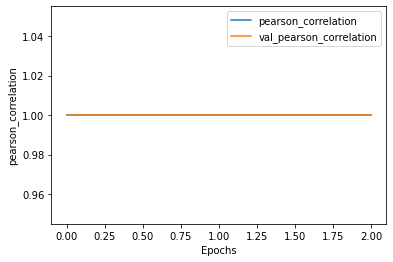

In [35]:
plot_graphs(history, 'pearson_correlation')

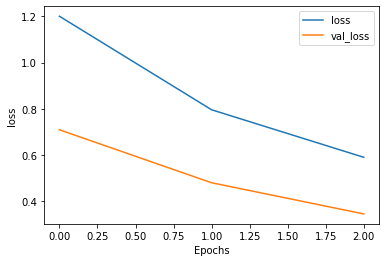

In [36]:
plot_graphs(history, 'loss')


In [37]:
test_data  = train_data[:750]

In [38]:

input_ids = []
attention_masks = []
token_type_ids = []
data_labels = []

for sent1, sent2, score in test_data[['sentence1', 'sentence2', 'score']].values:
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer_v2(clean_text(sent1), clean_text(sent2), MAX_LEN)
        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        data_labels.append(score)
    except Exception as e:
        print(e)
        print(sent1, sent2)
        pass
    
test_input_ids = np.array(input_ids, dtype=int)
test_attention_masks = np.array(attention_masks, dtype=int)
test_type_ids = np.array(token_type_ids, dtype=int)
test_inputs = (test_input_ids, test_attention_masks, test_type_ids)
test_data_labels = np.array(data_labels)

In [39]:
print("# sents: {}, # labels: {}".format(len(test_input_ids), len(test_data_labels)))

# sents: 750, # labels: 750


In [40]:
regression_model.load_weights(checkpoint_path)

results = regression_model.evaluate(test_inputs, test_data_labels, batch_size=512)
print("test loss, test pearson correlation: ", results)

y_true değeri : [1.2       4.        0.        0.        3.4       2.75      0.
 3.8       4.2       4.8       4.2       3.8       3.        0.8
 4.4       1.6       0.        0.25      5.        0.6       0.6
 1.6       2.4       4.8       4.        2.4       0.2       4.5
 1.714     2.8       3.5       0.6       3.75      5.        3.
 2.8       3.6       4.8       4.        3.4       2.6       3.6
 1.2       4.5       3.4       3.6       5.        0.5       1.
 0.4       4.6       1.6       3.6       3.5       1.        3.8
 3.        2.6       3.6       0.4       0.        2.2       1.8
 2.8       0.        0.6       3.75      2.4       2.6       3.6
 4.4       0.8       2.8       0.        3.6       1.        3.4
 4.6       0.8       5.        4.        2.2       4.4       0.2
 1.6       4.6       0.4       0.8       5.        4.4       2.2
 2.        0.        2.2       0.8       5.        2.8       2.8
 3.2       3.2       0.        4.        3.        0.6       2.6
 0.        3

1/2 [==============>...............] - ETA: 26s - loss: 0.6971 - pearson_correlation: 1.0000y_true değeri : [1.2       4.        0.        0.        3.4       2.75      0.
 3.8       4.2       4.8       4.2       3.8       3.        0.8
 4.4       1.6       0.        0.25      5.        0.6       0.6
 1.6       2.4       4.8       4.        2.4       0.2       4.5
 1.714     2.8       3.5       0.6       3.75      5.        3.
 2.8       3.6       4.8       4.        3.4       2.6       3.6
 1.2       4.5       3.4       3.6       5.        0.5       1.
 0.4       4.6       1.6       3.6       3.5       1.        3.8
 3.        2.6       3.6       0.4       0.        2.2       1.8
 2.8       0.        0.6       3.75      2.4       2.6       3.6
 4.4       0.8       2.8       0.        3.6       1.        3.4
 4.6       0.8       5.        4.        2.2       4.4       0.2
 1.6       4.6       0.4       0.8       5.        4.4       2.2
 2.        0.        2.2       0.8       5.       

2/2 [==============================] - 38s 12s/step - loss: 0.6971 - pearson_correlation: 1.0000
test loss, test pearson correlation:  [0.6971315741539001, 0.9999999999999994]


__main__.TFBertRegressor